In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

# 3. Prediction of EV and ICE purchase in the next 5 years.

In [2]:
data = pd.read_csv(r"C:\Users\harri\Desktop\DataScienceProj\005_CarPurchase\EVnICE.csv")

In [3]:
data.head(10)

,Unnamed: 0,year,carType
0,0,2011,ICE
1,1,2011,ICE
2,2,2011,ICE
3,3,2011,ICE
4,4,2011,ICE
5,5,2011,EV
6,6,2011,ICE
7,7,2011,ICE
8,8,2011,ICE
9,9,2011,ICE


In [4]:
data.drop('Unnamed: 0', inplace=True, axis=1)

In [5]:
data["year"].value_counts()

2020    4252
2013    4238
2016    4235
2018    4201
2017    4198
2019    4191
2012    4180
2015    4179
2021    4153
2014    4149
2011    4095
Name: year, dtype: int64

In [6]:
data.head()

,year,carType
0,2011,ICE
1,2011,ICE
2,2011,ICE
3,2011,ICE
4,2011,ICE


In [7]:
data.groupby(["year"], as_index=False).count()

,year,carType
0,2011,4095
1,2012,4180
2,2013,4238
3,2014,4149
4,2015,4179
5,2016,4235
6,2017,4198
7,2018,4201
8,2019,4191
9,2020,4252


# **ICE**

In [8]:
ice = data.query('carType == "ICE"').groupby(["year"], as_index=False).count()
ice.rename(columns={"carType": "count"}, inplace=True)
ice


,year,count
0,2011,4070
1,2012,4136
2,2013,4174
3,2014,4069
4,2015,4093
5,2016,4121
6,2017,4071
7,2018,4067
8,2019,3988
9,2020,3816


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

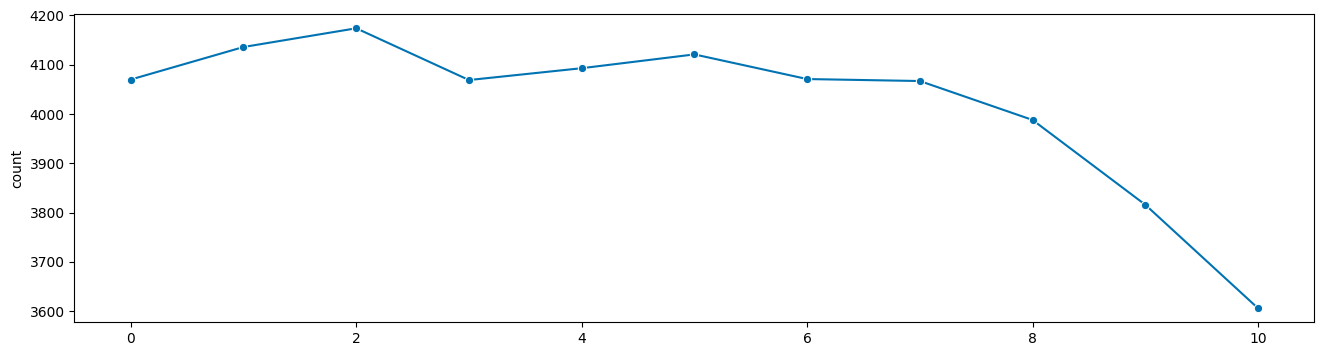

In [9]:
plot_series(ice["count"])

From the graph, it does not have seasonal component and trend shows a decreasing pattern (but not significant). Also, it is not stationary which is not suitable to be used for forecasting algoritm. Later, I apply a method to preserve the stationary feature from time series.

## TIME FEATURE

C:\Users\harri\AppData\Local\Temp\ipykernel_10600\473529809.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Text(0.5, 1.0, 'Time Plot of ICE Car Sales')

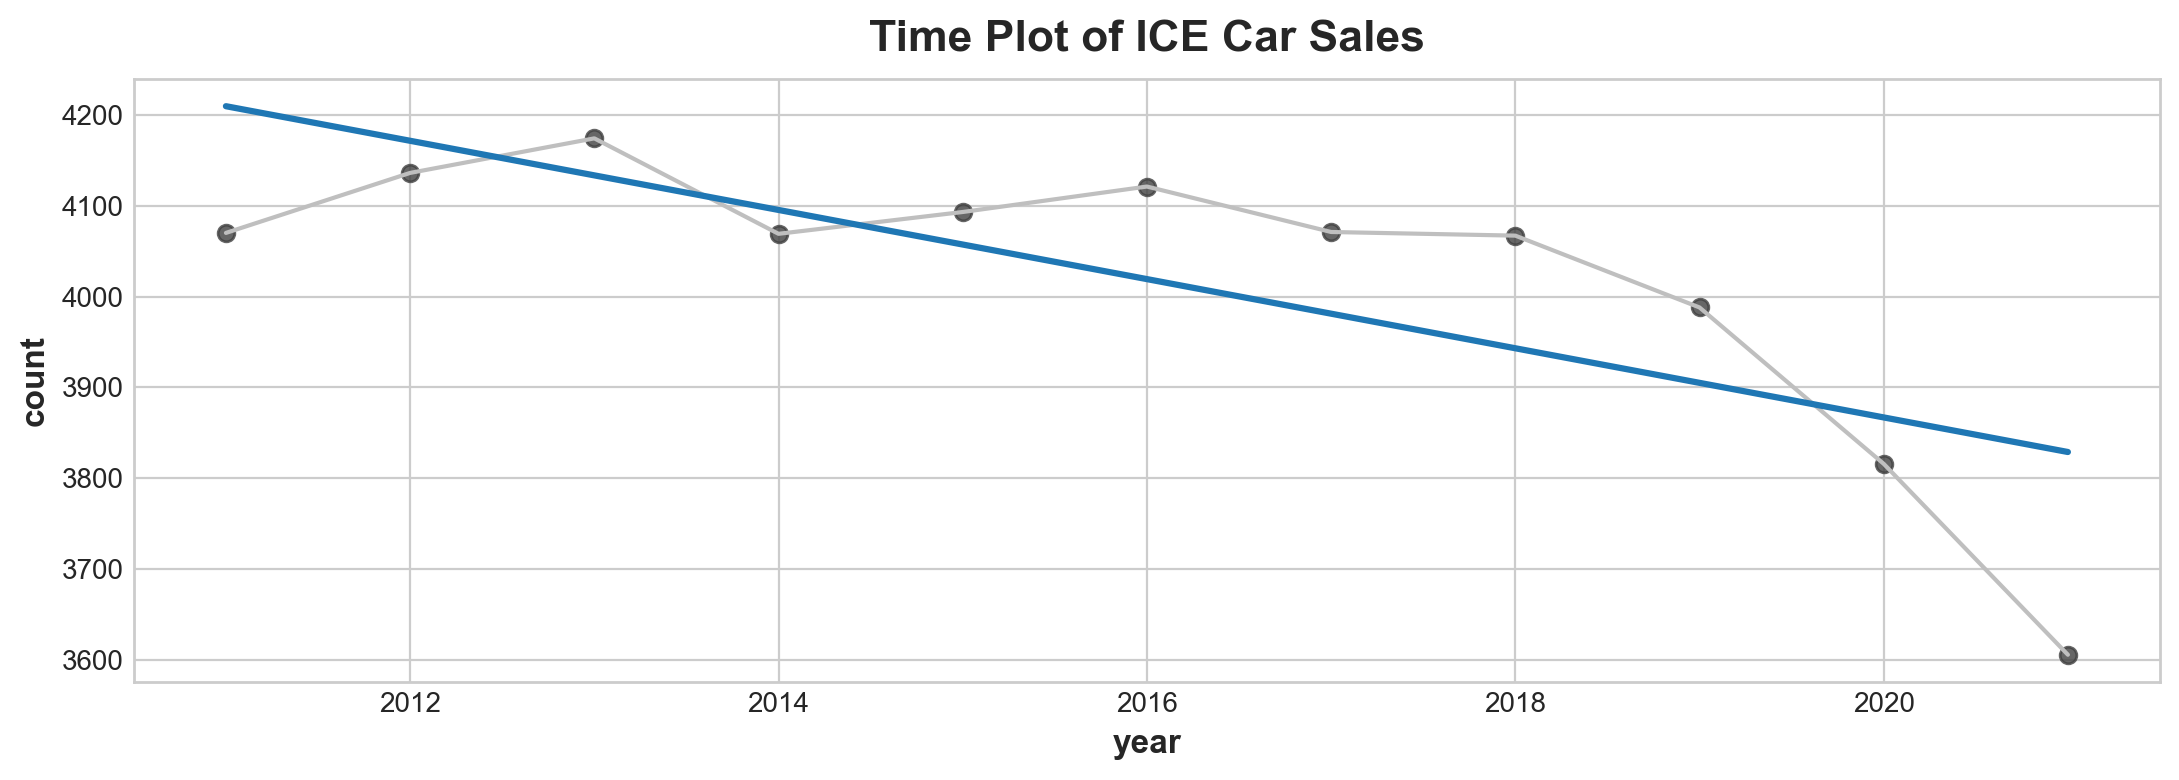

In [10]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('year', 'count', data=ice, color='0.75')
ax = sns.regplot(x='year', y='count', data=ice, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of ICE Car Sales')

In [11]:
print("Range of ICE is (" + str(ice["count"].min()) + "," + str(ice["count"].max()) + ")")

Range of ICE is (3606,4174)


## LAG Feature

In [12]:
ice_copy1 = ice.copy()


ice_copy1['Lag_1'] = ice_copy1['count'].shift(1)
df = ice_copy1.reindex(columns=['count', 'Lag_1'])

df.head()

,count,Lag_1
0,4070,NaN
1,4136,4070.0
2,4174,4136.0
3,4069,4174.0
4,4093,4069.0


In [13]:
ice_copy1.head()

,year,count,Lag_1
0,2011,4070,NaN
1,2012,4136,4070.0
2,2013,4174,4136.0
3,2014,4069,4174.0
4,2015,4093,4069.0


Text(0.5, 1.0, 'Lag Plot of ICE Car Sales')

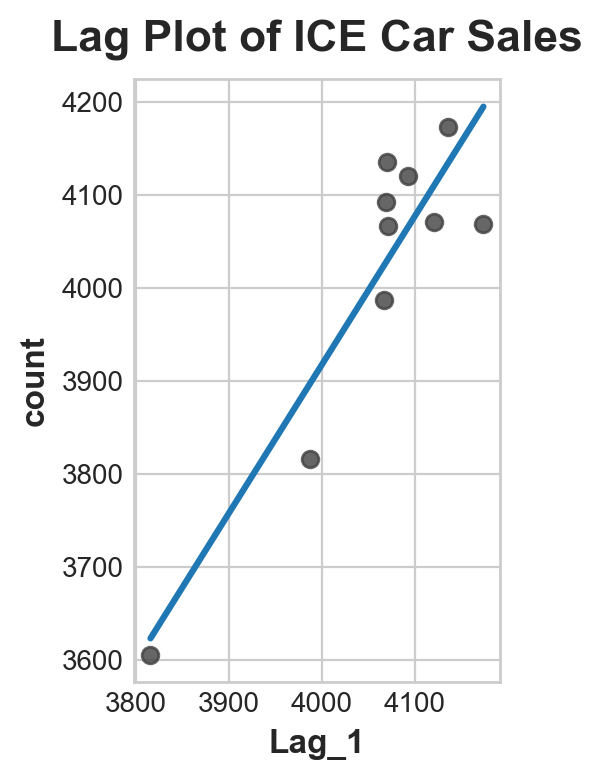

In [14]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='count', data=ice_copy1, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of ICE Car Sales')

From the lag plot, ice car purchase sale does not show a significant correlation with previous year (lag_1) because it shows slight decrease on previous year may contribute small effect on the next year purchase

https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

## ARIMA


In [15]:
from sktime.forecasting.arima import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [16]:
ice_copy2 = ice.copy()

In [17]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \tlags:{results[1]}")
    return (s, results[0])

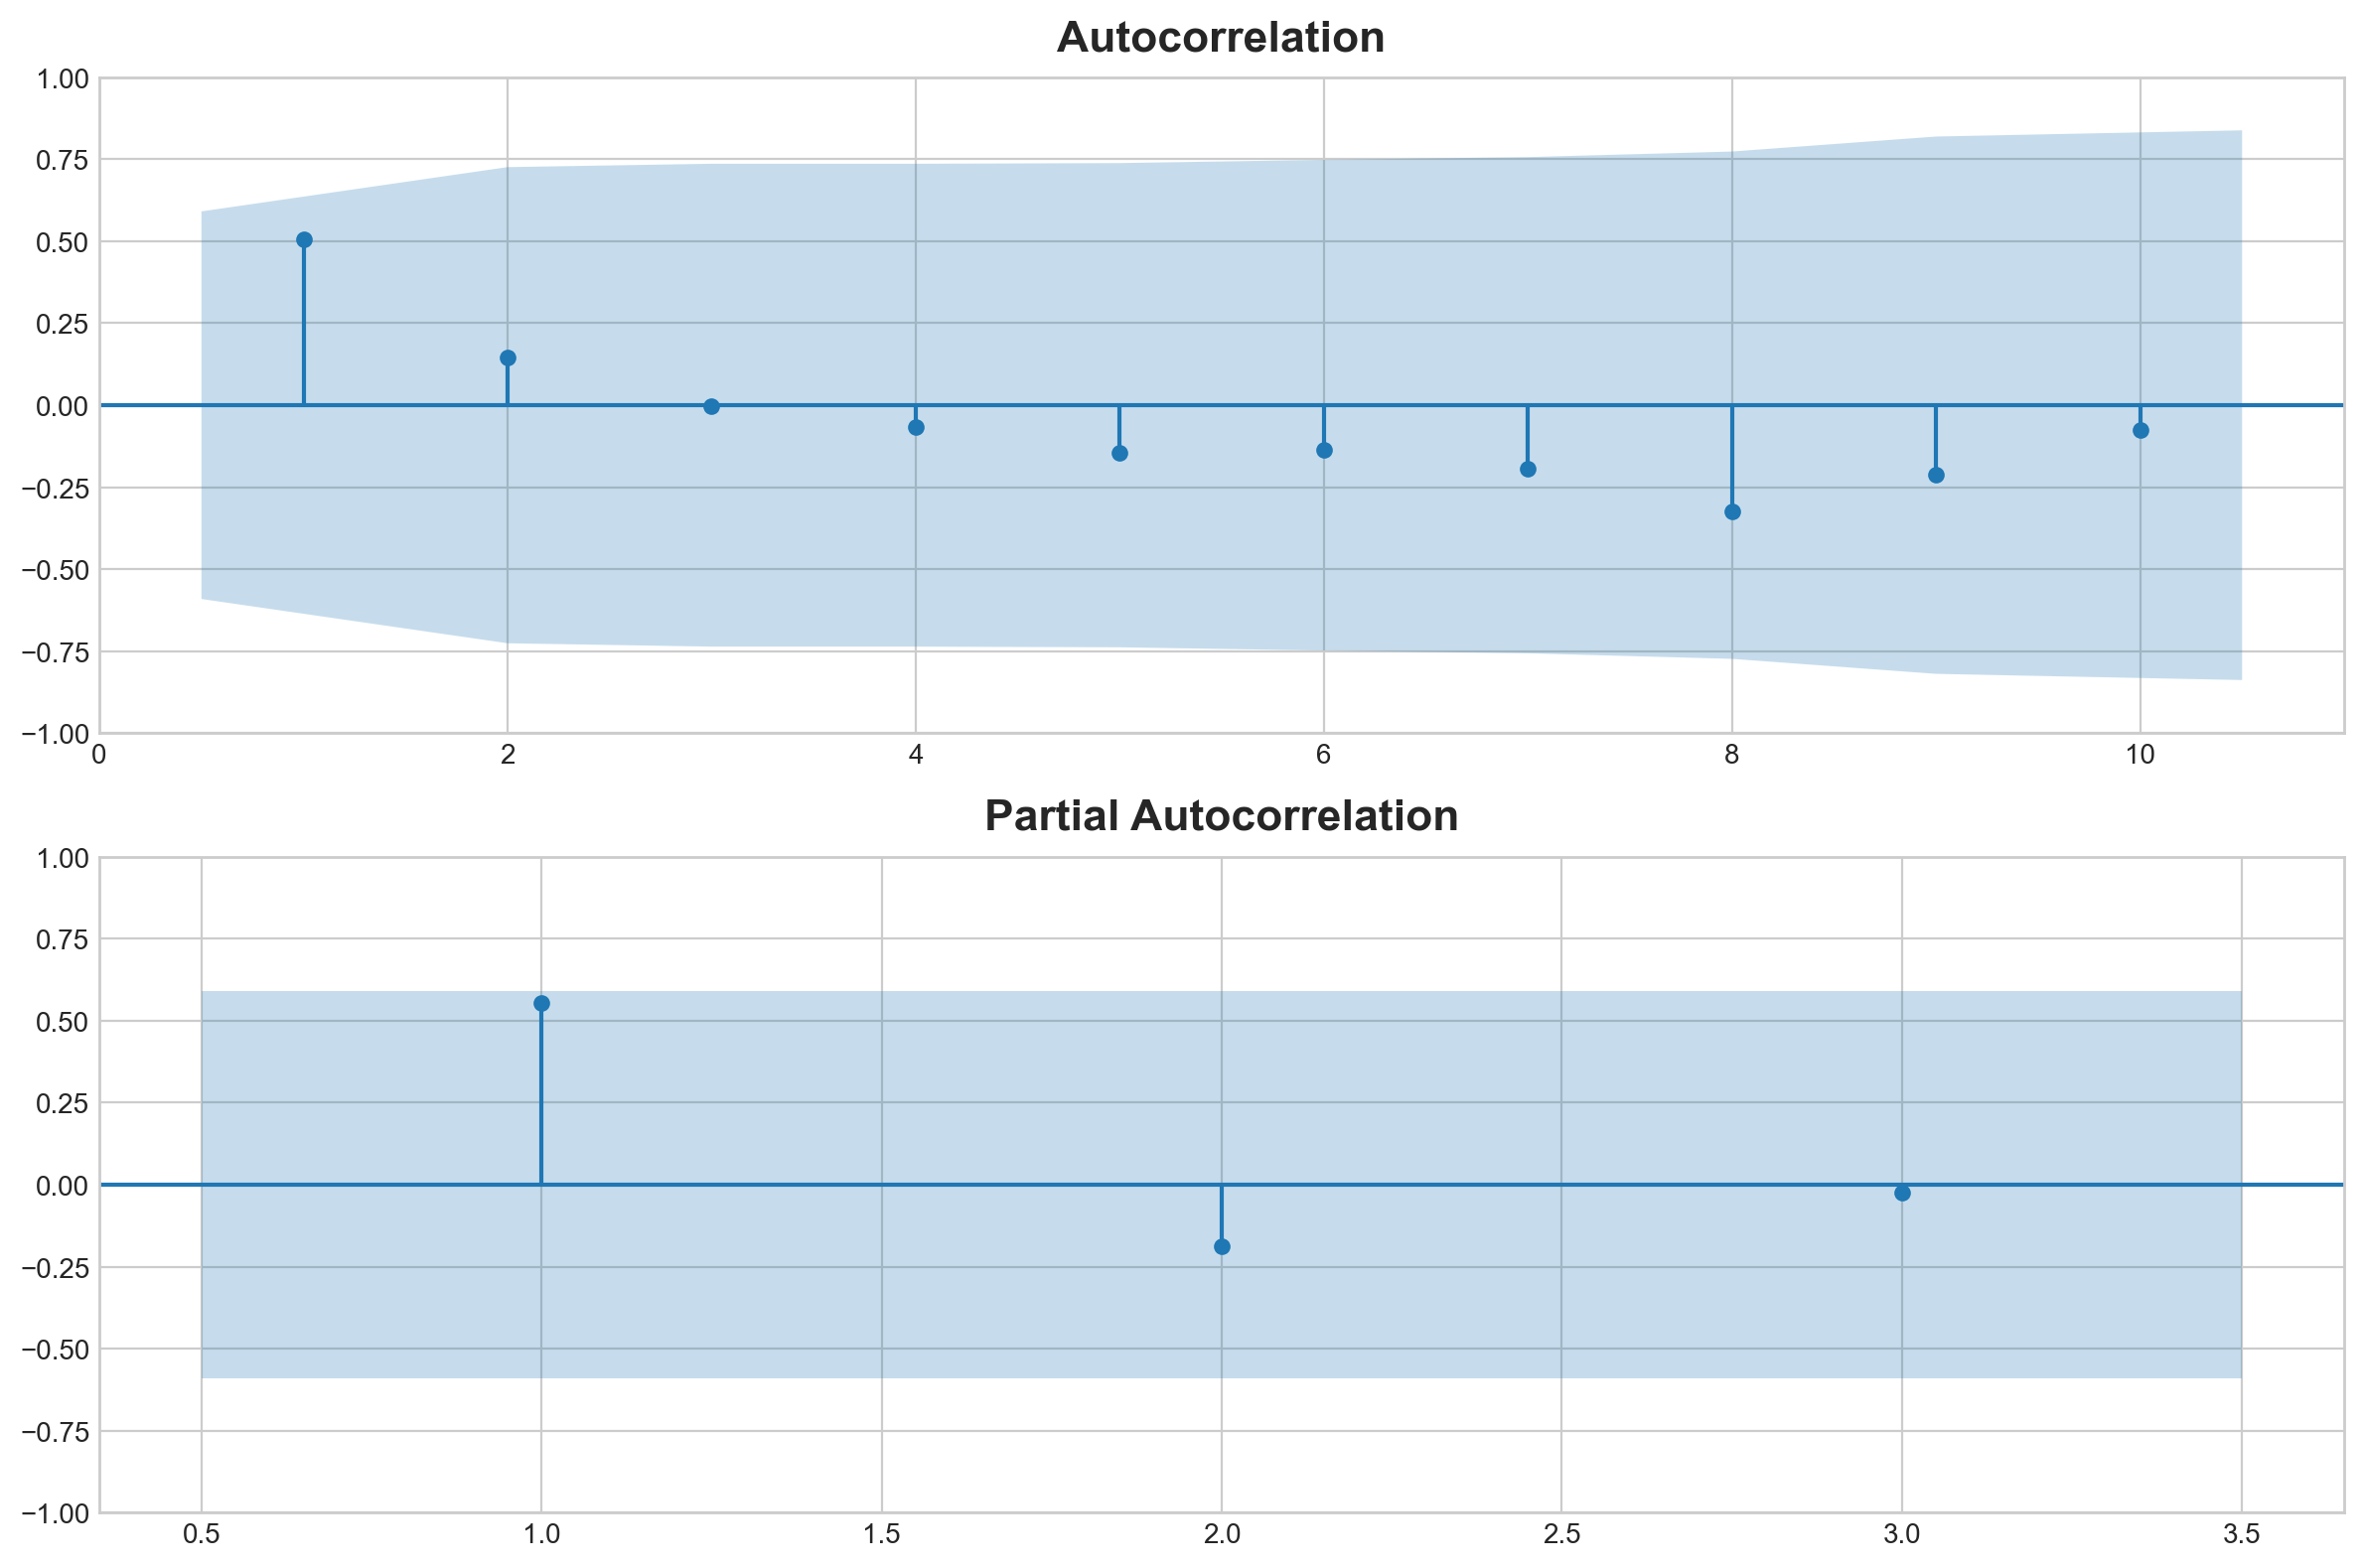

'Non-Stationary	 p-value:1.0 	lags:2


('Non-Stationary', 1.0)

In [18]:
ice_diff = ice.diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ice_copy2["count"], zero=False, ax=ax[0])
plot_pacf(ice_copy2["count"], zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ice_copy2["count"])

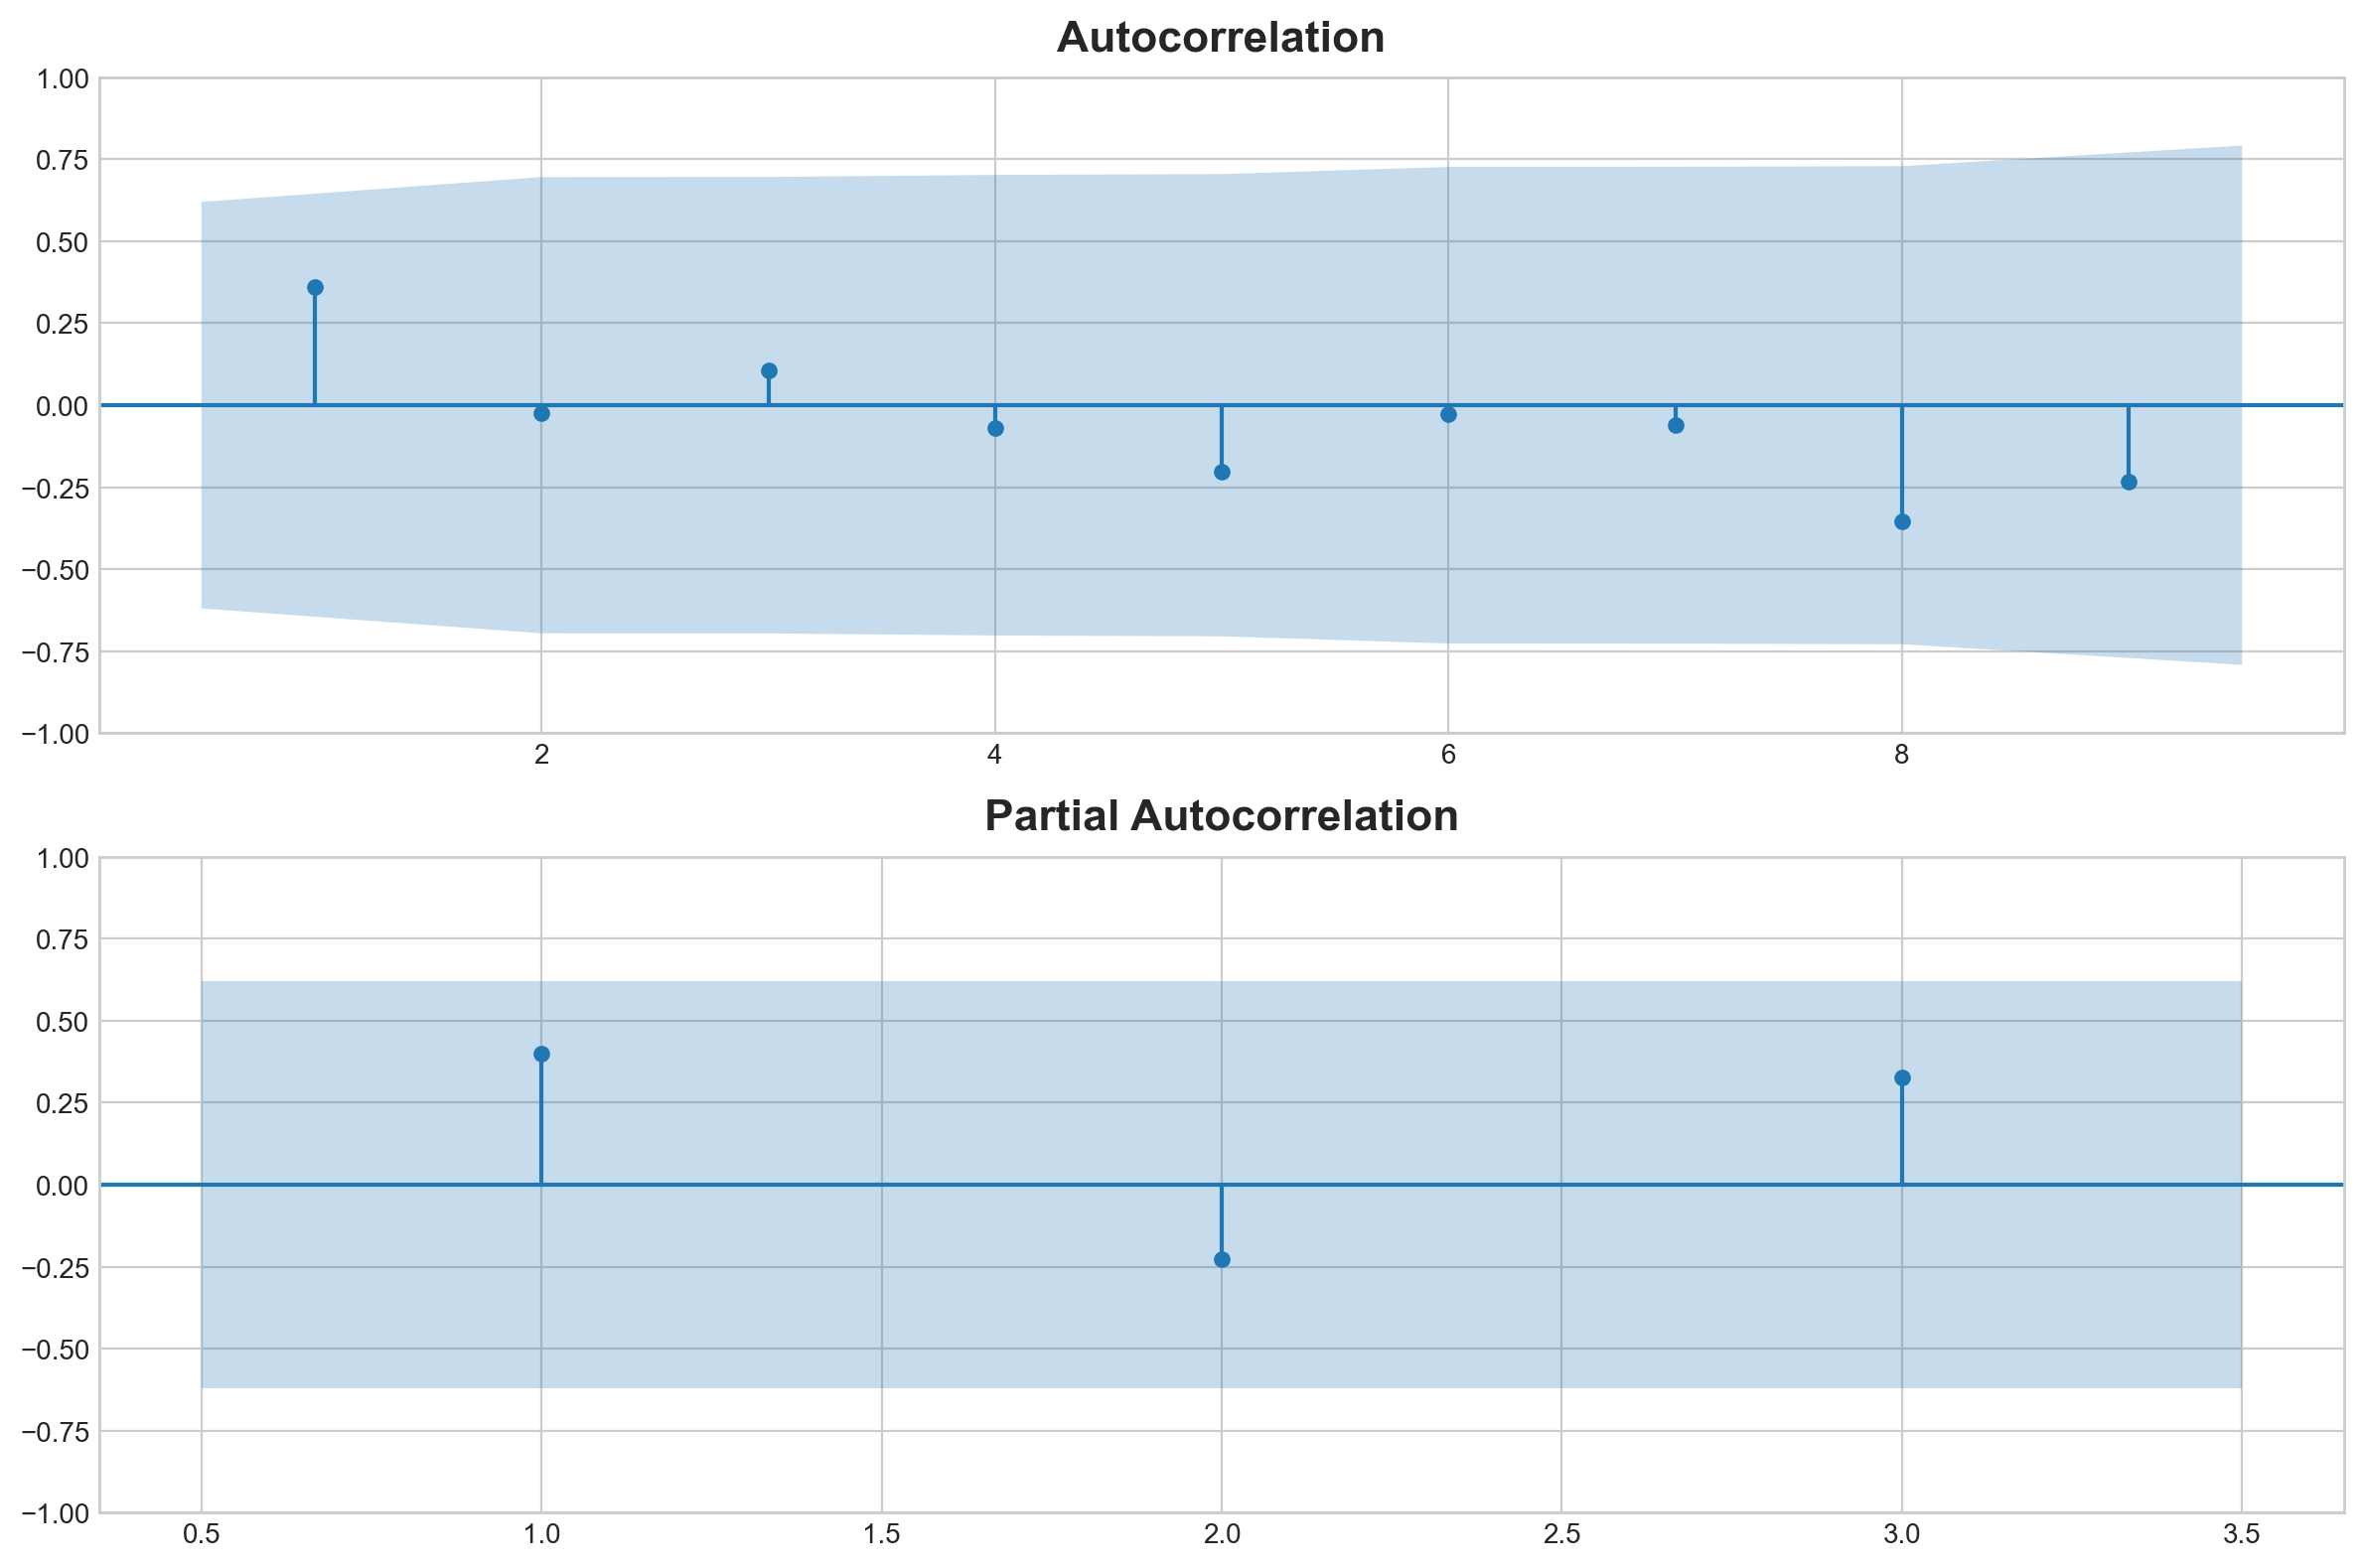

'Non-Stationary	 p-value:0.8934149115329184 	lags:3


('Non-Stationary', 0.8934149115329184)

In [19]:
#1st order
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ice_copy2["count"].diff().dropna(), zero=False, ax=ax[0])
plot_pacf(ice_copy2["count"].diff().dropna(), zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ice_copy2["count"].diff().dropna())

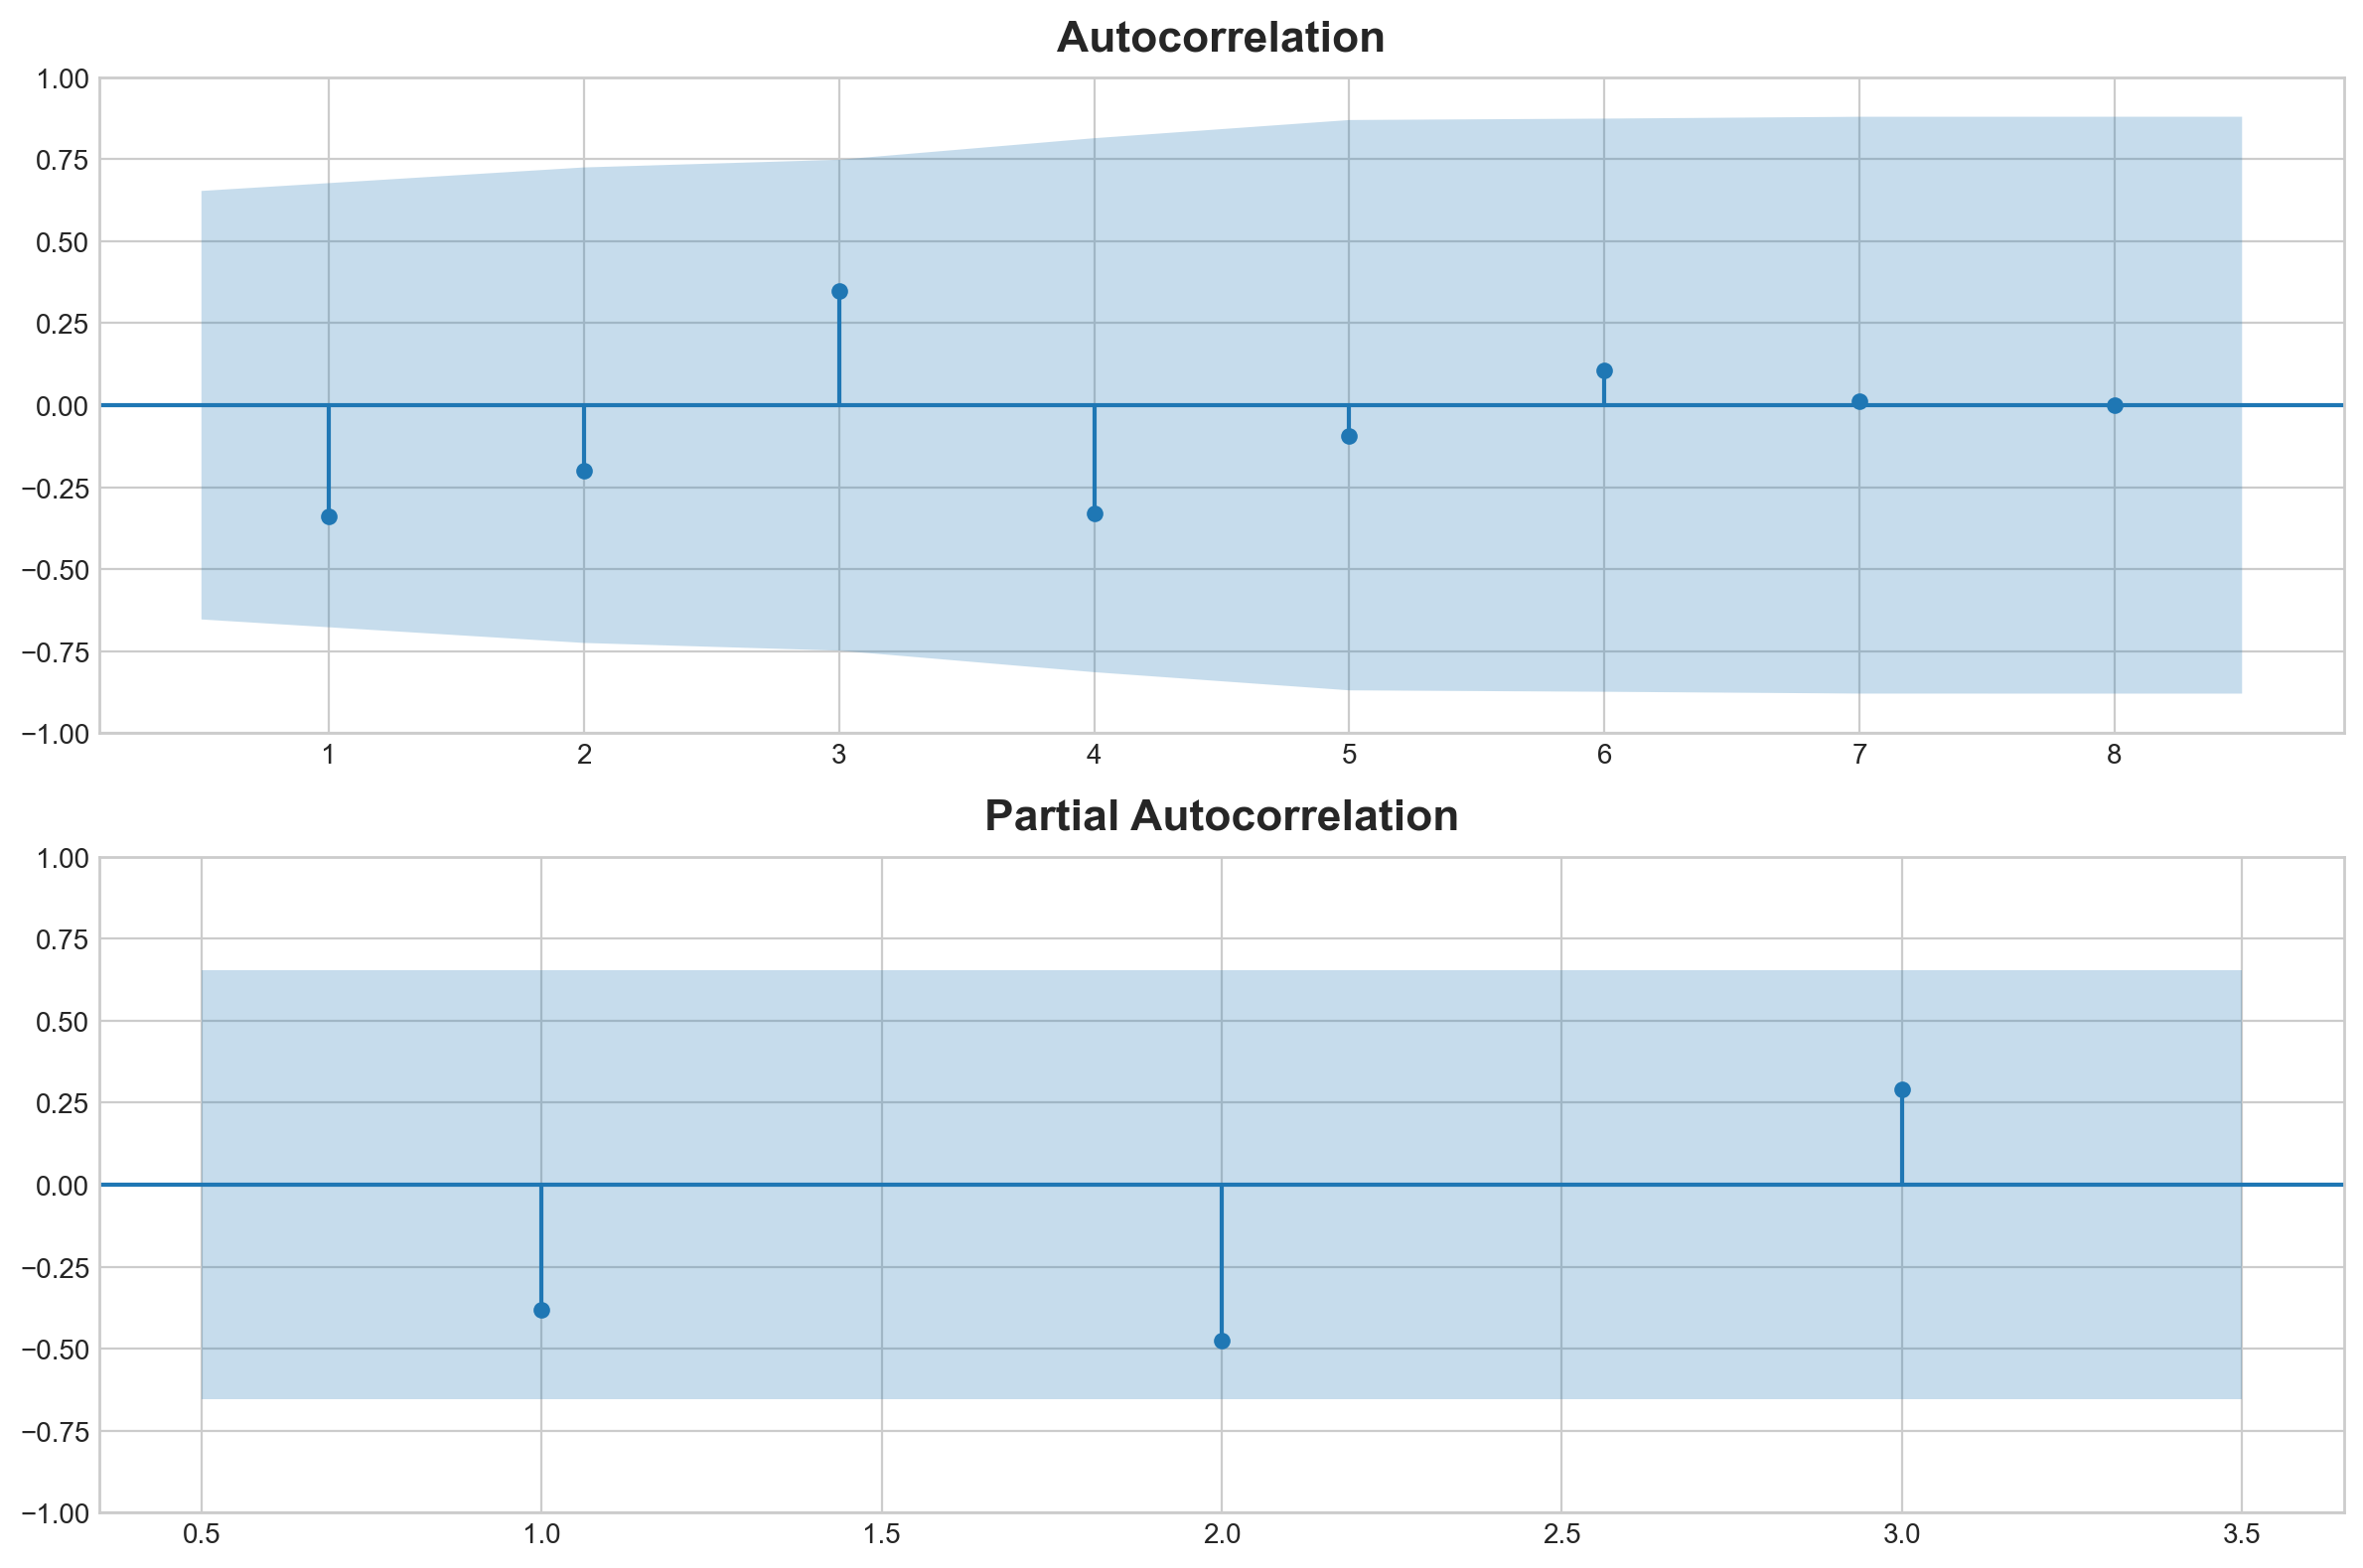

'Non-Stationary	 p-value:0.8934149115329184 	lags:3


('Non-Stationary', 0.8934149115329184)

In [20]:
#2nd order
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ice_copy2["count"].diff().diff().dropna(), zero=False, ax=ax[0])
plot_pacf(ice_copy2["count"].diff().diff().dropna(), zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ice_copy2["count"].diff().dropna())

In [21]:

ice_copy2 = ice_copy2.set_index("year")
ice_copy2

,count
year,
2011,4070
2012,4136
2013,4174
2014,4069
2015,4093
2016,4121
2017,4071
2018,4067
2019,3988


In [22]:
ice_copy2.index

Int64Index([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype='int64', name='year')

In [23]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
y_train, y_test = temporal_train_test_split(ice_copy2, test_size=2)
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [24]:
fh

ForecastingHorizon([2020, 2021], dtype='int64', name='year', is_relative=False)

0.07489039891696038

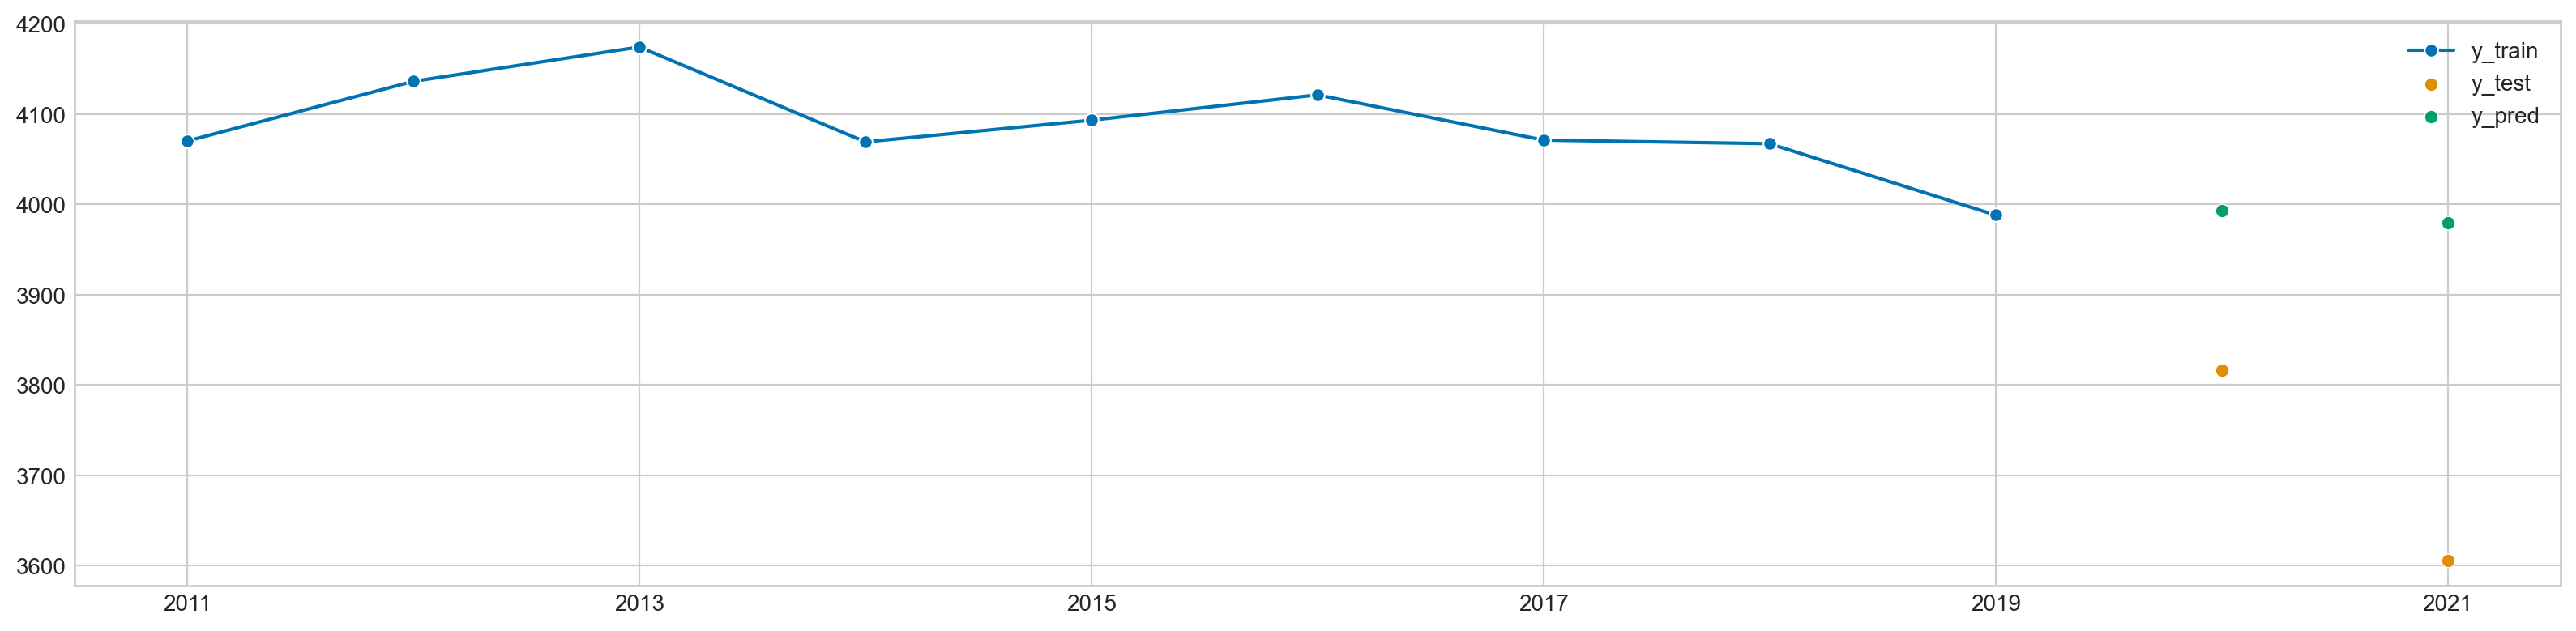

In [25]:
forecaster = ARIMA(order=(1, 1, 0),  suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [26]:
y_pred

,count
2020,3992.586928
2021,3979.240463


In [27]:
y_eval = pd.DataFrame({"year":[2022,2023,2024,2025,2026], "count":[0,0,0,0,0]})

In [28]:
y_eval = y_eval.set_index("year")

In [29]:
new_fh = ForecastingHorizon(y_eval.index, is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

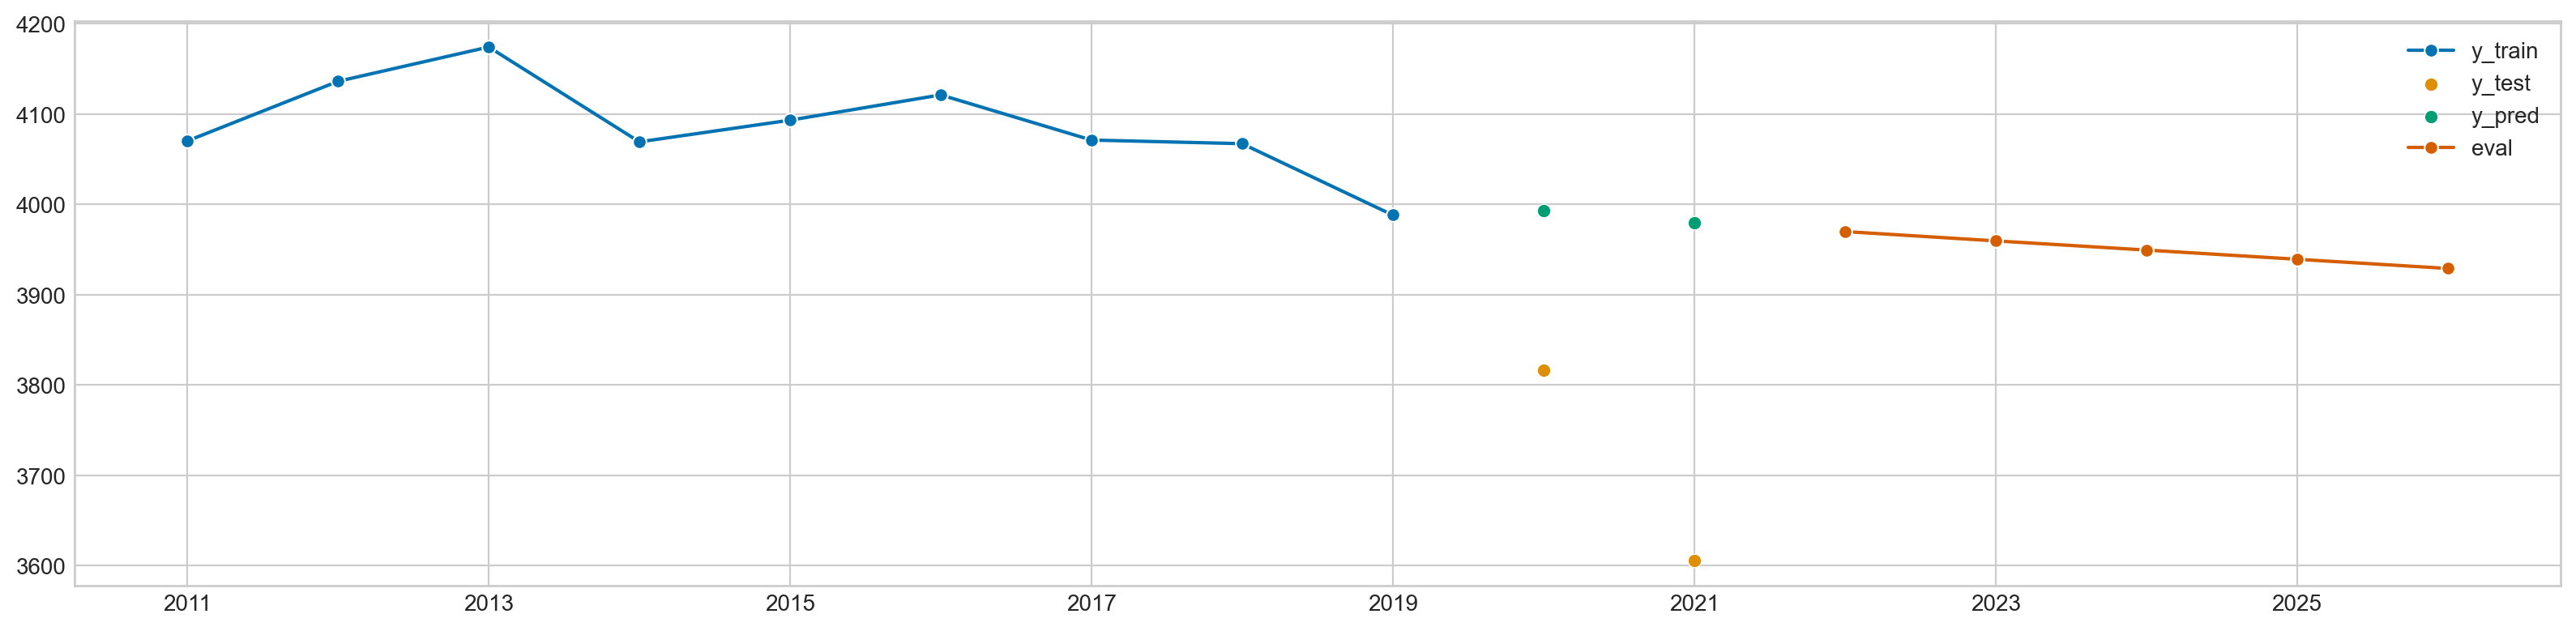

In [30]:

y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test", "y_pred", "eval"])


## Exponential Smoothing

In [31]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.08530601108508823

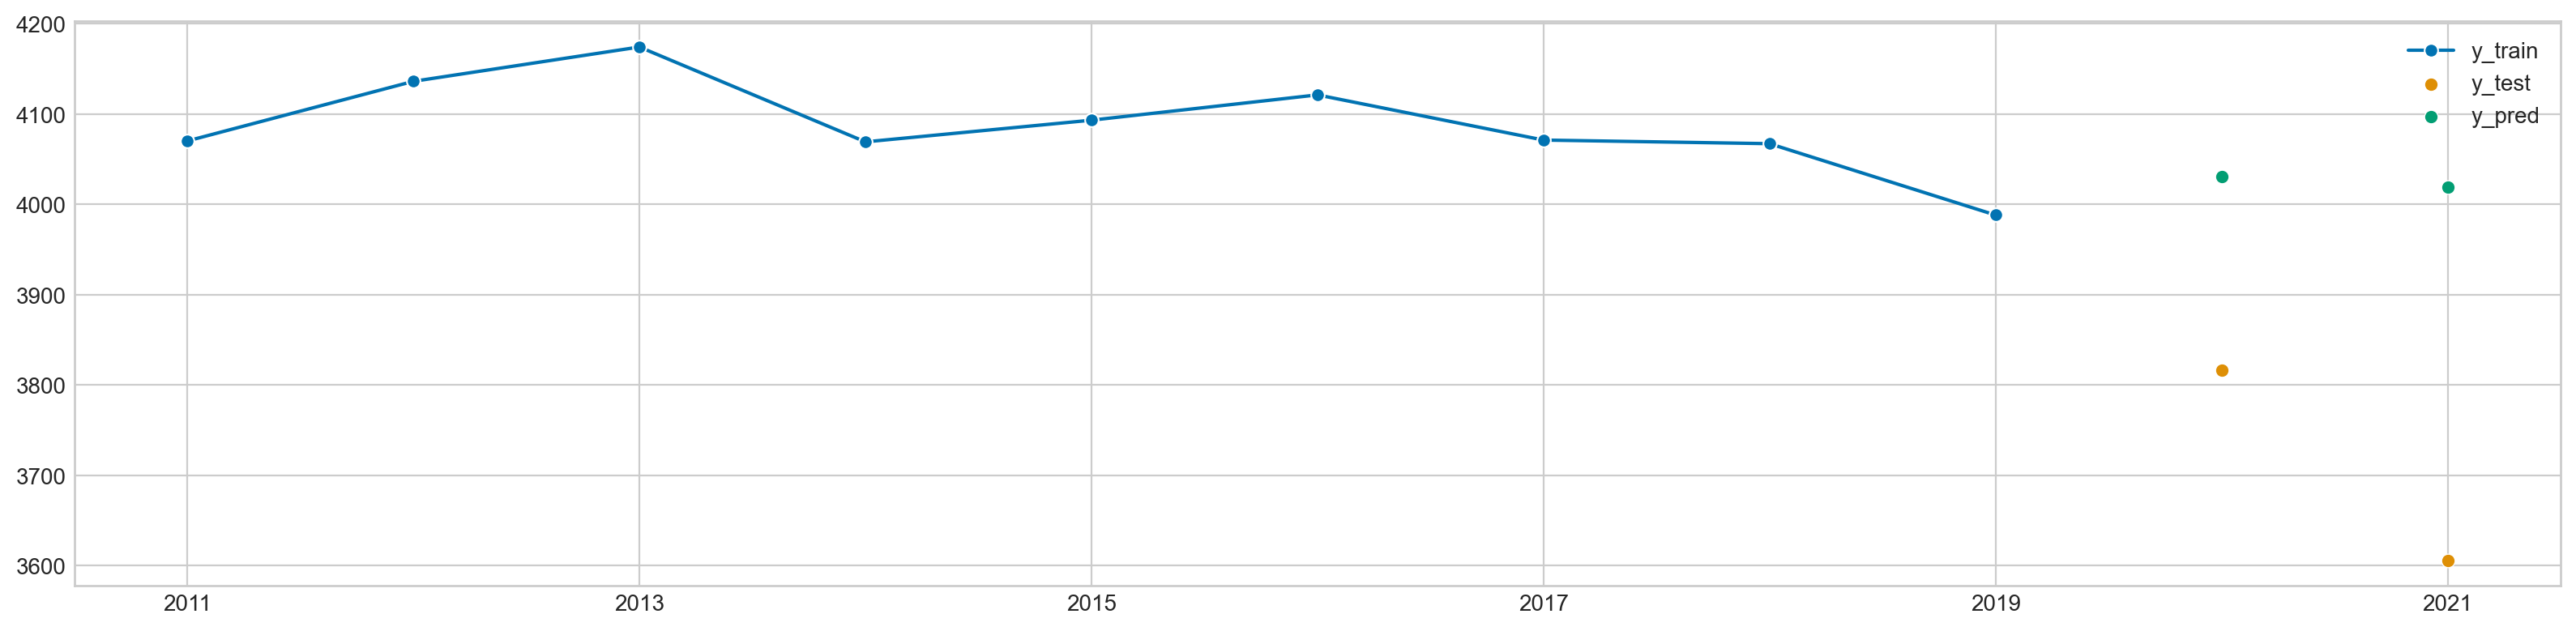

In [32]:
forecaster = ExponentialSmoothing(trend="add")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

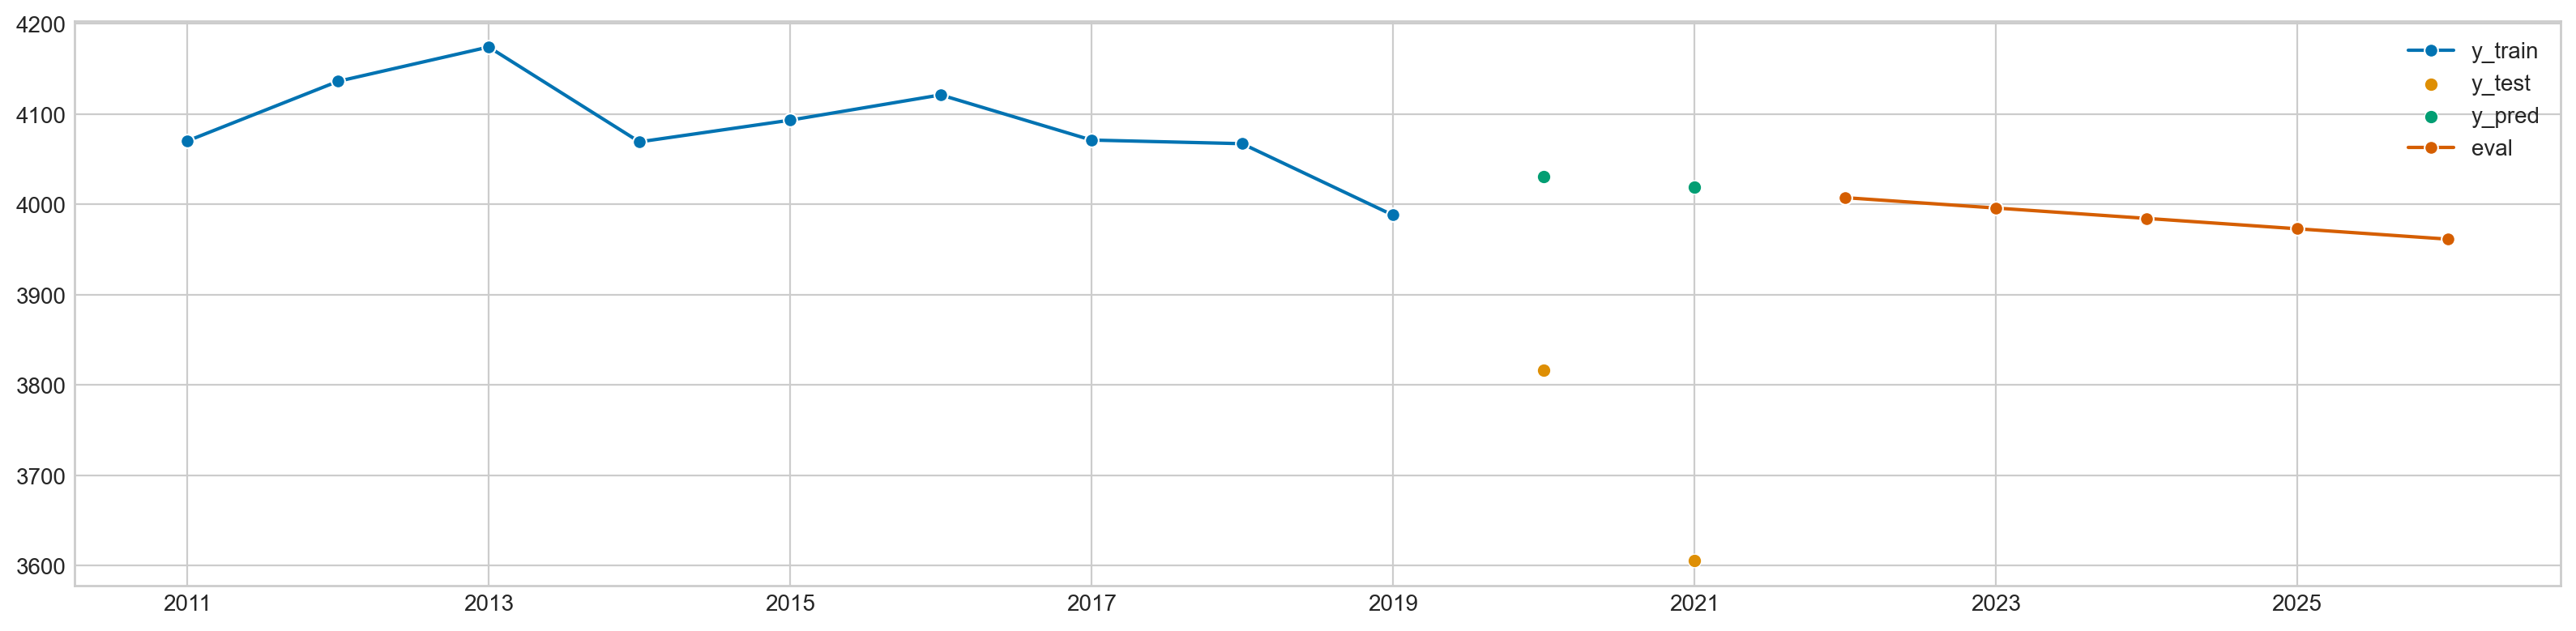

In [33]:

y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test", "y_pred", "eval"])


MACHINE LEARNING

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [35]:
ice

,year,count
0,2011,4070
1,2012,4136
2,2013,4174
3,2014,4069
4,2015,4093
5,2016,4121
6,2017,4071
7,2018,4067
8,2019,3988
9,2020,3816


In [36]:
ice_cop3 = ice.copy()

In [37]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [38]:
def split_data(df, test_split=0.25):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [39]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [40]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [41]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

In [43]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [44]:
ice_cop3 = ice_cop3.set_index("year")

In [45]:
ice_cop3.head()

,count
year,
2011,4070
2012,4136
2013,4174
2014,4069
2015,4093


In [46]:
ice_os = one_step_forecast(ice_cop3, 3)
print(ice_os.shape)

(8, 4)


In [47]:
ice_os.head()

,x_1,x_2,x_3,y
year,,,,
2011,4070,4136,4174,4069
2012,4136,4174,4069,4093
2013,4174,4069,4093,4121
2014,4069,4093,4121,4071
2015,4093,4121,4071,4067


In [48]:
train, test = split_data(ice_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 6 Test: 2


In [49]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

,x_1,x_2,x_3,y
year,,,,
2011,-0.984501,0.618758,1.778439,0.018780
2012,0.619871,1.546895,-0.716921,0.559649
2013,1.543601,-1.017694,-0.146553,1.190663
2014,-1.008810,-0.431502,0.518876,0.063853
2015,-0.425402,0.252388,-0.669390,-0.026292


In [50]:
y_train_original = scaler.inverse_y(train_s['y'])

In [51]:
train_original = scaler.inverse(train_s)
train_original.head()

,x_1,x_2,x_3,y
year,,,,
2011,4070.0,4136.0,4174.0,4069.0
2012,4136.0,4174.0,4069.0,4093.0
2013,4174.0,4069.0,4093.0,4121.0
2014,4069.0,4093.0,4121.0,4071.0
2015,4093.0,4121.0,4071.0,4067.0


In [52]:
from sklearn.linear_model import( LinearRegression, ElasticNet, Ridge, Lasso, HuberRegressor)

In [53]:
train_s.head()

,x_1,x_2,x_3,y
year,,,,
2011,-0.984501,0.618758,1.778439,0.018780
2012,0.619871,1.546895,-0.716921,0.559649
2013,1.543601,-1.017694,-0.146553,1.190663
2014,-1.008810,-0.431502,0.518876,0.063853
2015,-0.425402,0.252388,-0.669390,-0.026292


In [54]:
test_s.head()

,x_1,x_2,x_3,y
year,,,,
2017,-0.960193,-1.066543,-2.641913,-5.682880
2018,-1.057427,-2.996091,-6.729549,-10.415484


In [55]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [56]:
ice_results = train_different_models(train_s, test_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [57]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
ice_results = pd.DataFrame(ice_results)
ice_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
0,Linear Regression,3.953885,0.494358,4.642890
2,Ridge Regression,4.810834,0.592475,5.614934
4,Huber Regression,5.227003,0.636377,6.071086
1,Elastic Net,8.366851,0.996838,9.624868
3,Lasso Regression,8.389798,1.000000,9.653153


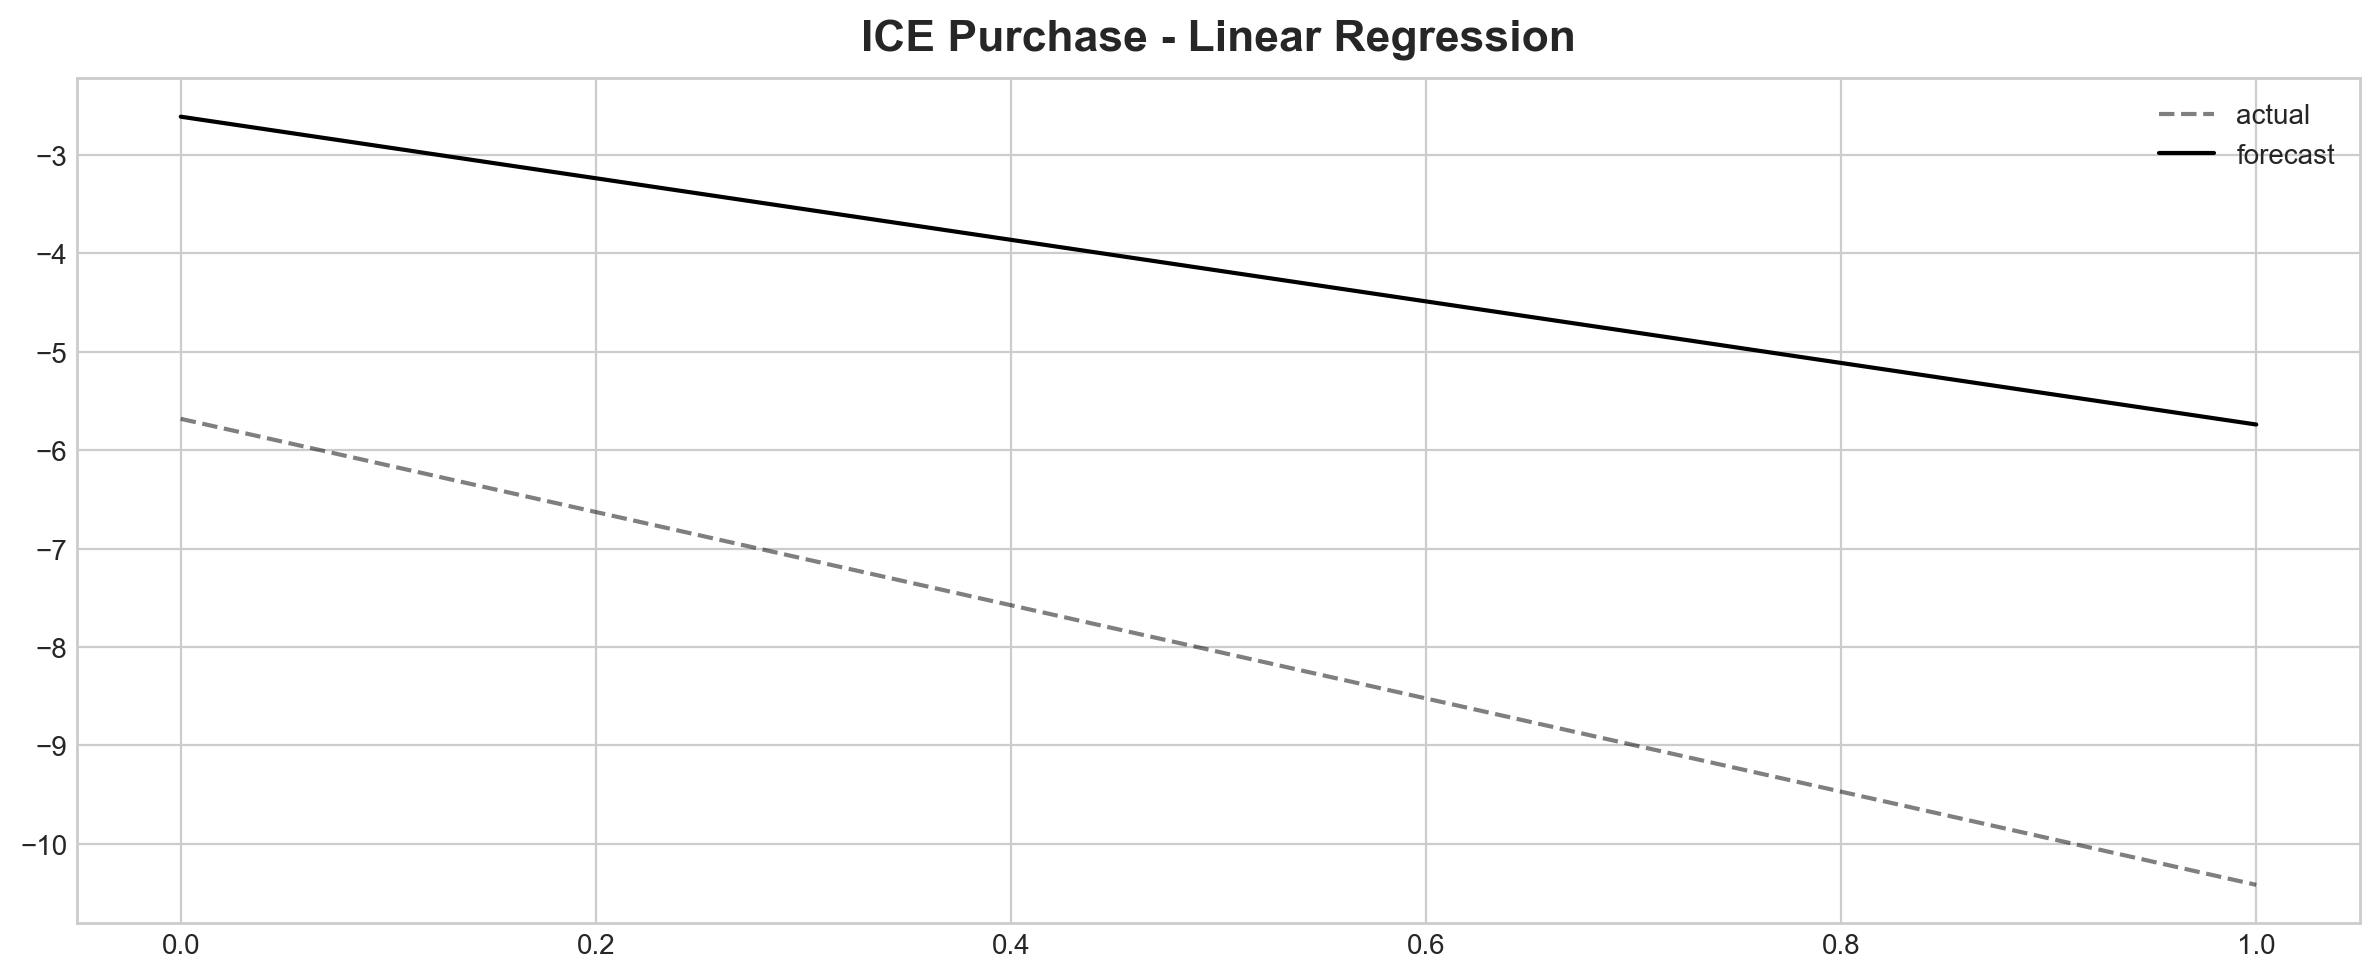

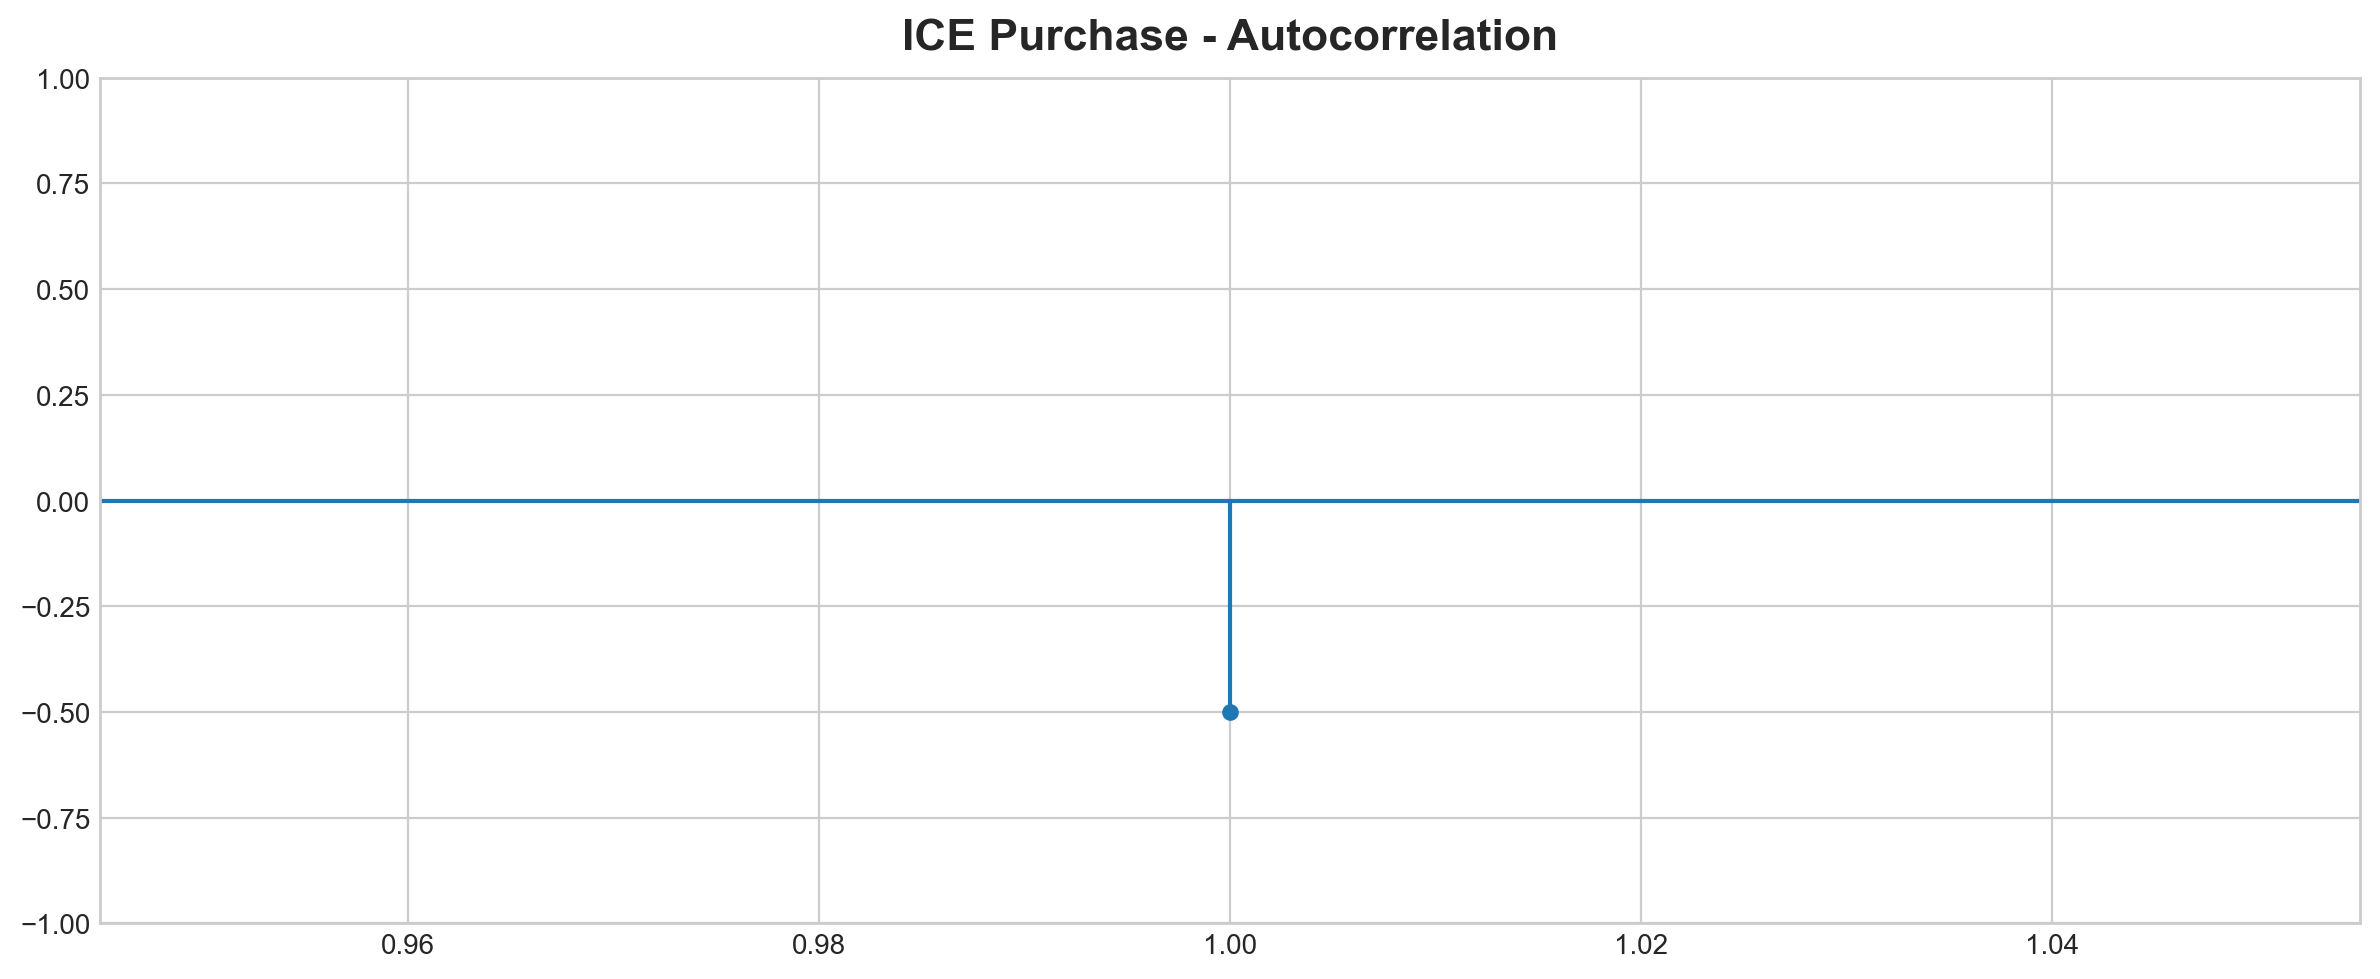

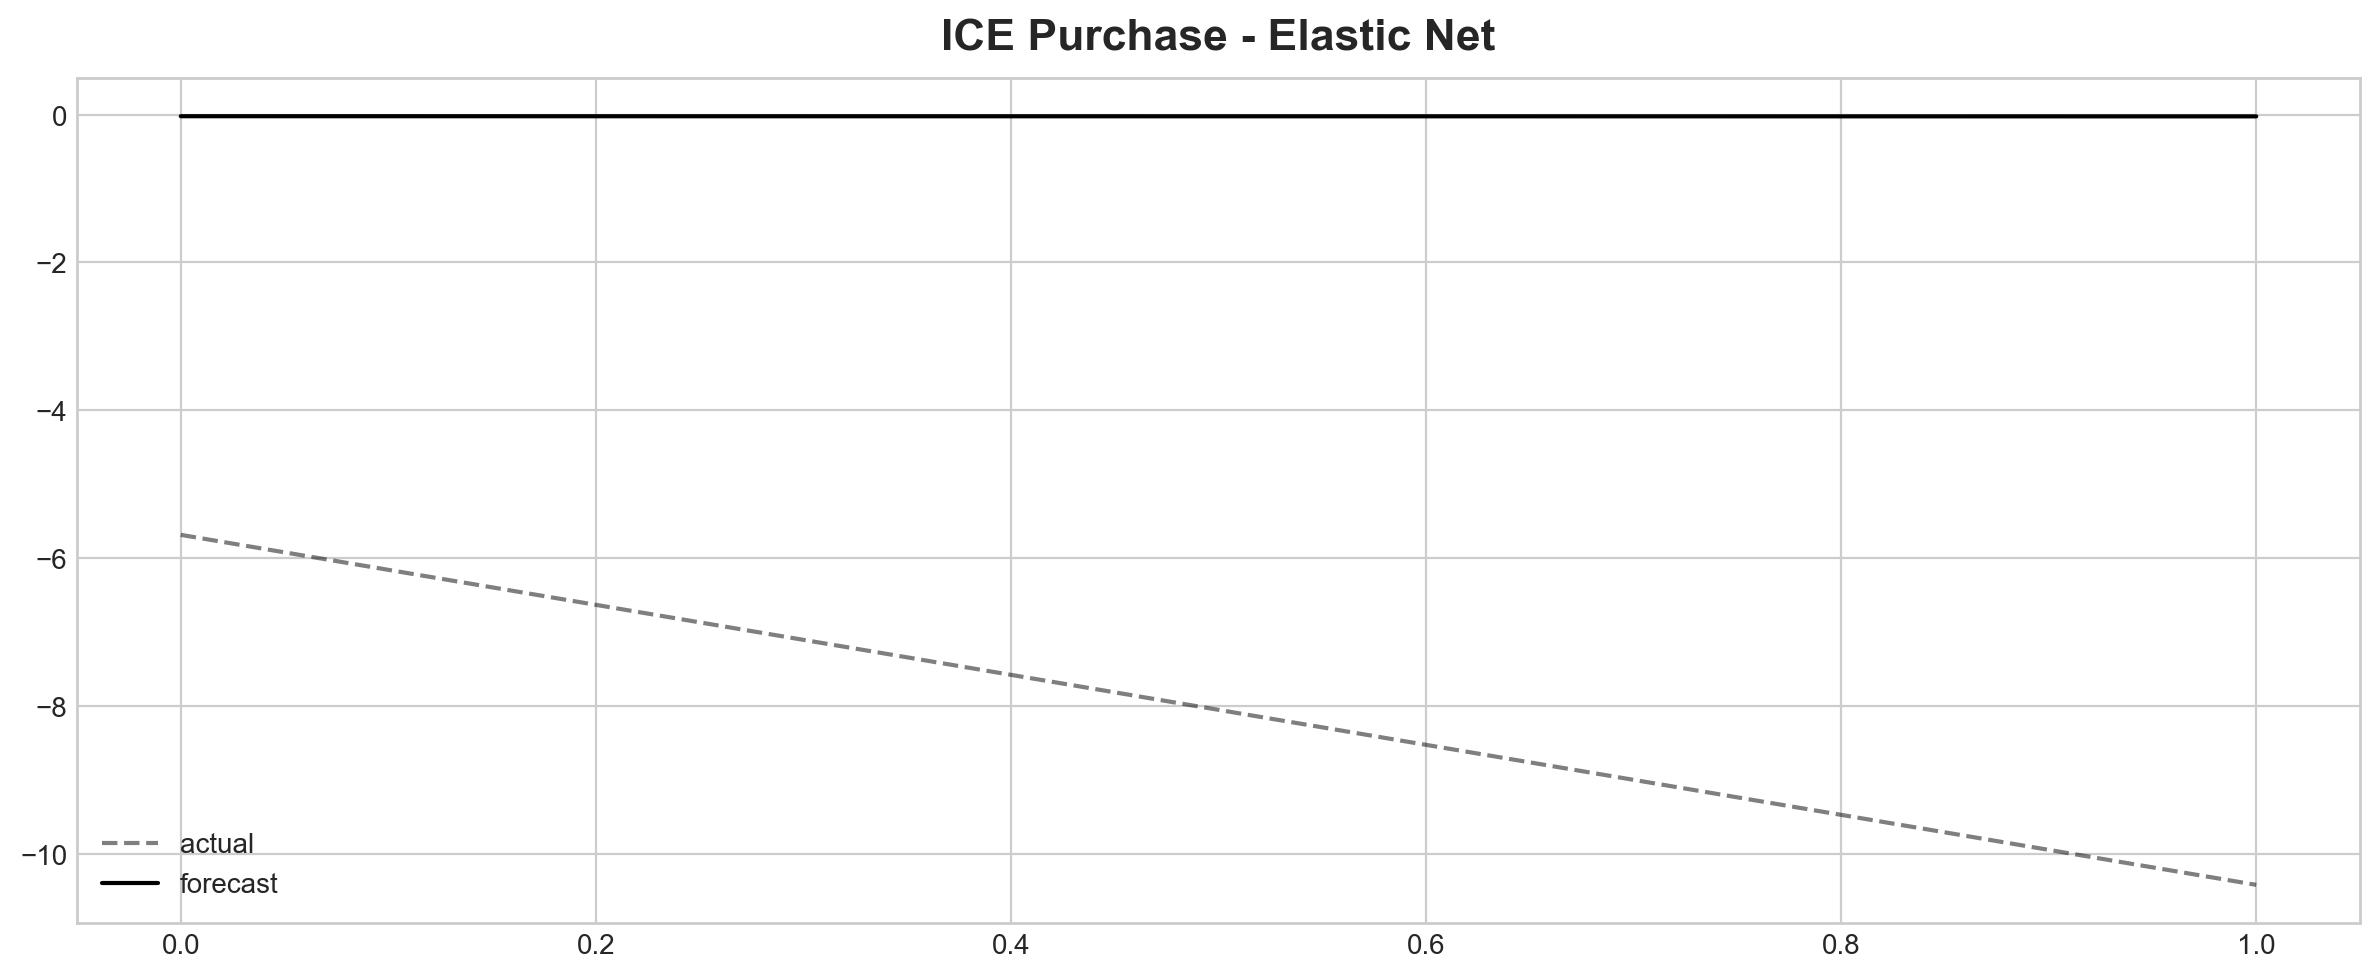

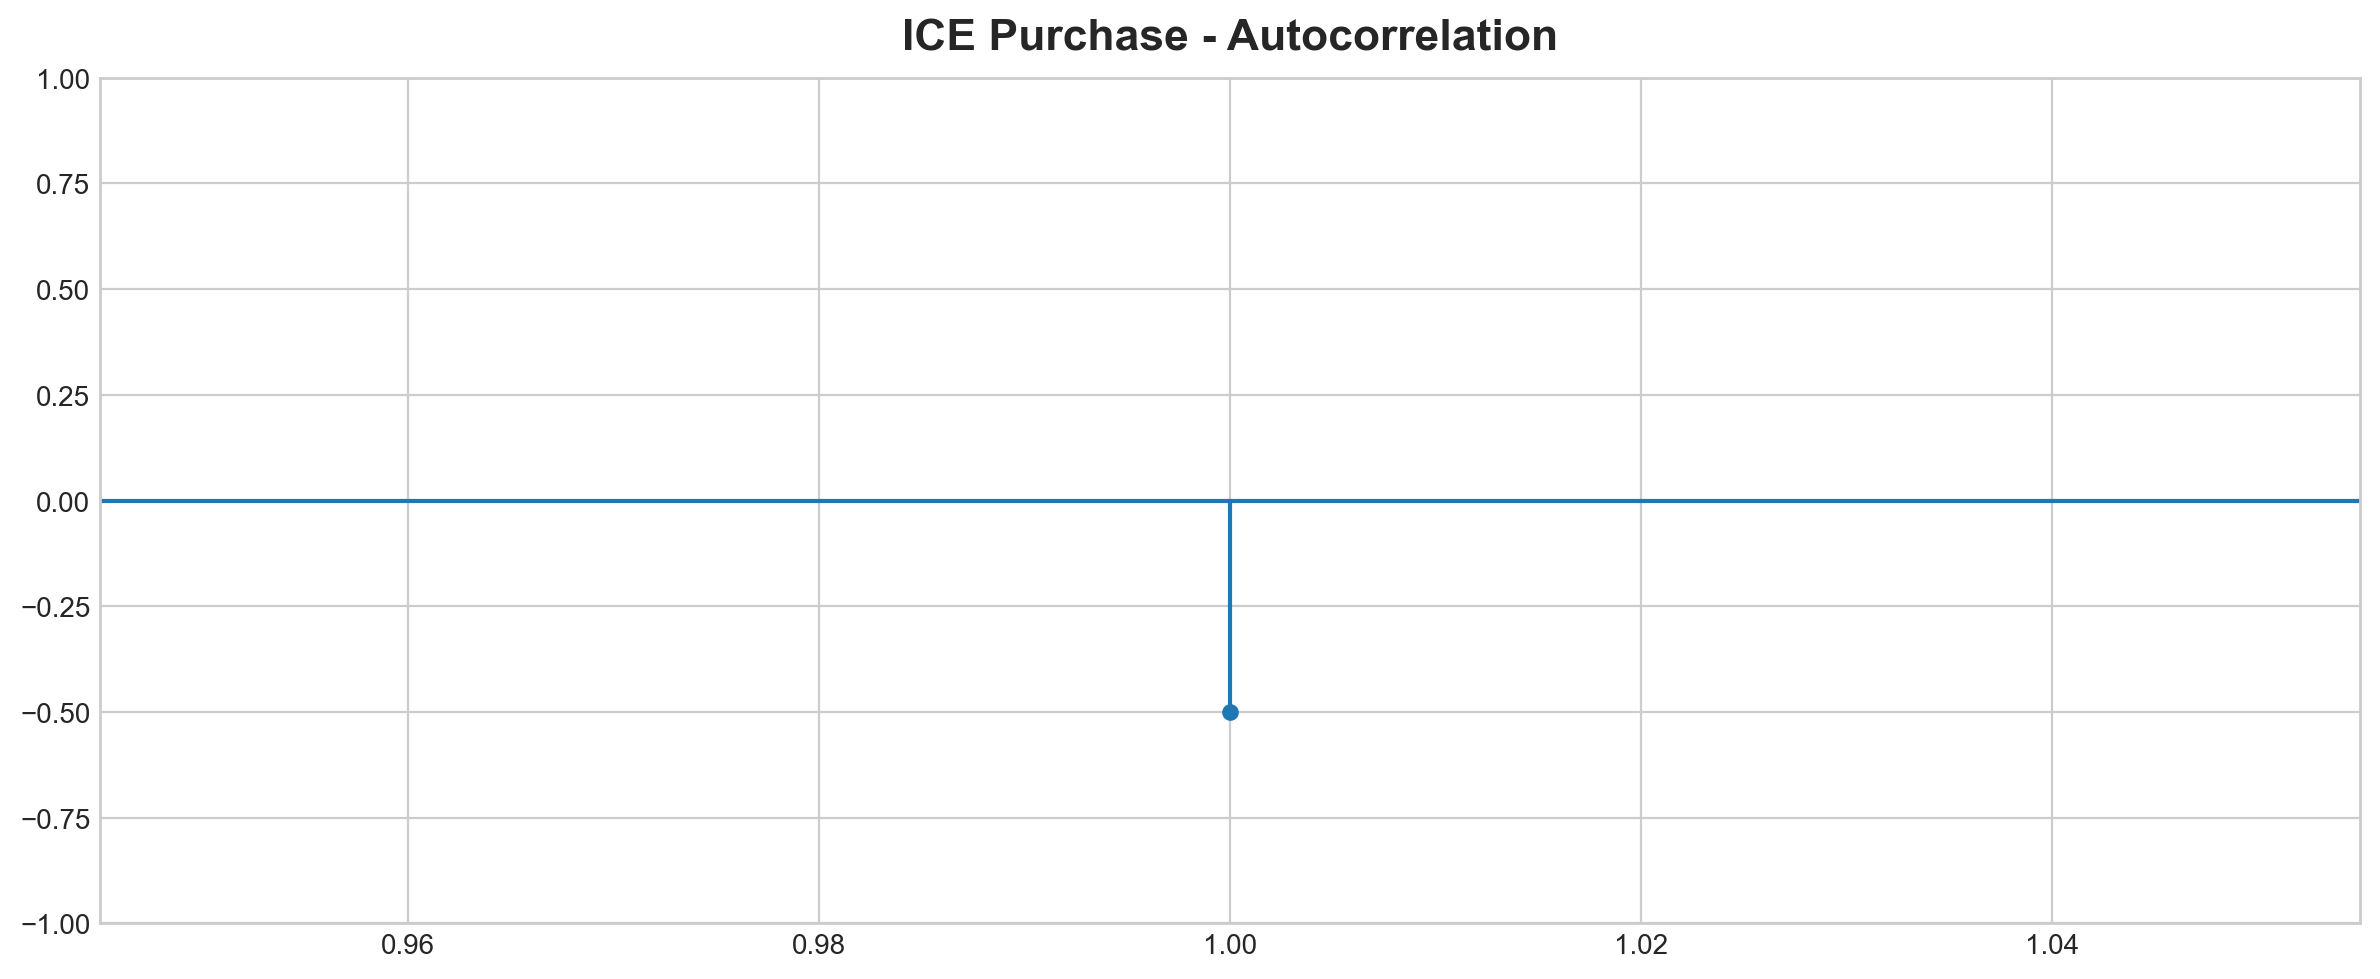

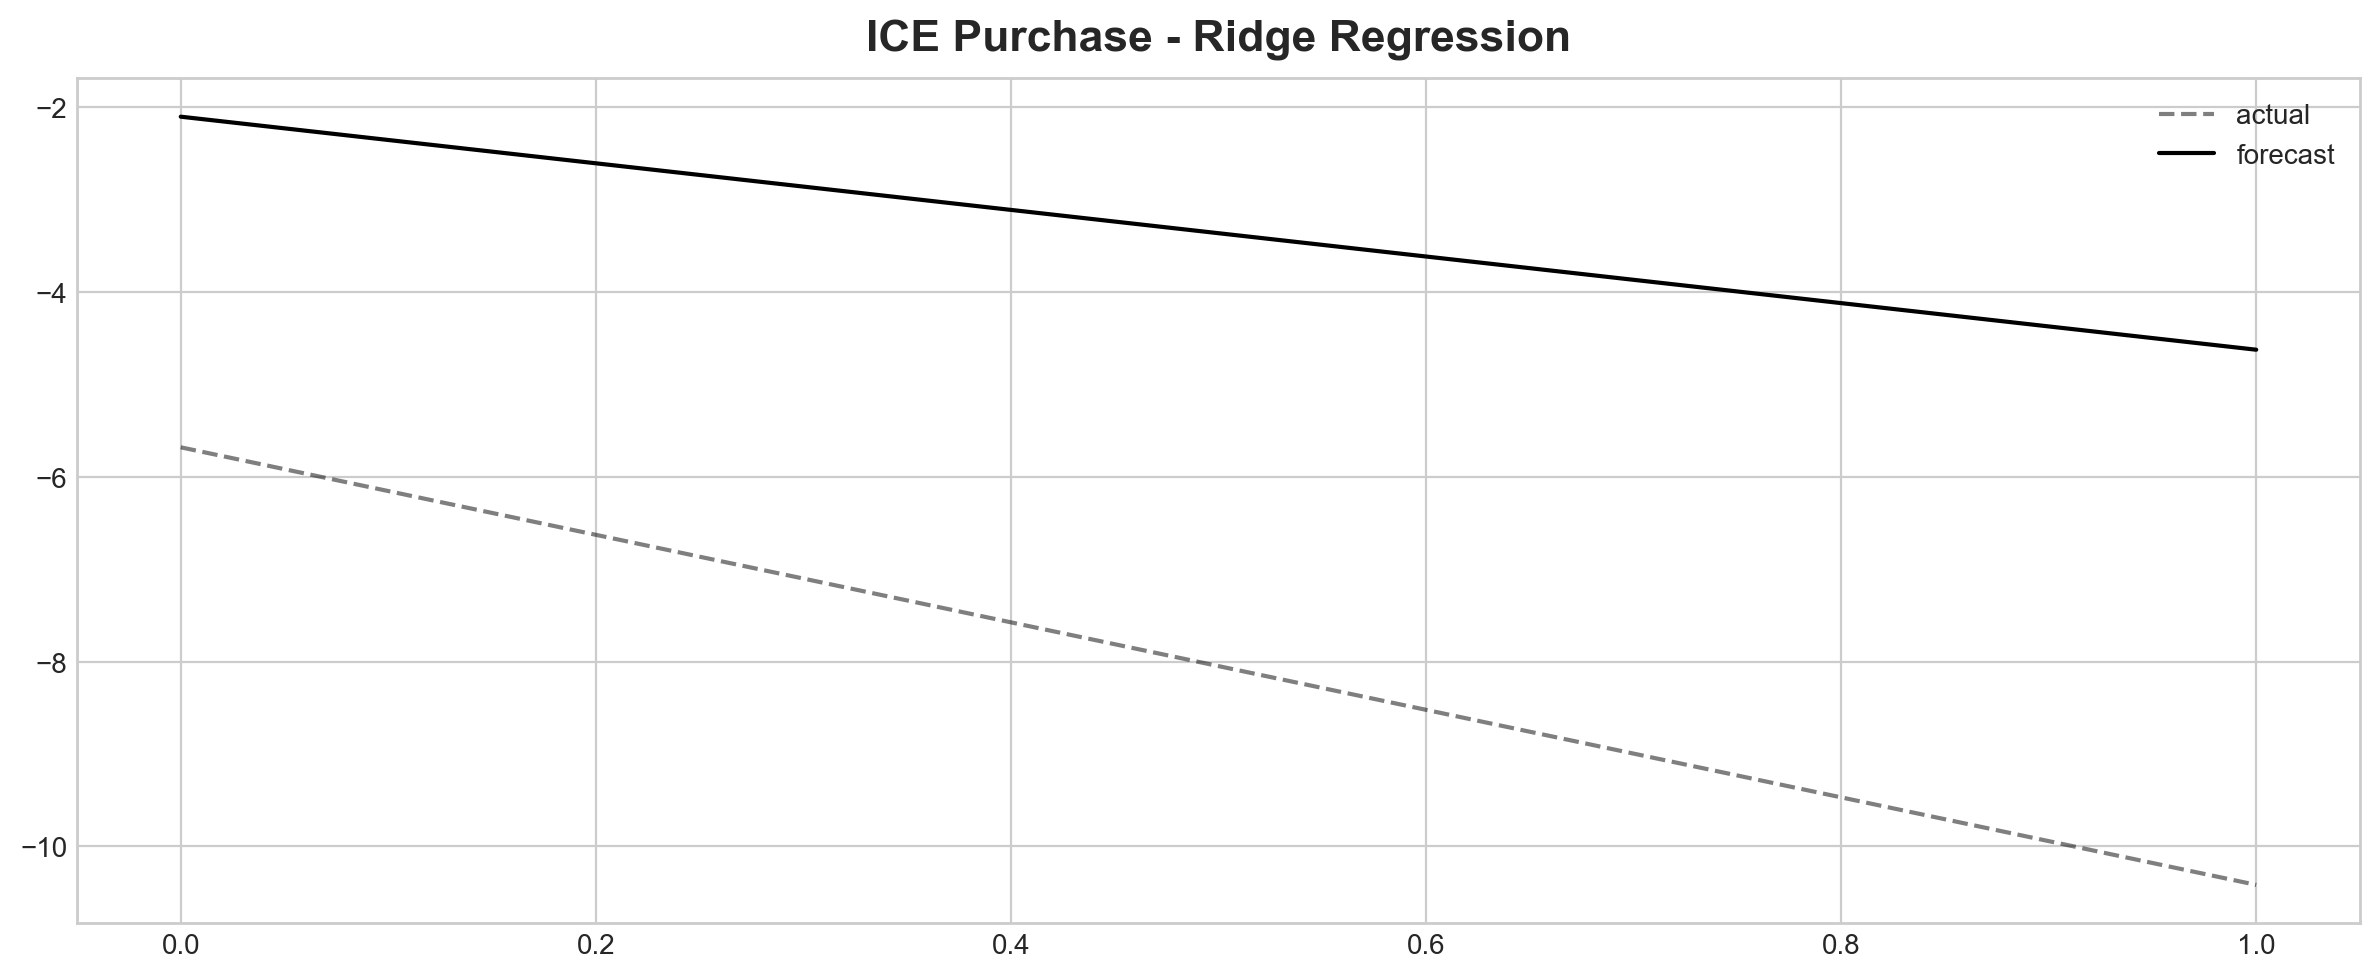

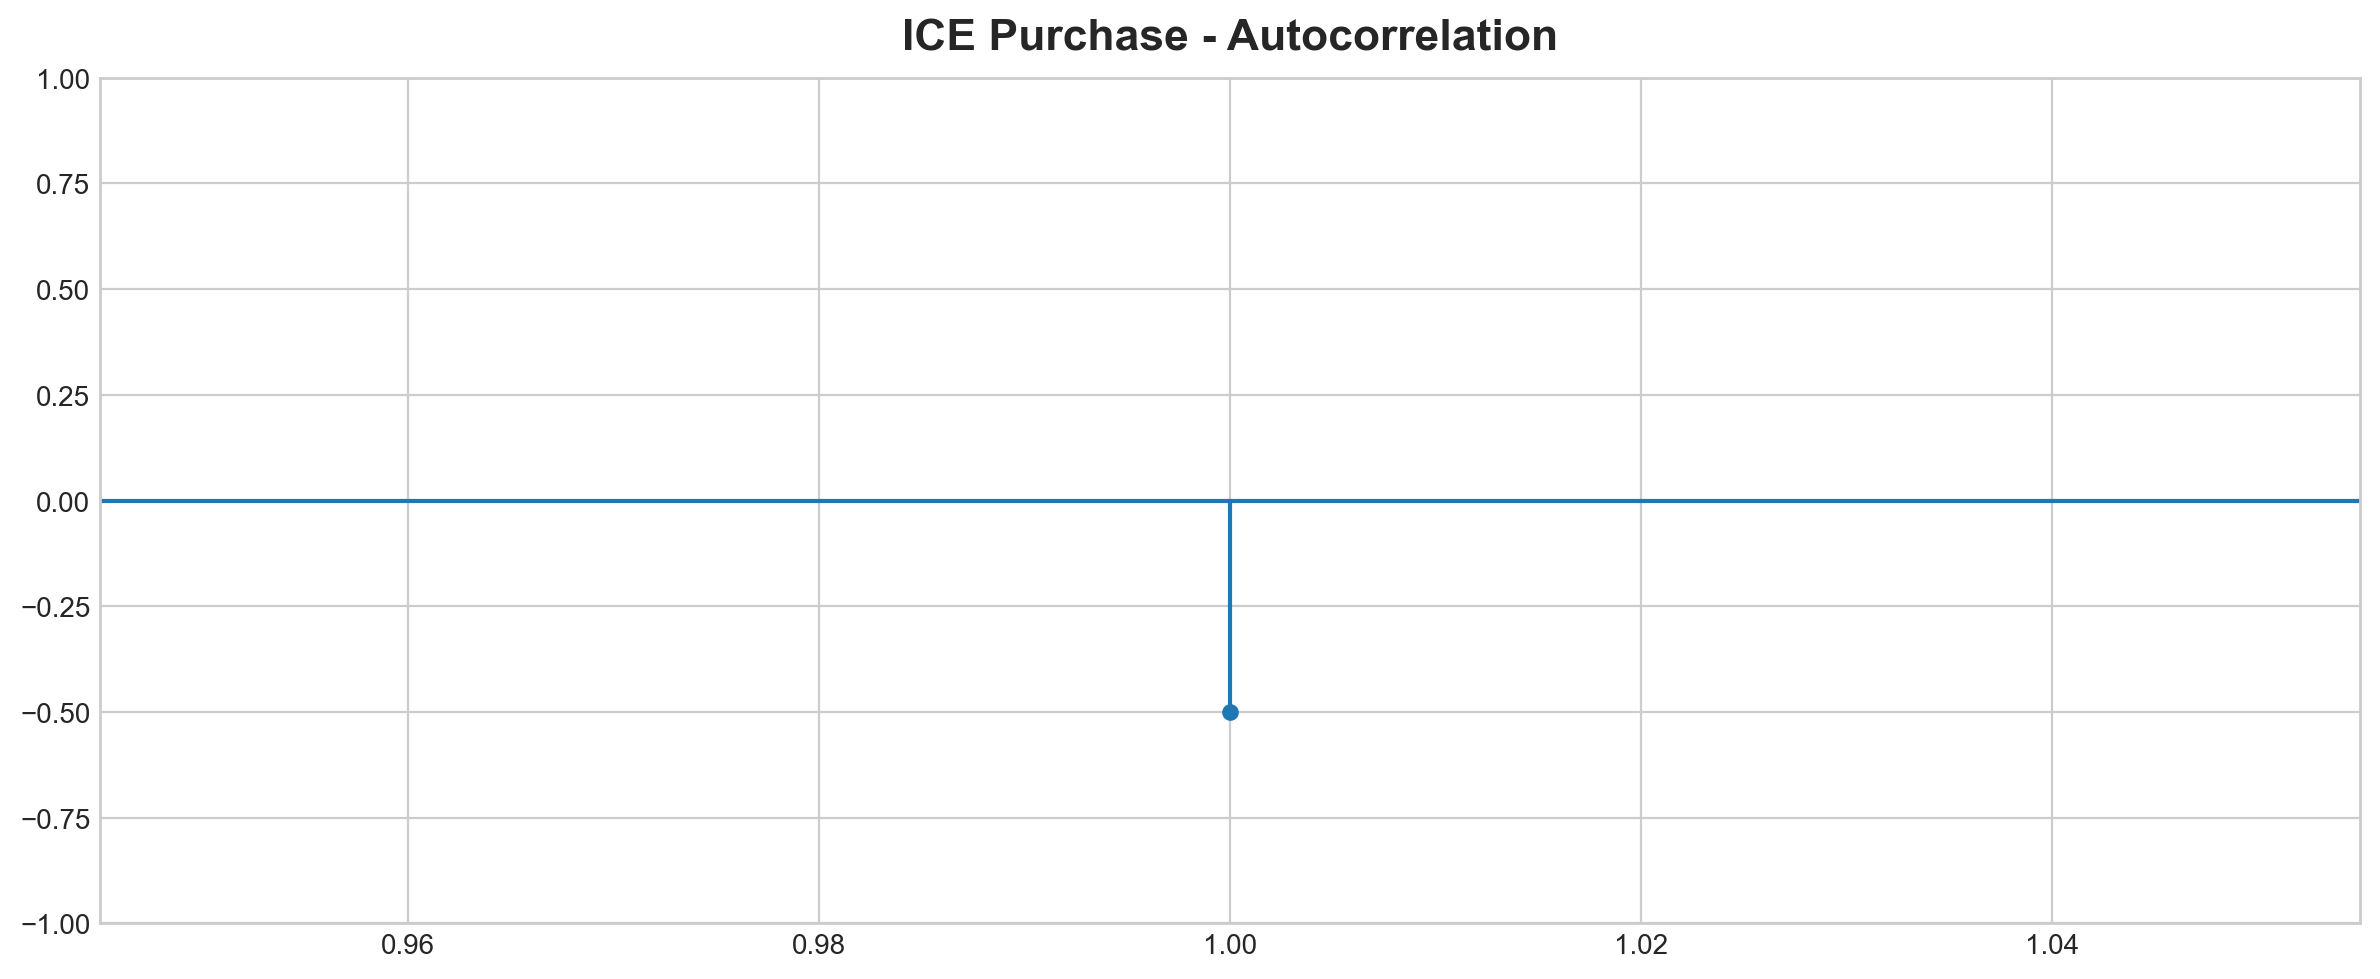

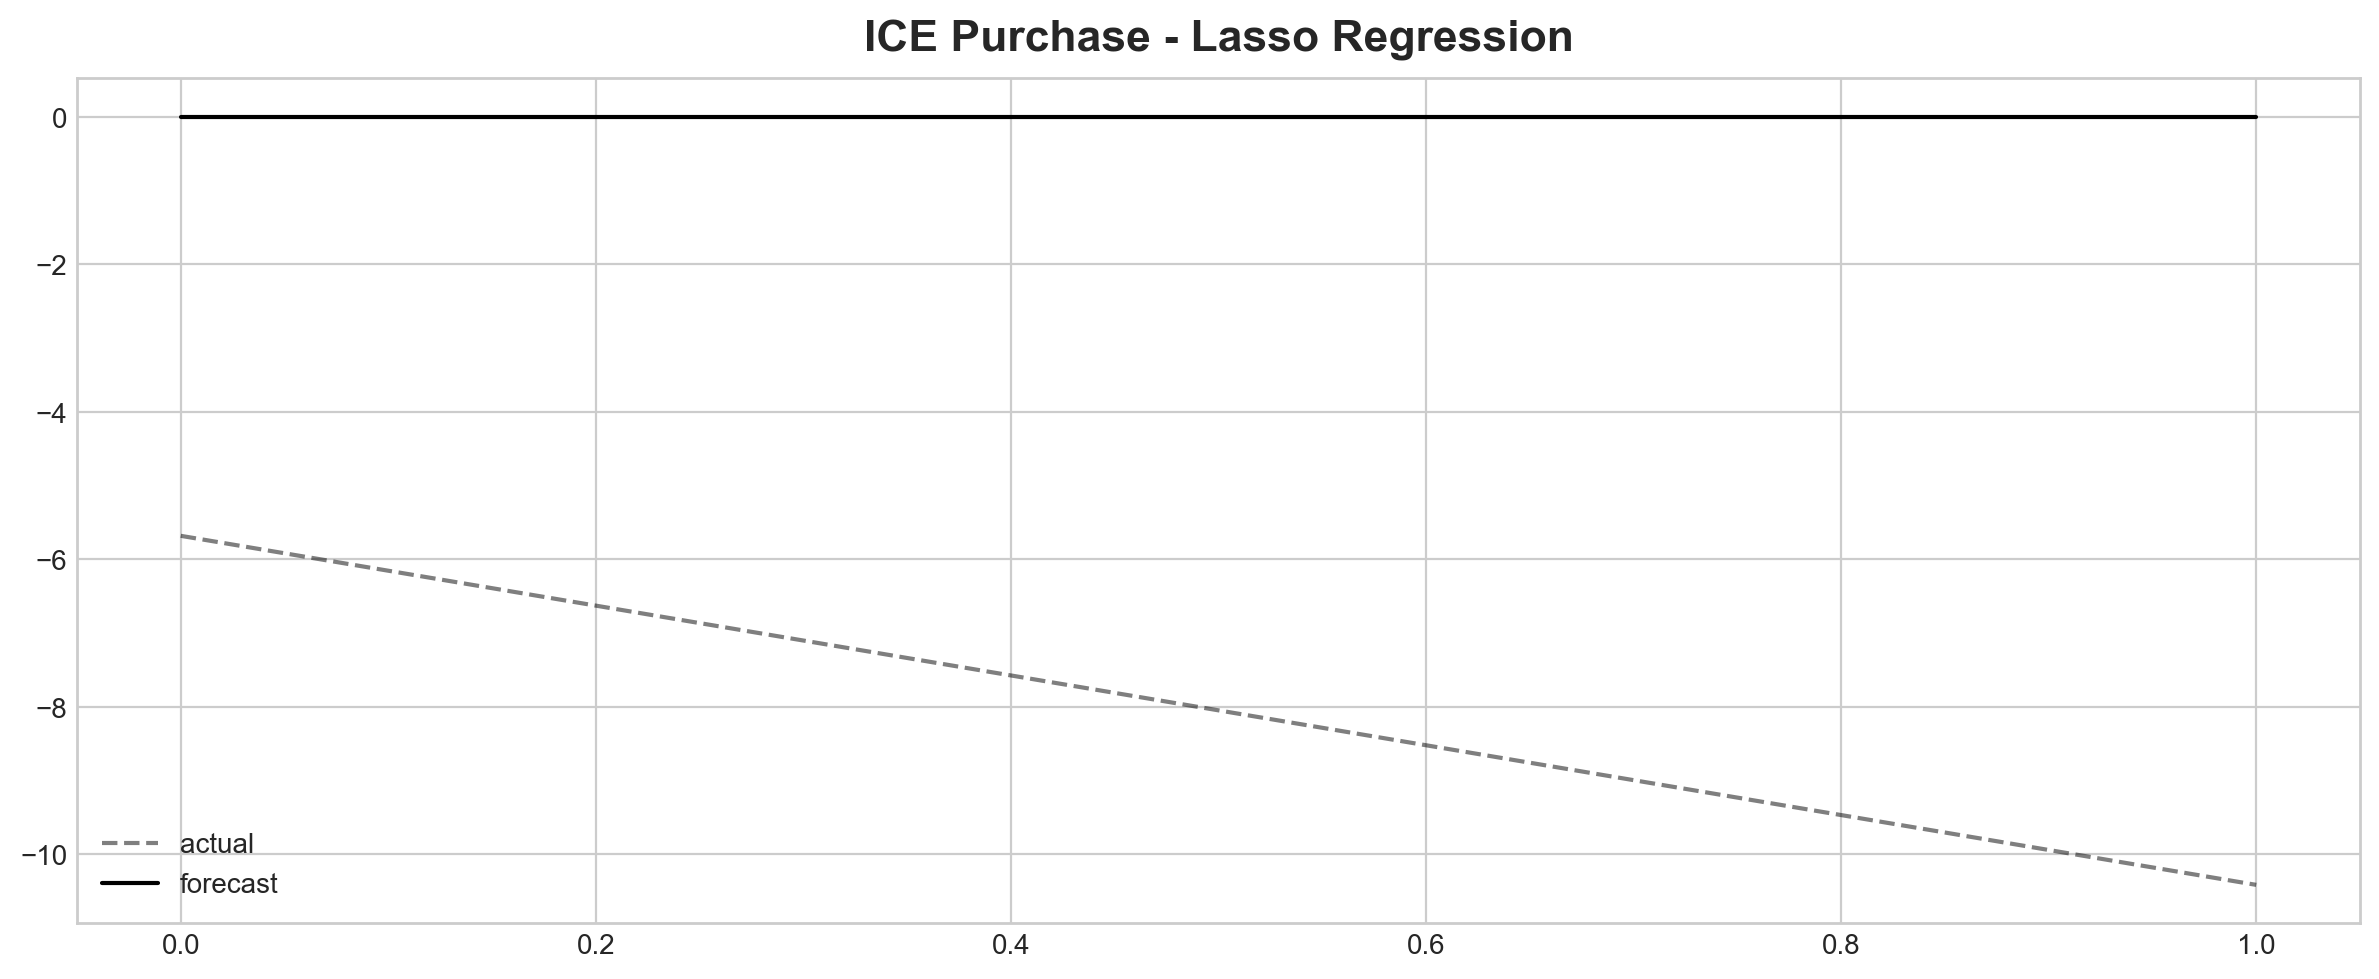

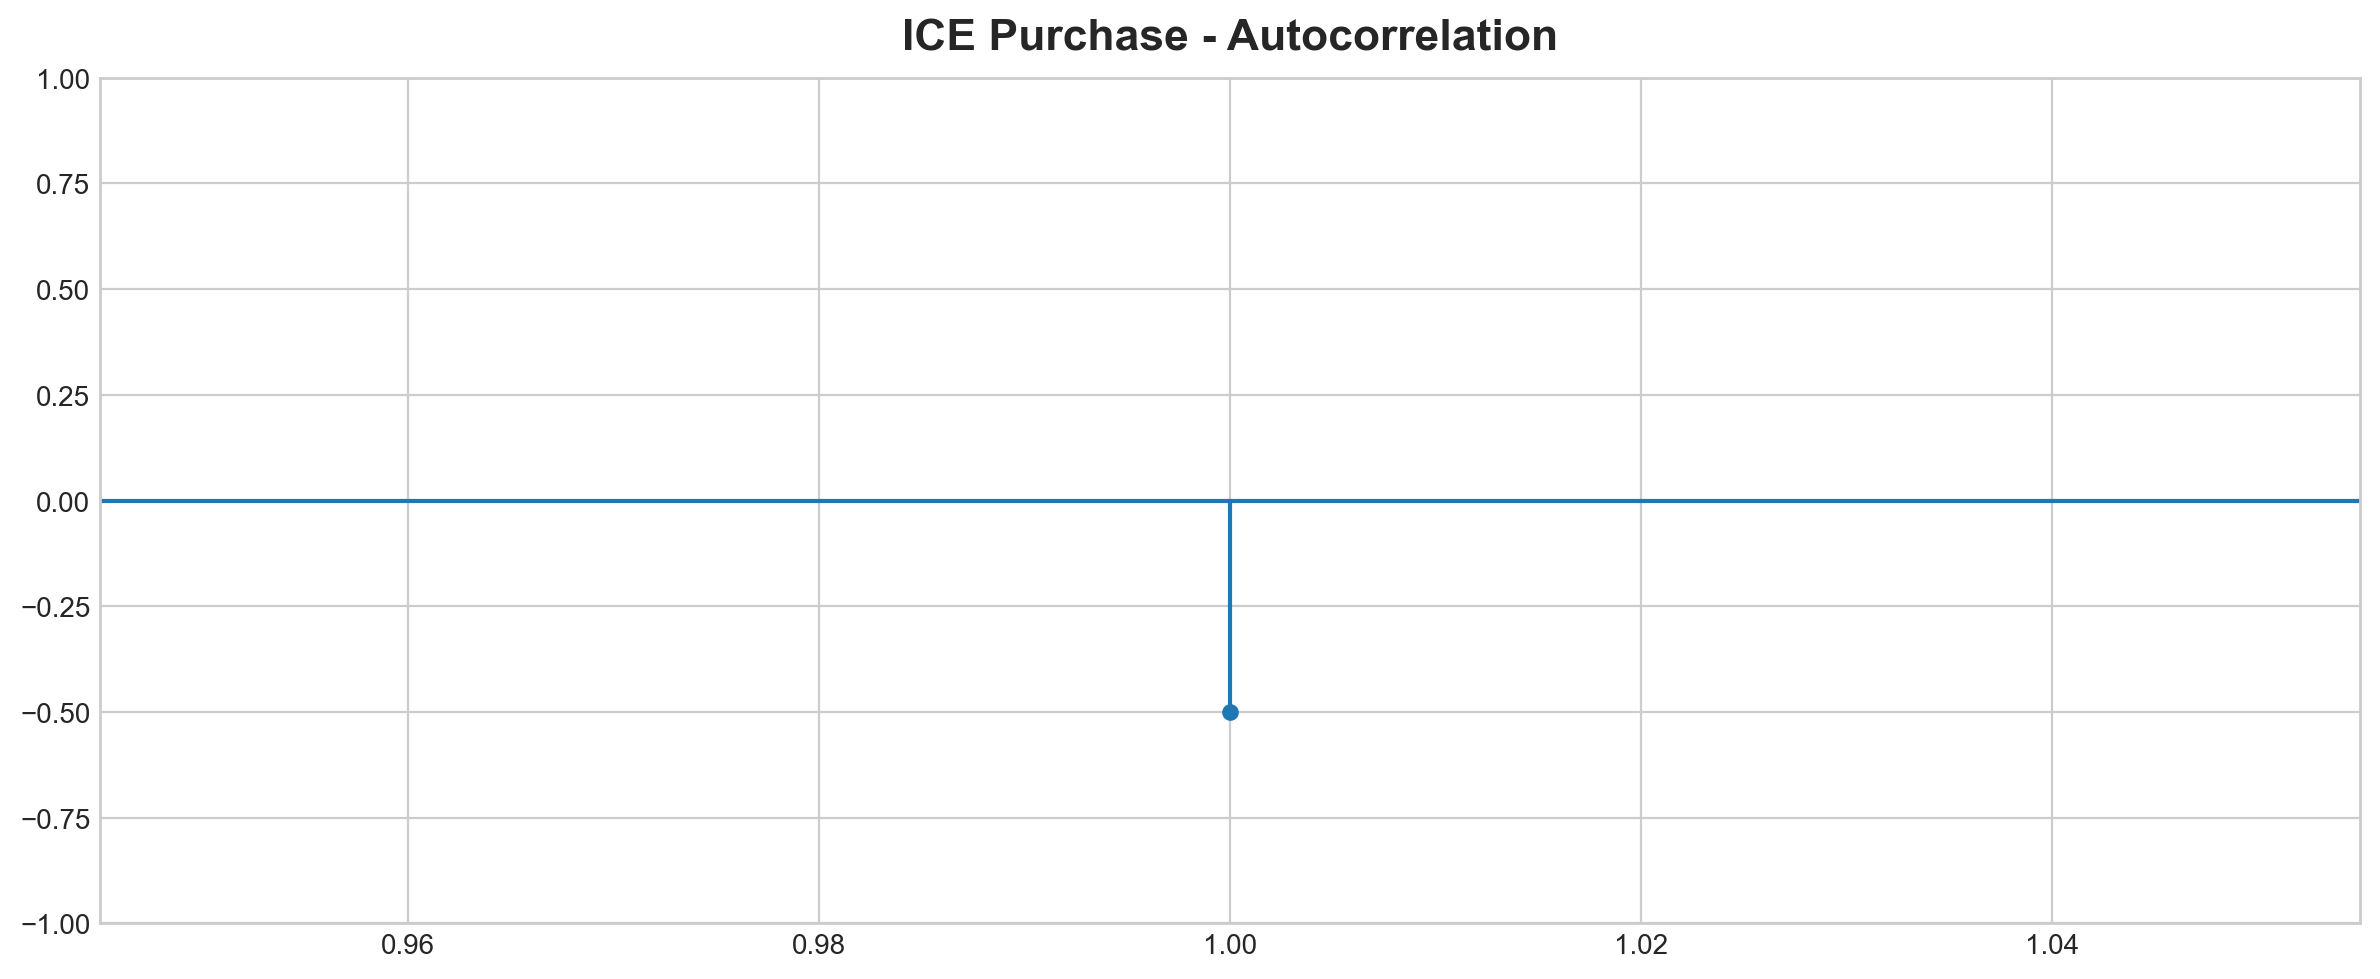

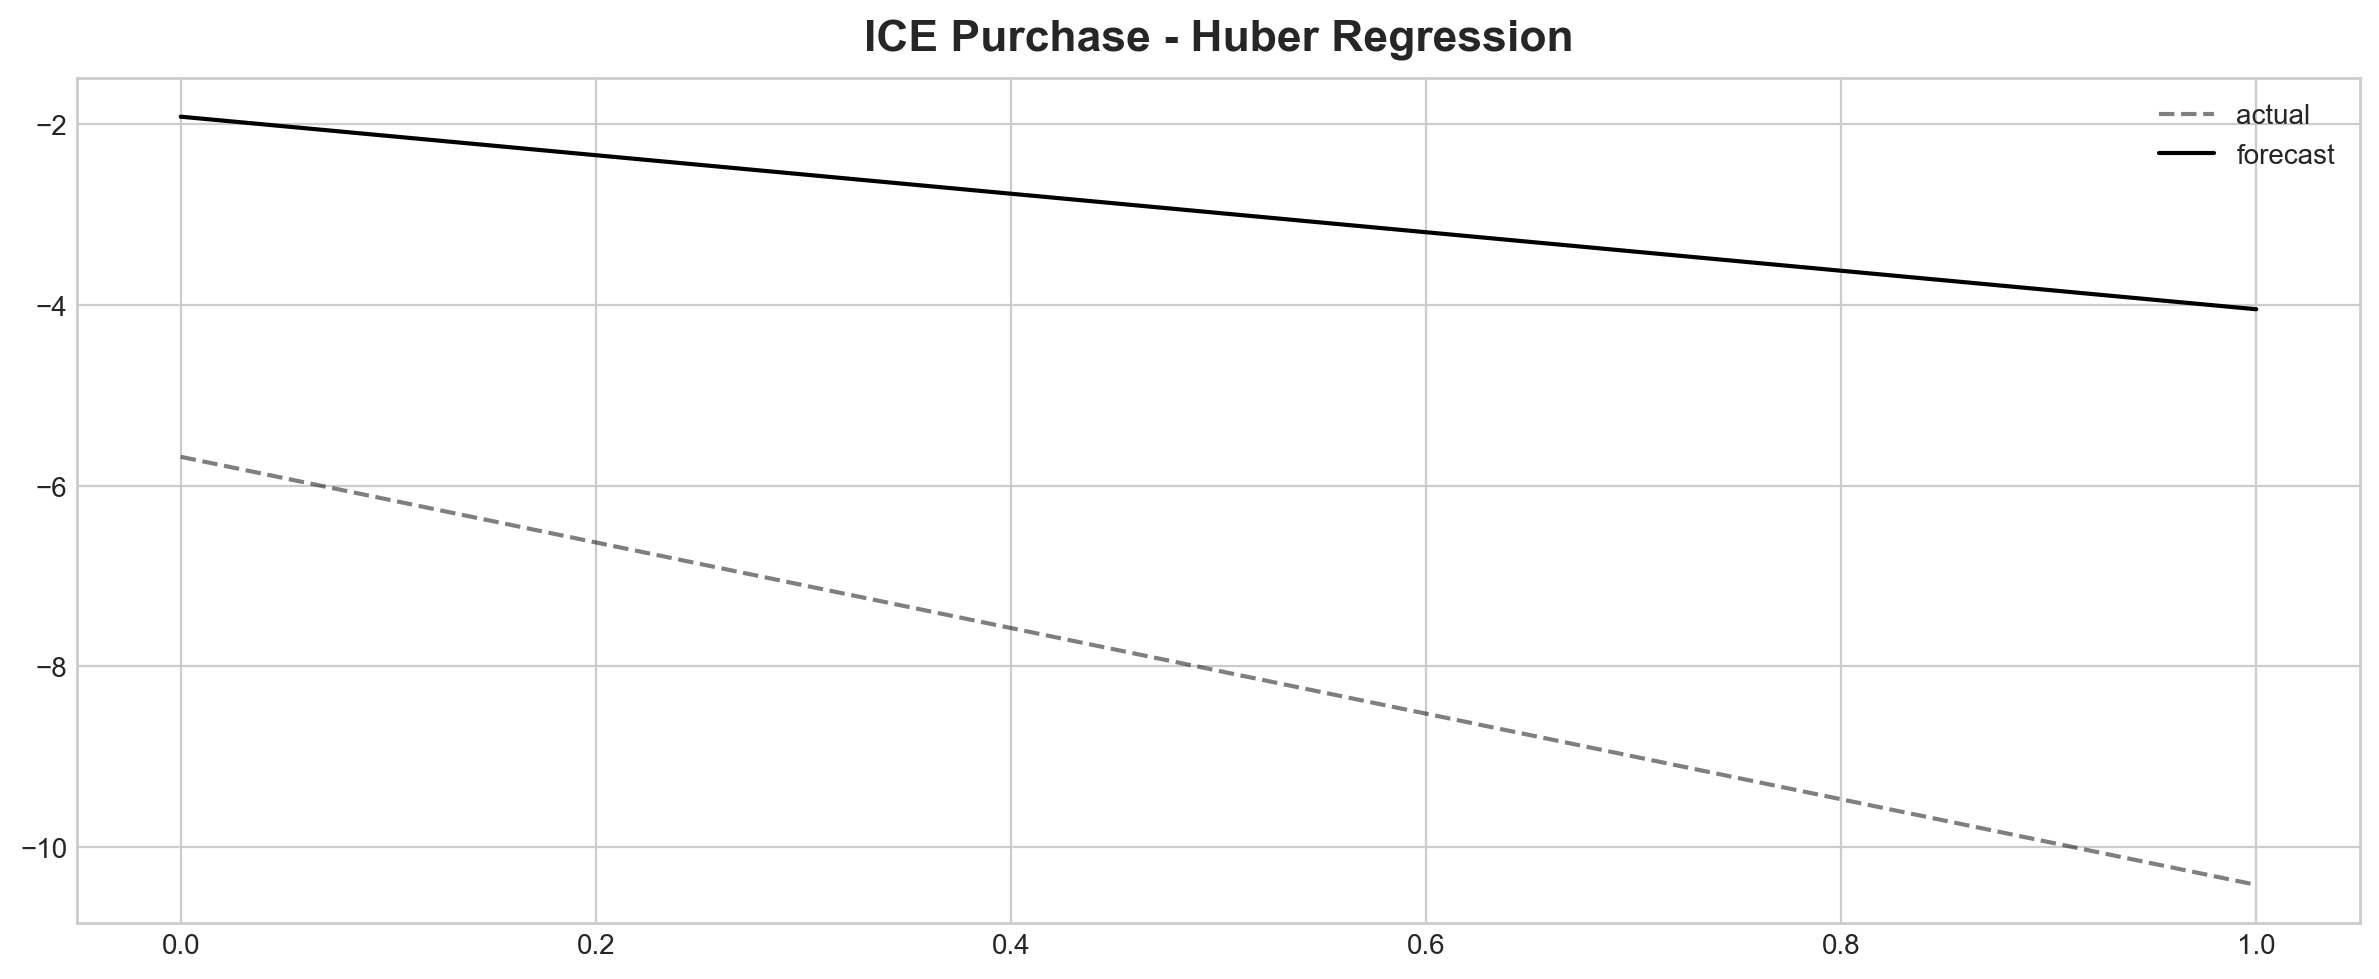

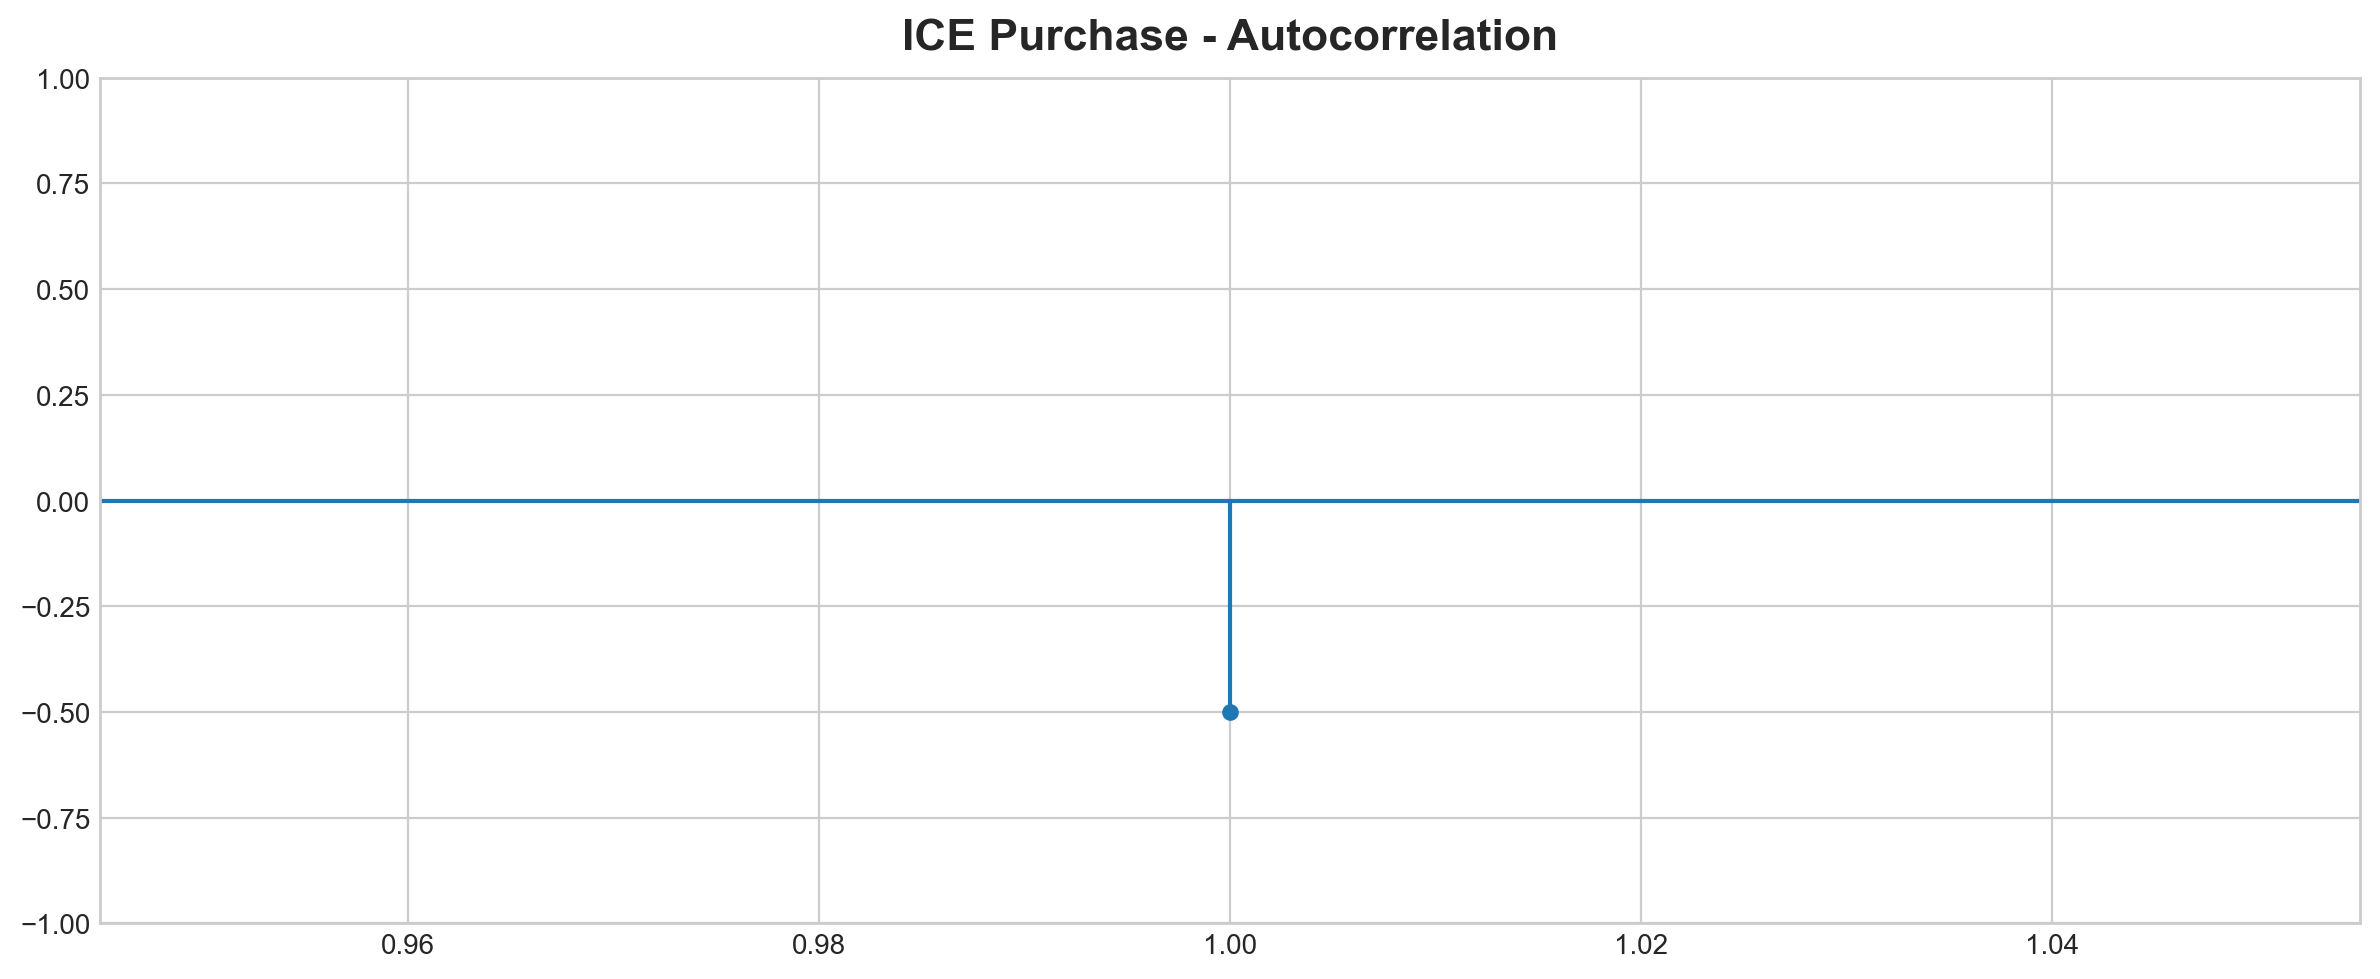

In [58]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, ice_results, 'ICE Purchase')

In [59]:
cols = ['Model Name', 'Model']
en_models = ice_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[0.74086639 0.39038234 0.56285178]
Elastic Net
[0.0233796 0.        0.       ]
Ridge Regression
[0.60037231 0.33635187 0.44354407]
Lasso Regression
[0. 0. 0.]


Recursive multi-step forecasting

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [61]:
ice_copy4 = ice.copy()
ice_copy4

,year,count
0,2011,4070
1,2012,4136
2,2013,4174
3,2014,4069
4,2015,4093
5,2016,4121
6,2017,4071
7,2018,4067
8,2019,3988
9,2020,3816


In [62]:
ice_copy4.rename(columns={"count": "y"}, inplace=True)

In [63]:
ice_copy4 = ice_copy4.set_index("year")
ice_copy4

,y
year,
2011,4070
2012,4136
2013,4174
2014,4069
2015,4093
2016,4121
2017,4071
2018,4067
2019,3988


In [64]:
ice_copy4 = ice_copy4['y']

In [65]:
steps = 2
data_train = ice_copy4[:-steps]
data_test  = ice_copy4[-steps:]

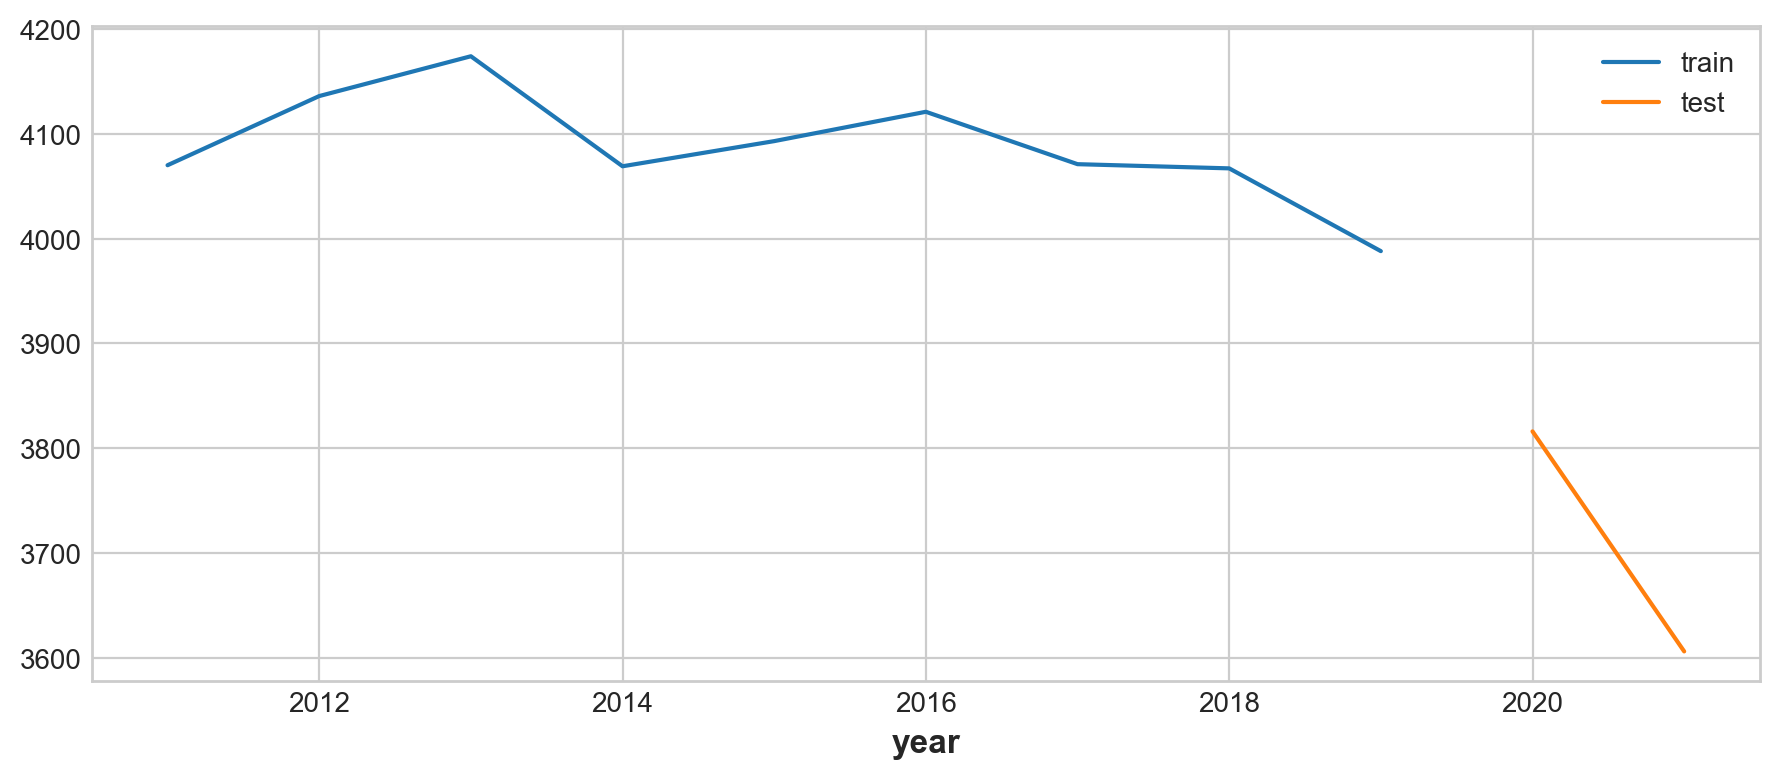

In [66]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [67]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-10 15:59:14 
Last fit date: 2023-02-10 15:59:14 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [68]:
predictions = forecaster.predict(steps=2)
predictions.head()

8    3988.0
9    3988.0
Name: pred, dtype: float64

In [69]:
predictions.index = [2020,2021]

In [70]:
data_train

year
2011    4070
2012    4136
2013    4174
2014    4069
2015    4093
2016    4121
2017    4071
2018    4067
2019    3988
Name: y, dtype: int64

In [71]:
ahead_predictions = forecaster.predict(steps=7)
ahead_predictions

8     3988.0
9     3988.0
10    3988.0
11    3988.0
12    3988.0
13    3988.0
14    3988.0
Name: pred, dtype: float64

In [72]:
ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]

In [73]:
ahead_predictions

2020    3988.0
2021    3988.0
2022    3988.0
2023    3988.0
2024    3988.0
2025    3988.0
2026    3988.0
Name: pred, dtype: float64

In [74]:
ahead_predictions.drop([2020,2021],axis=0,inplace=True)

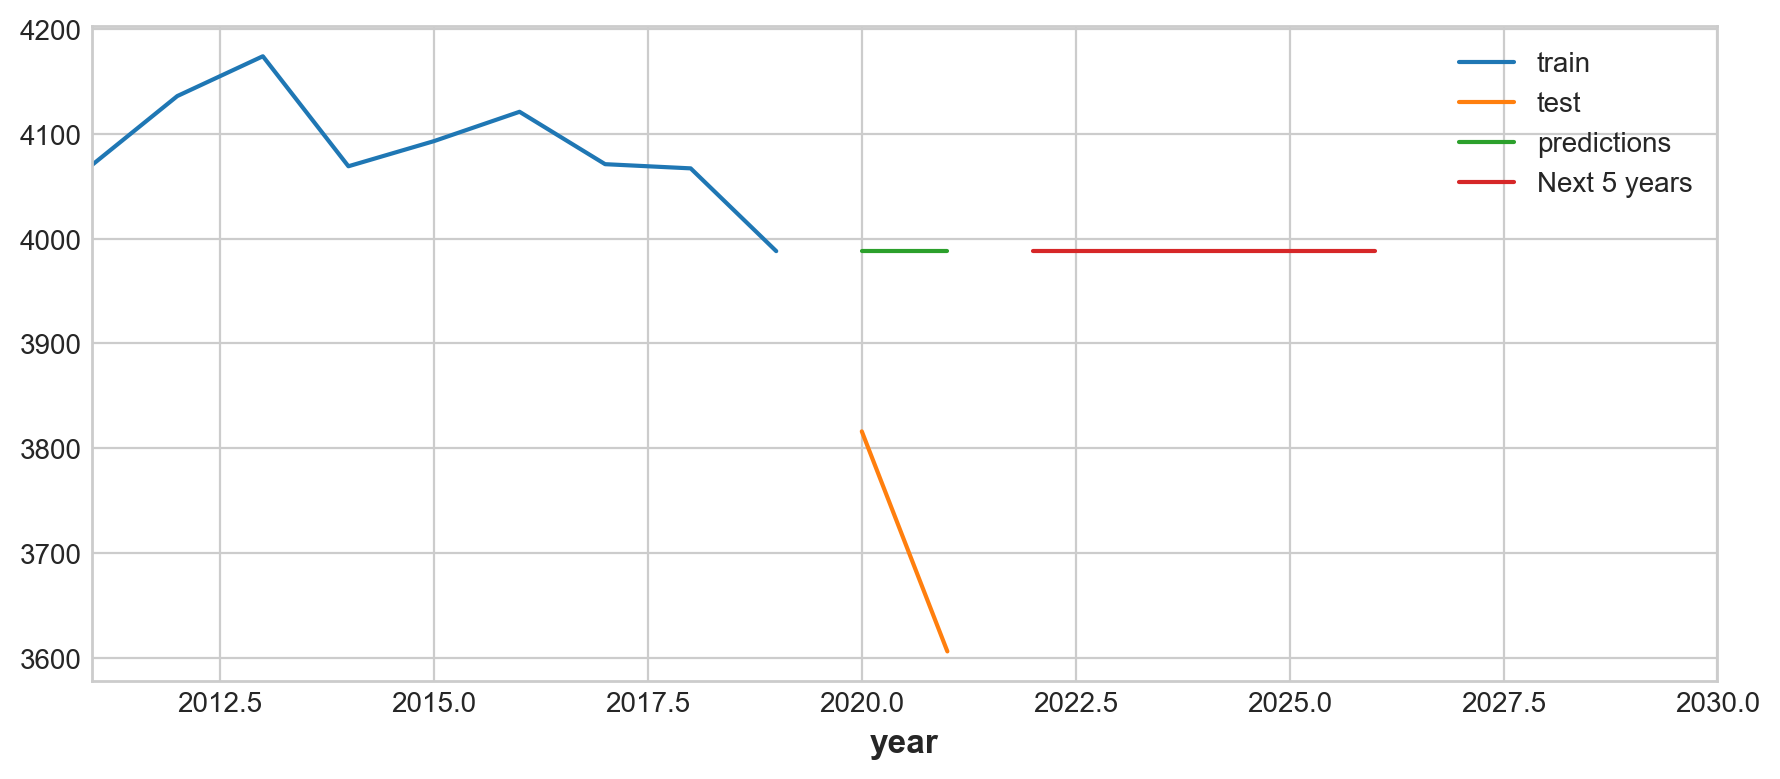

In [75]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

XGBOOST

In [76]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [77]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(),
                 lags = 8
             )

forecaster.fit(y=data_train,)
forecaster

[15:59:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ForecasterAutoreg 
Regressor: XGBRegressor() 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} 
Creation date: 2023-02-10 15:59:16 
Last fit date: 2023-02-10 15:59:16 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [78]:
predictions= forecaster.predict(steps=2,)
predictions

8    3964.391602
9    3964.391602
Name: pred, dtype: float64

In [79]:
predictions.index = [2020,2021]

In [80]:
ahead_predictions = forecaster.predict(steps=7,)

ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]
ahead_predictions.drop([2020,2021],axis=0,inplace=True)


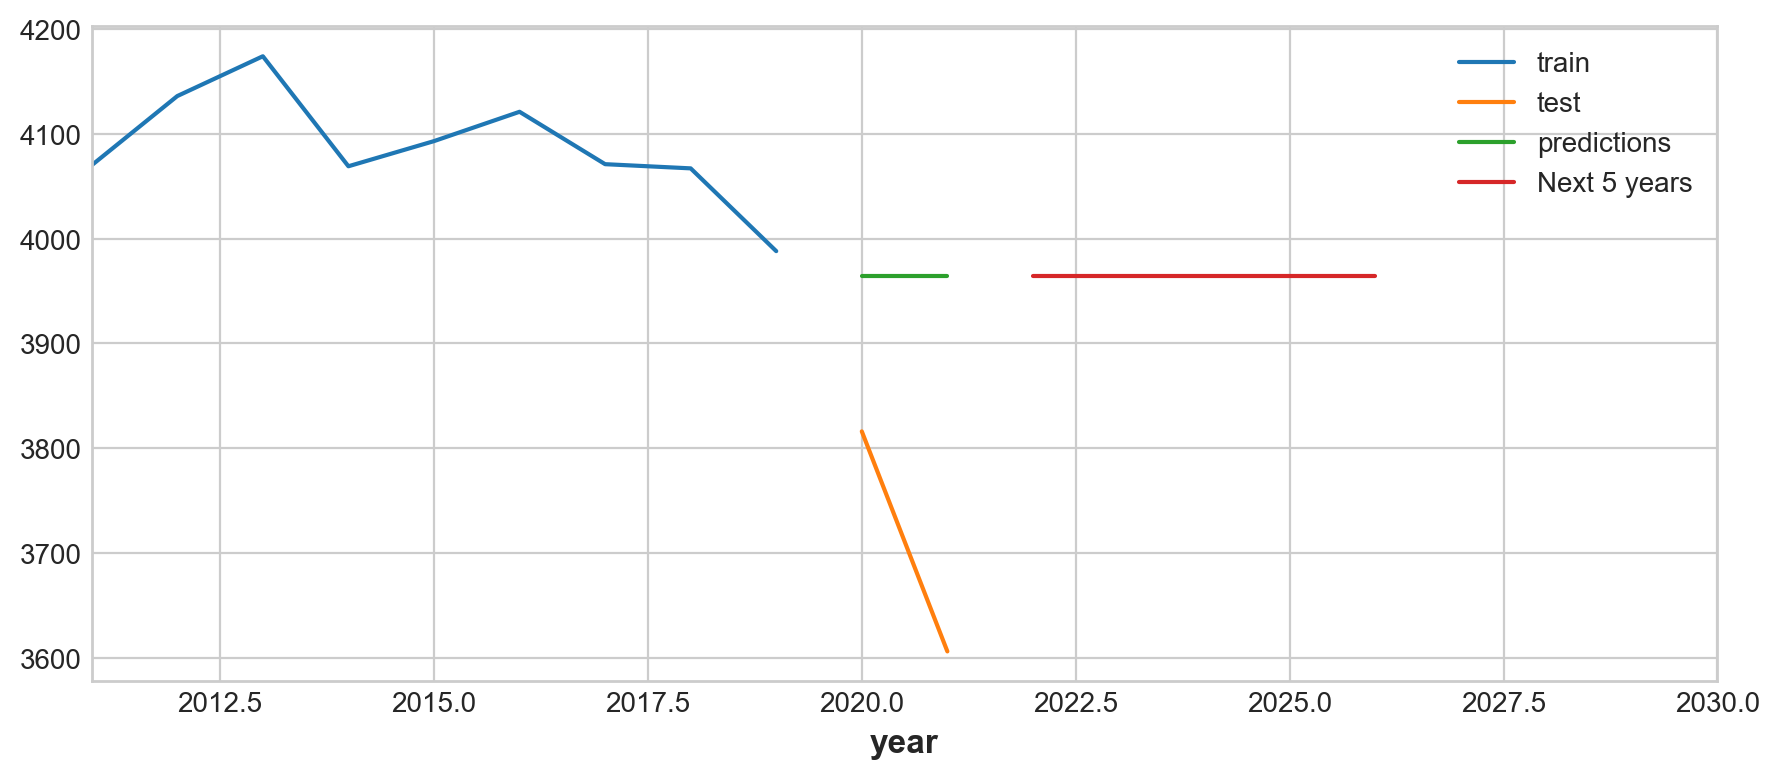

In [81]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

# **EV**

In [82]:
ev = data.query('carType == "EV"').groupby(["year"], as_index=False).count()
ev.rename(columns={"carType": "count"}, inplace=True)
ev

,year,count
0,2011,25
1,2012,44
2,2013,64
3,2014,80
4,2015,86
5,2016,114
6,2017,127
7,2018,134
8,2019,203
9,2020,436


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

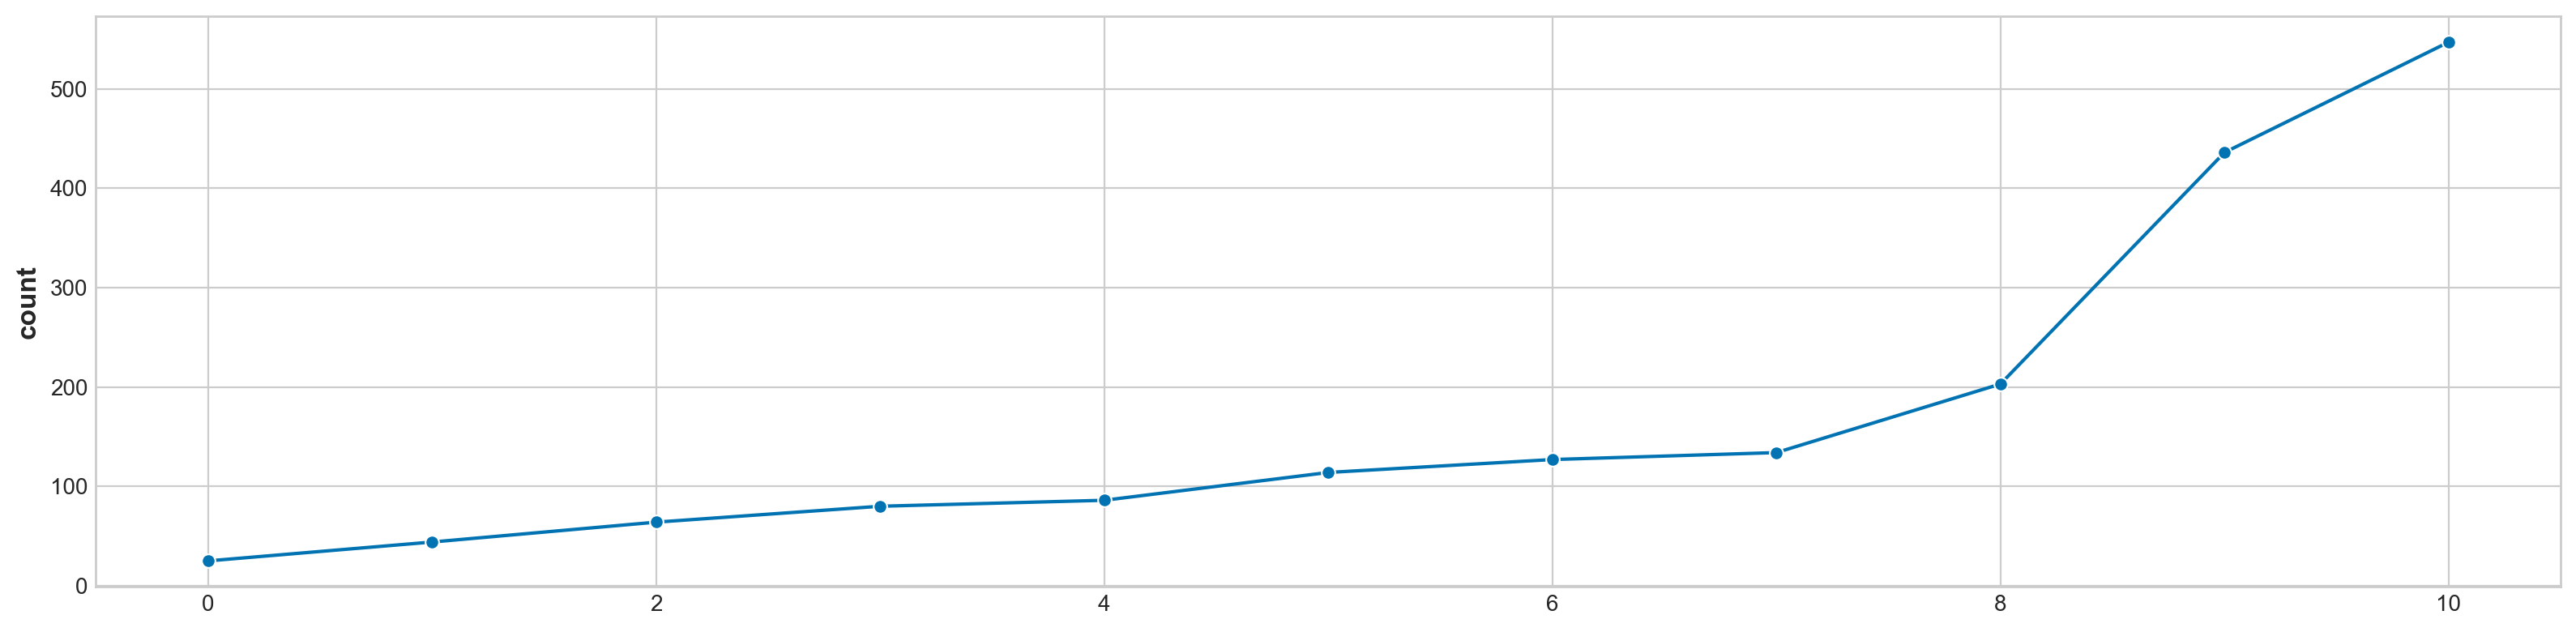

In [83]:
plot_series(ev["count"])

Text(0.5, 1.0, 'Time Plot of EV Car Sales')

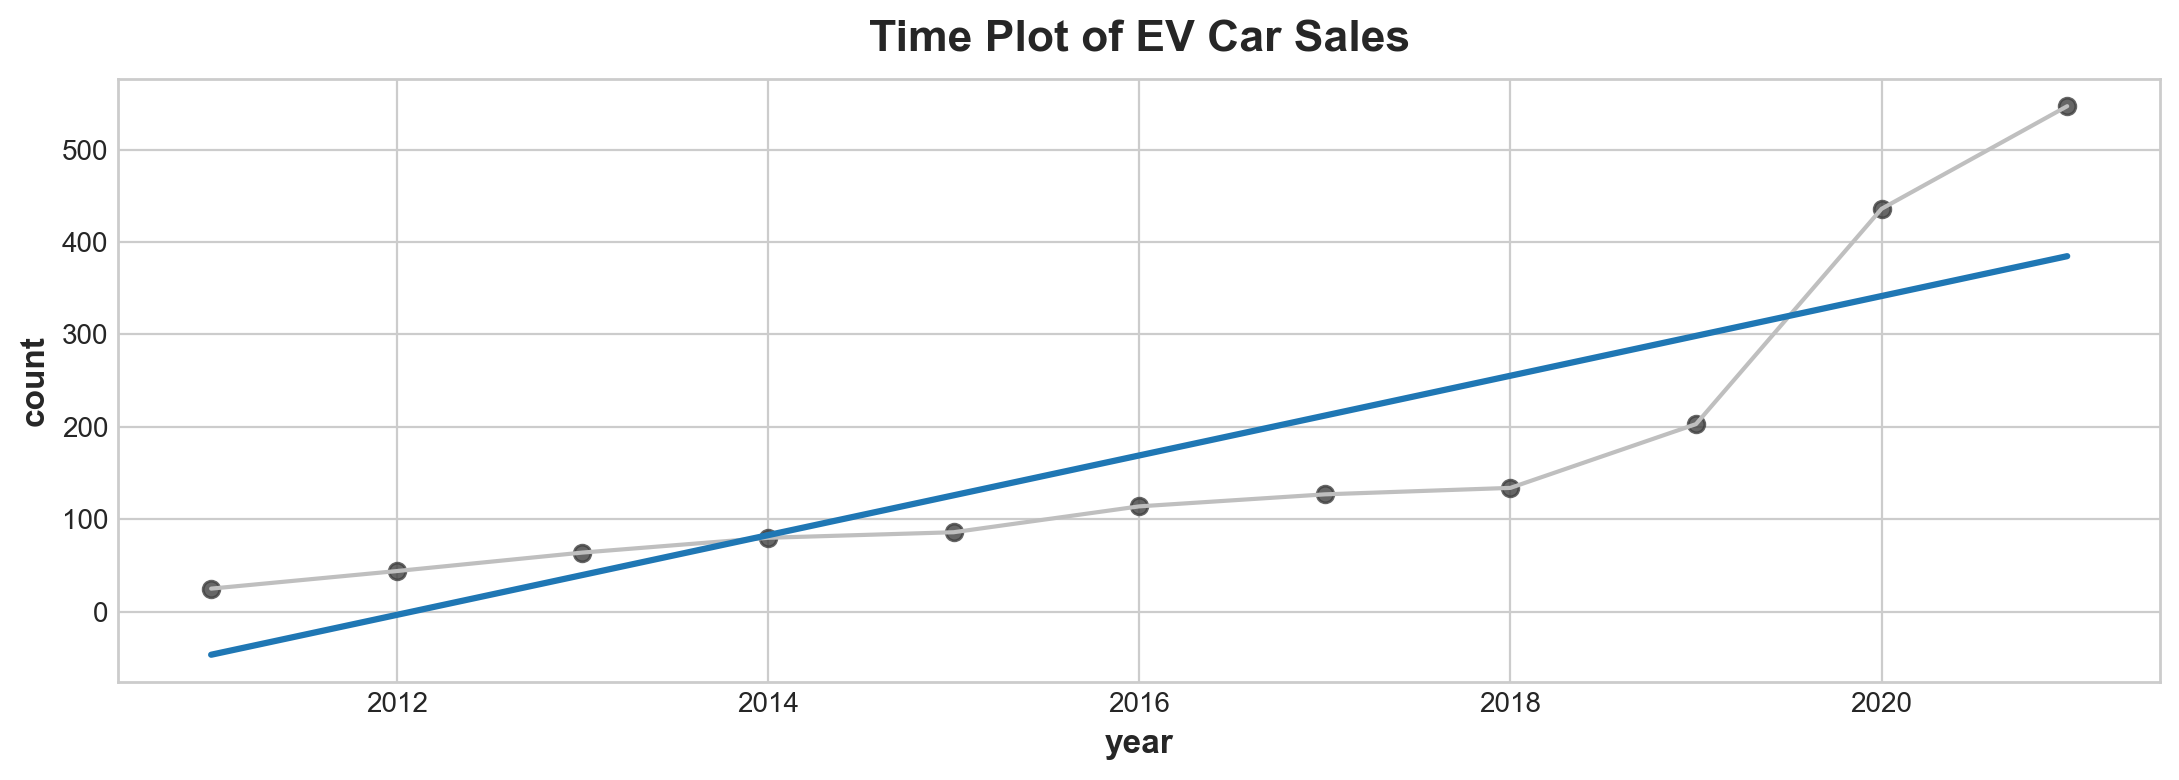

In [84]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('year', 'count', data=ev, color='0.75')
ax = sns.regplot(x='year', y='count', data=ev, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of EV Car Sales')

## LAG Feature

In [85]:
ev_copy1 = ev.copy()


ev_copy1['Lag_1'] = ev_copy1['count'].shift(1)
df = ev_copy1.reindex(columns=['count', 'Lag_1'])

df.head()

,count,Lag_1
0,25,NaN
1,44,25.0
2,64,44.0
3,80,64.0
4,86,80.0


In [86]:
ev_copy1.head()

,year,count,Lag_1
0,2011,25,NaN
1,2012,44,25.0
2,2013,64,44.0
3,2014,80,64.0
4,2015,86,80.0


Text(0.5, 1.0, 'Lag Plot of EV Car Sales')

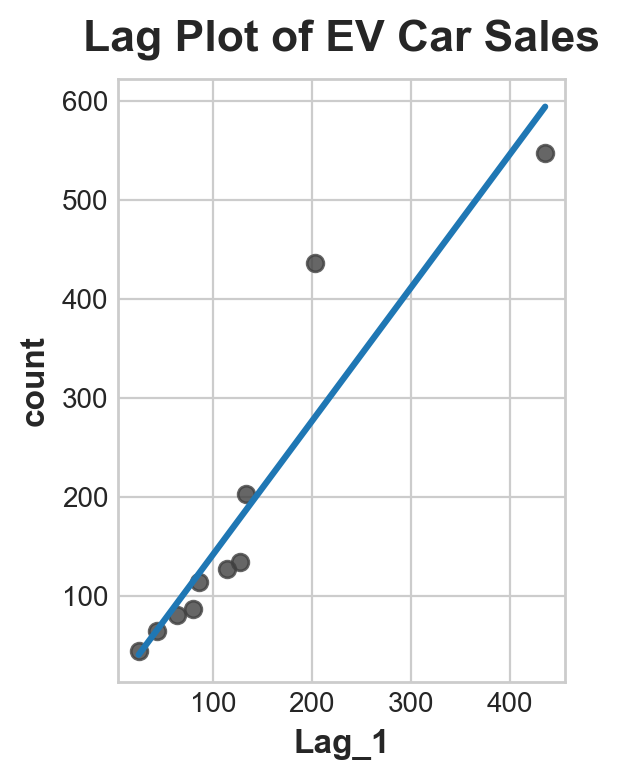

In [87]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='count', data=ev_copy1, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of EV Car Sales')

## ARIMA

In [88]:
ev_copy2 = ev.copy()

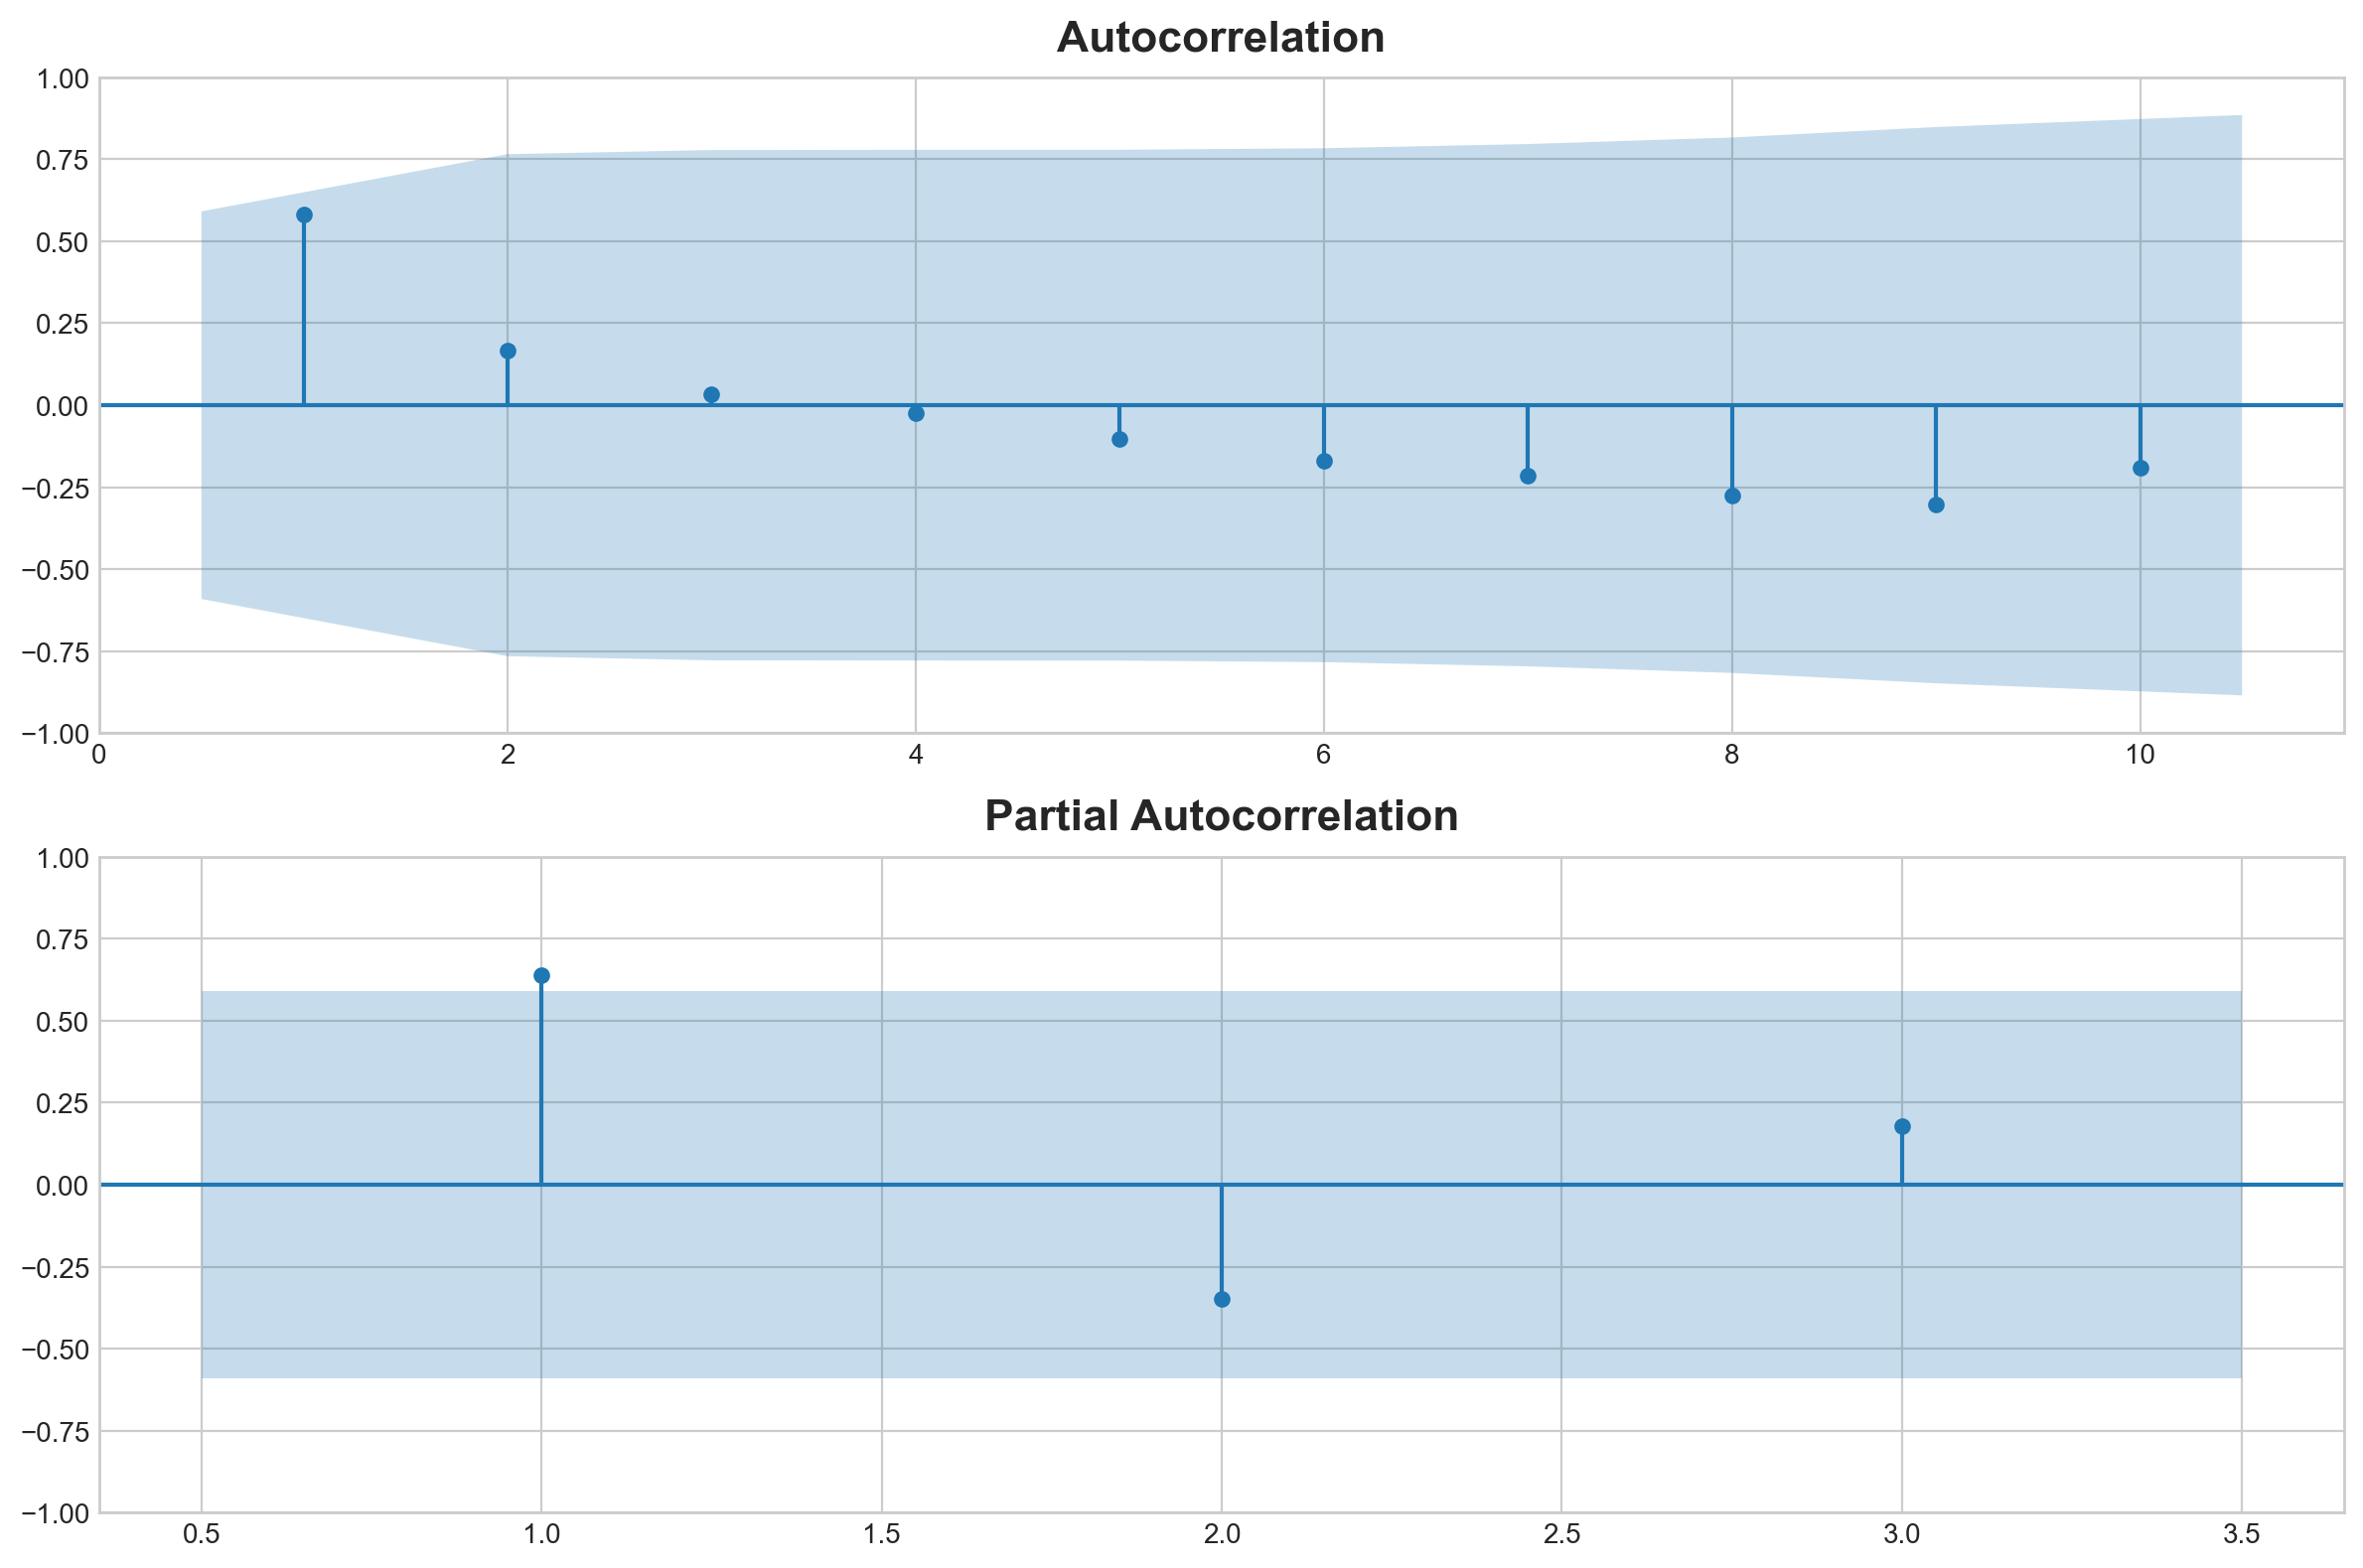

'Non-Stationary	 p-value:0.9965465948727489 	lags:2


('Non-Stationary', 0.9965465948727489)

In [89]:

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ev_copy2["count"], zero=False, ax=ax[0])
plot_pacf(ev_copy2["count"], zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ev_copy2["count"])

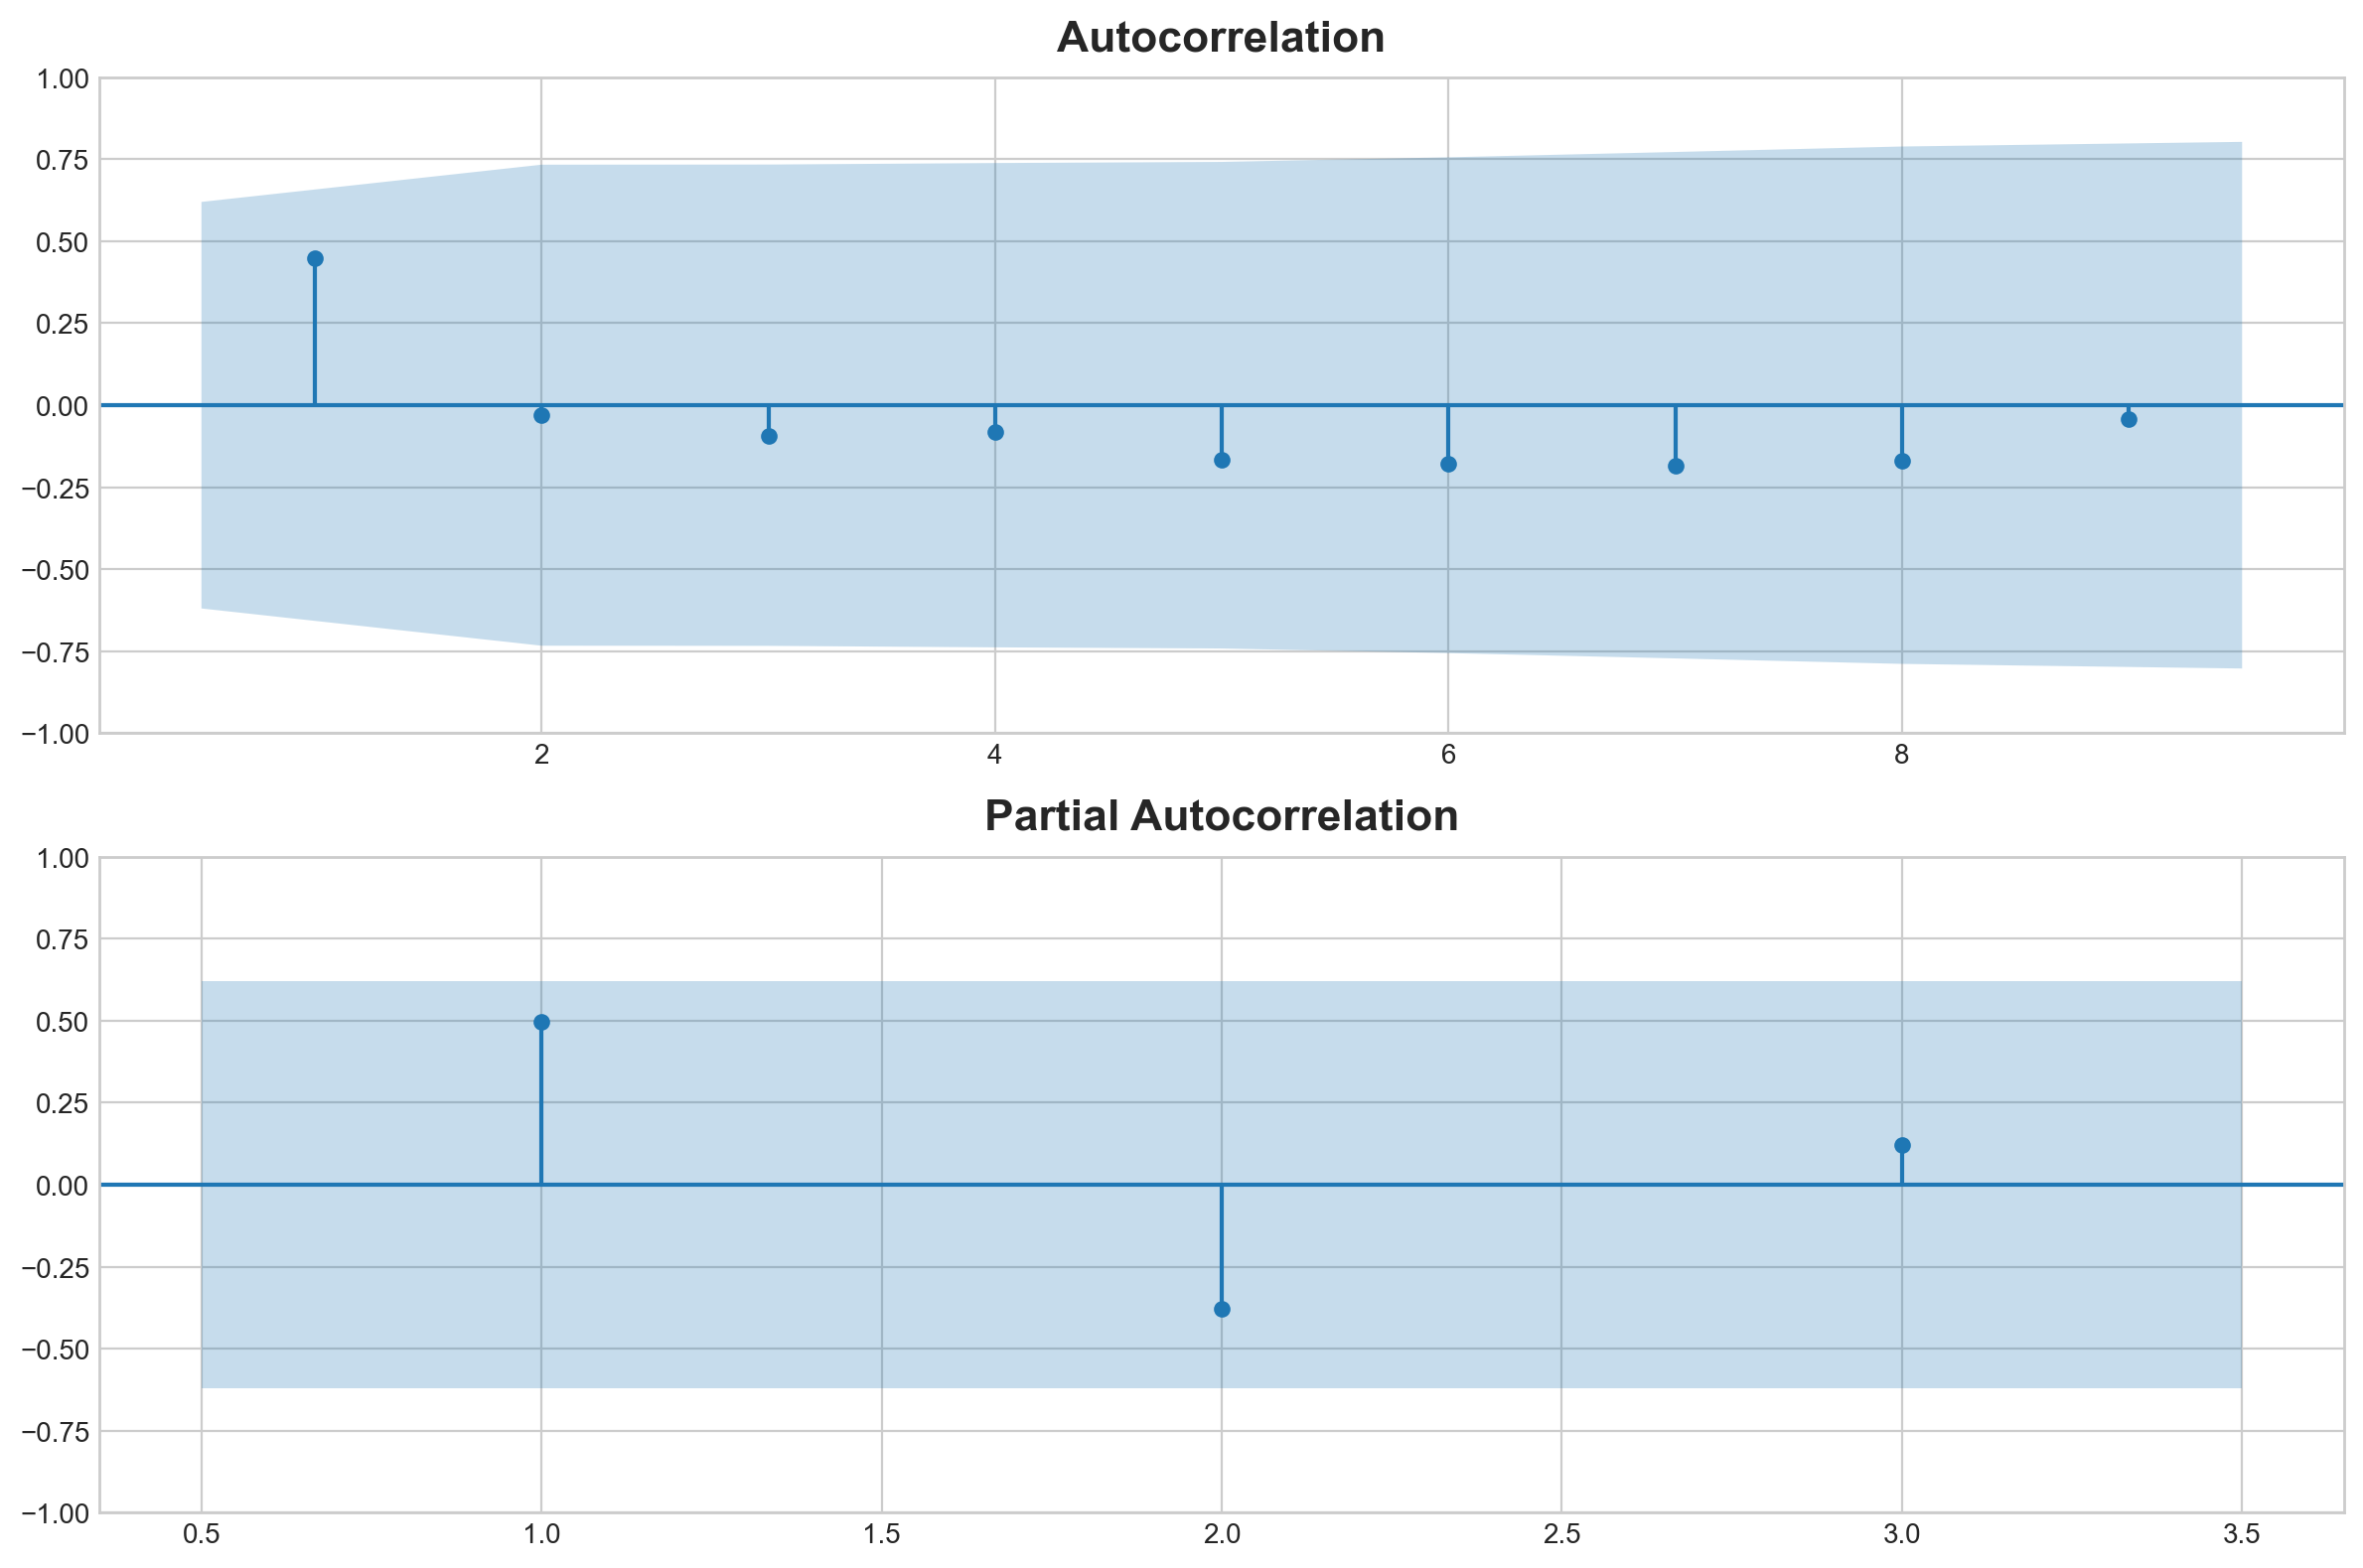

'Non-Stationary	 p-value:0.06910684048221875 	lags:1


('Non-Stationary', 0.06910684048221875)

In [90]:
#1st order
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ev_copy2["count"].diff().dropna(), zero=False, ax=ax[0])
plot_pacf(ev_copy2["count"].diff().dropna(), zero=False, lags=3,ax=ax[1])
plt.show()

check_stationarity(ev_copy2["count"].diff().dropna())

In [91]:
ev_copy2 = ev_copy2.set_index("year")
ev_copy2

,count
year,
2011,25
2012,44
2013,64
2014,80
2015,86
2016,114
2017,127
2018,134
2019,203


In [92]:
y_train, y_test = temporal_train_test_split(ev_copy2, test_size=2)
fh = ForecastingHorizon(y_test.index, is_relative=False)

0.5702664419022268

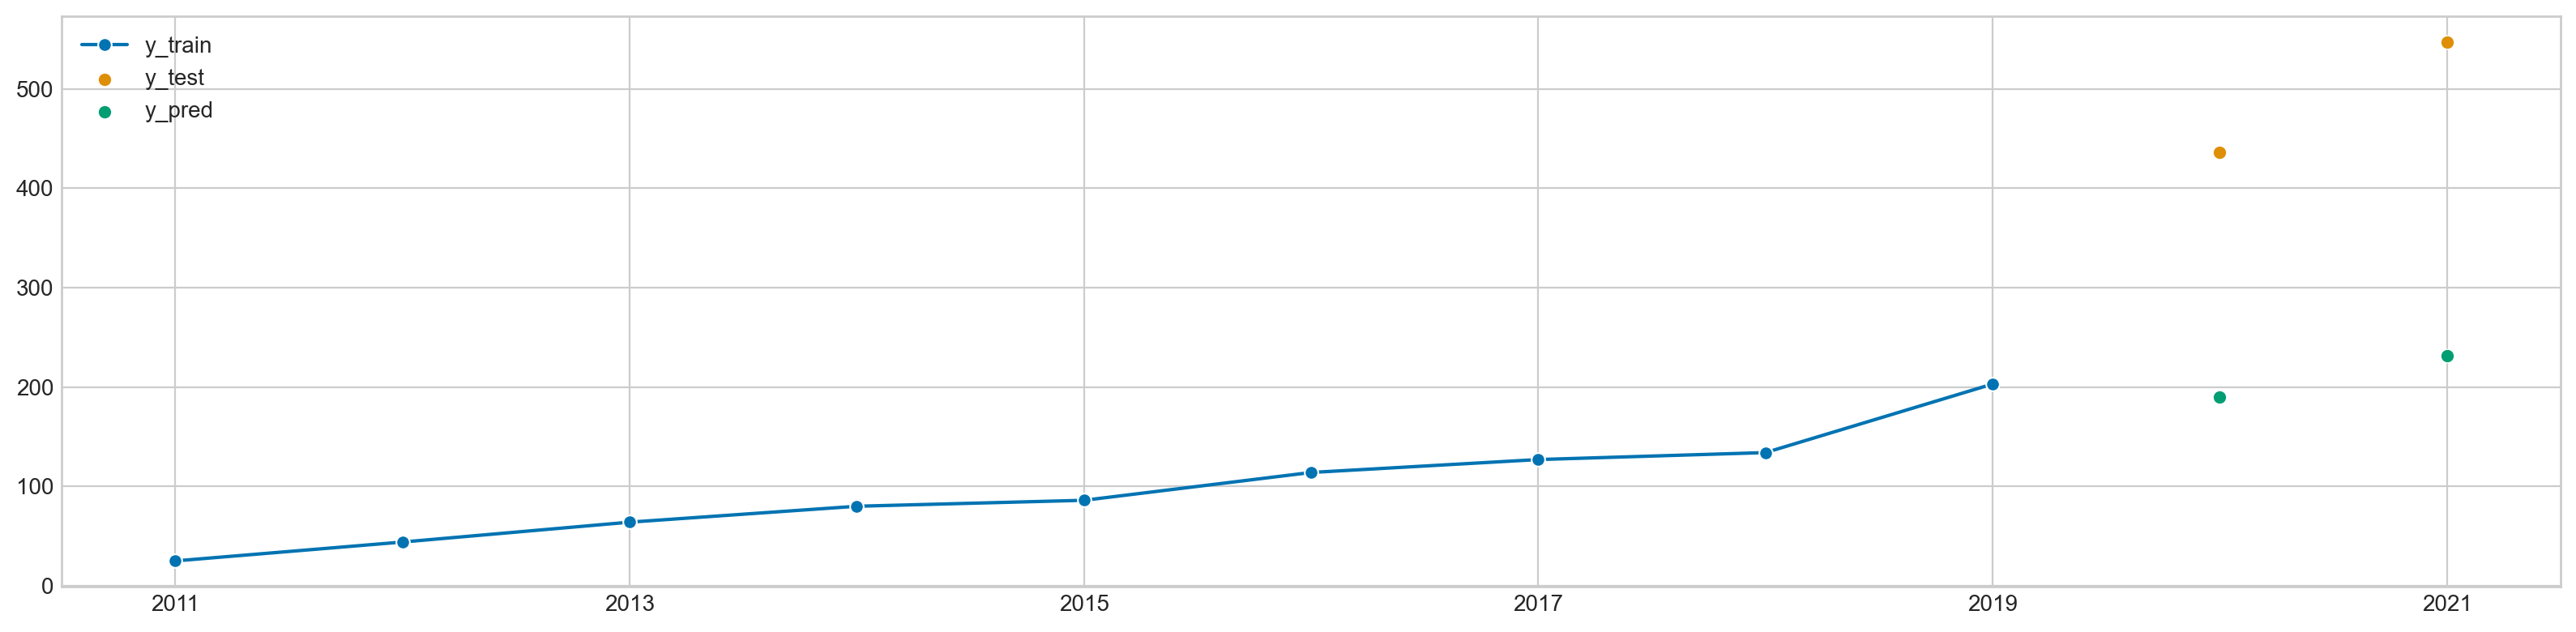

In [93]:
forecaster = ARIMA(order=(1, 1, 0),  suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [94]:
y_pred

,count
2020,190.004397
2021,231.751436


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

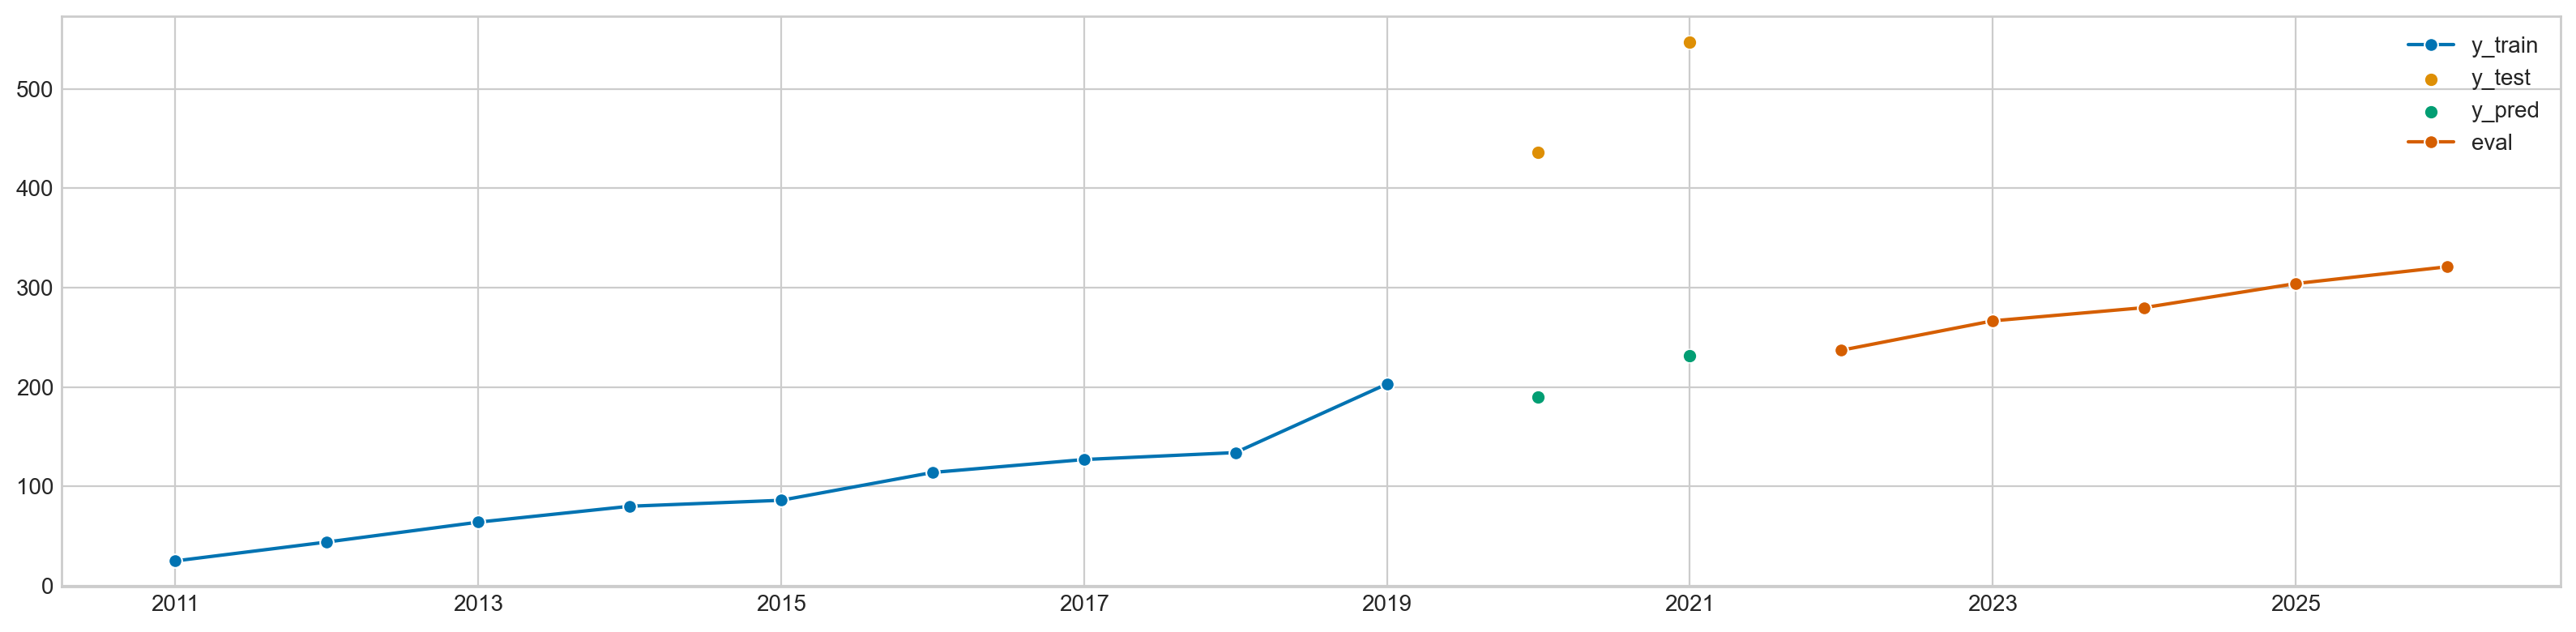

In [95]:
y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test","y_pred", "eval"])

## **Exponential Smoothing**

In [96]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.5856564144955071

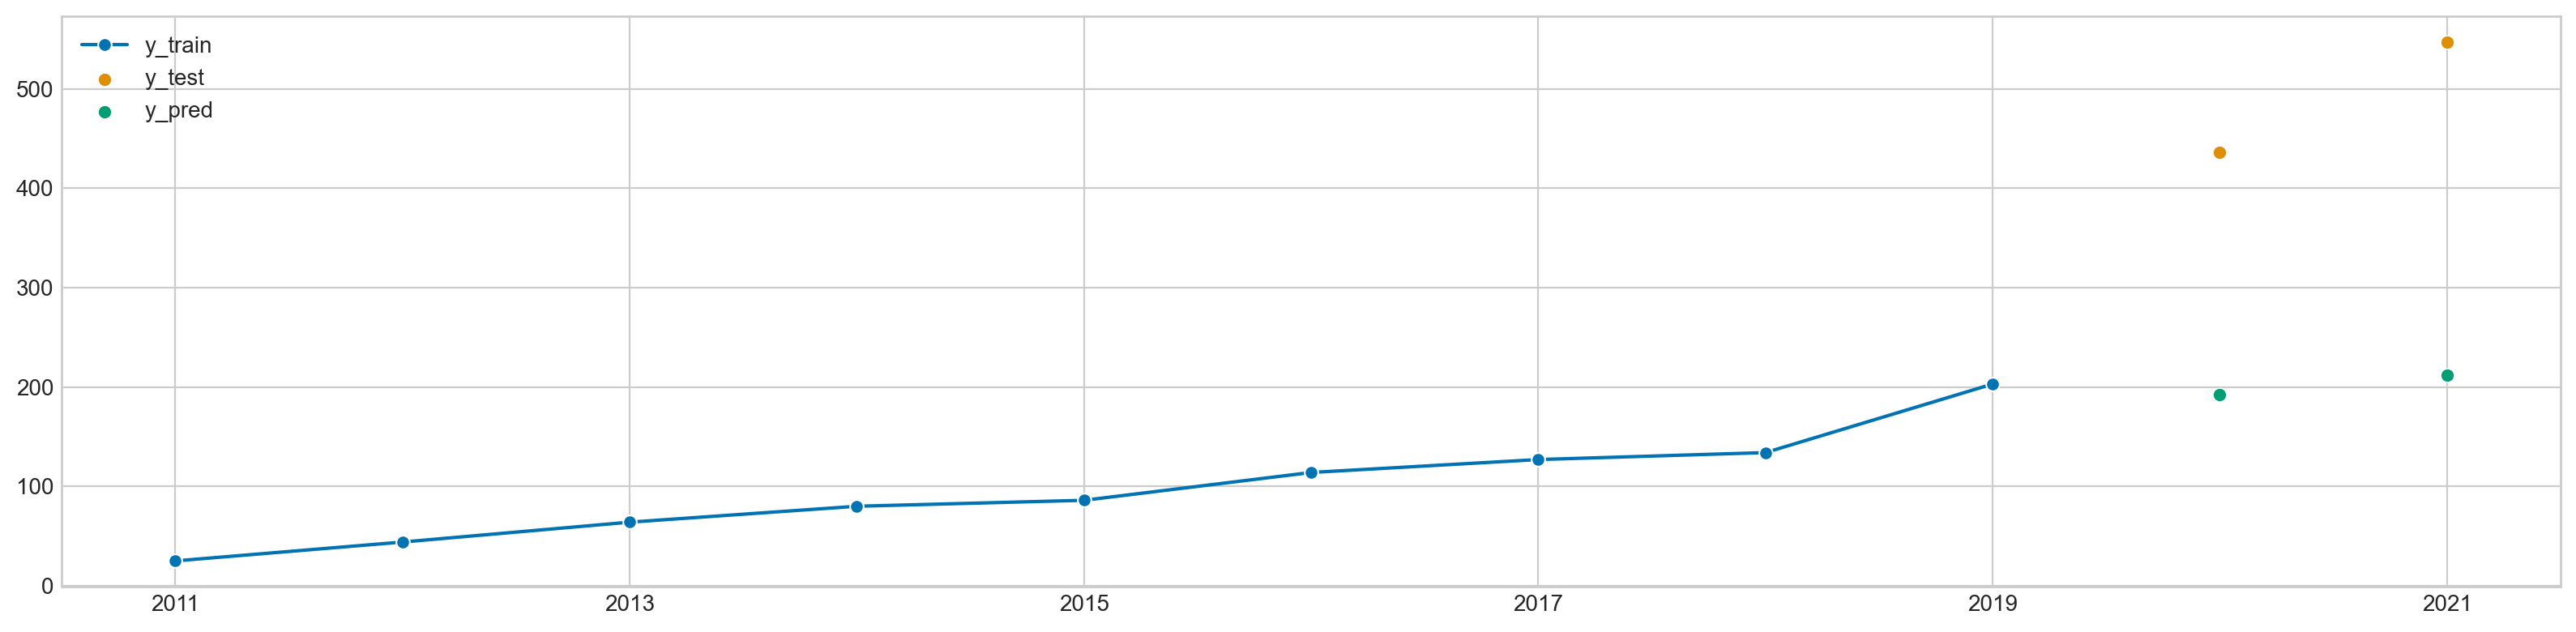

In [97]:
forecaster = ExponentialSmoothing(trend="add")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

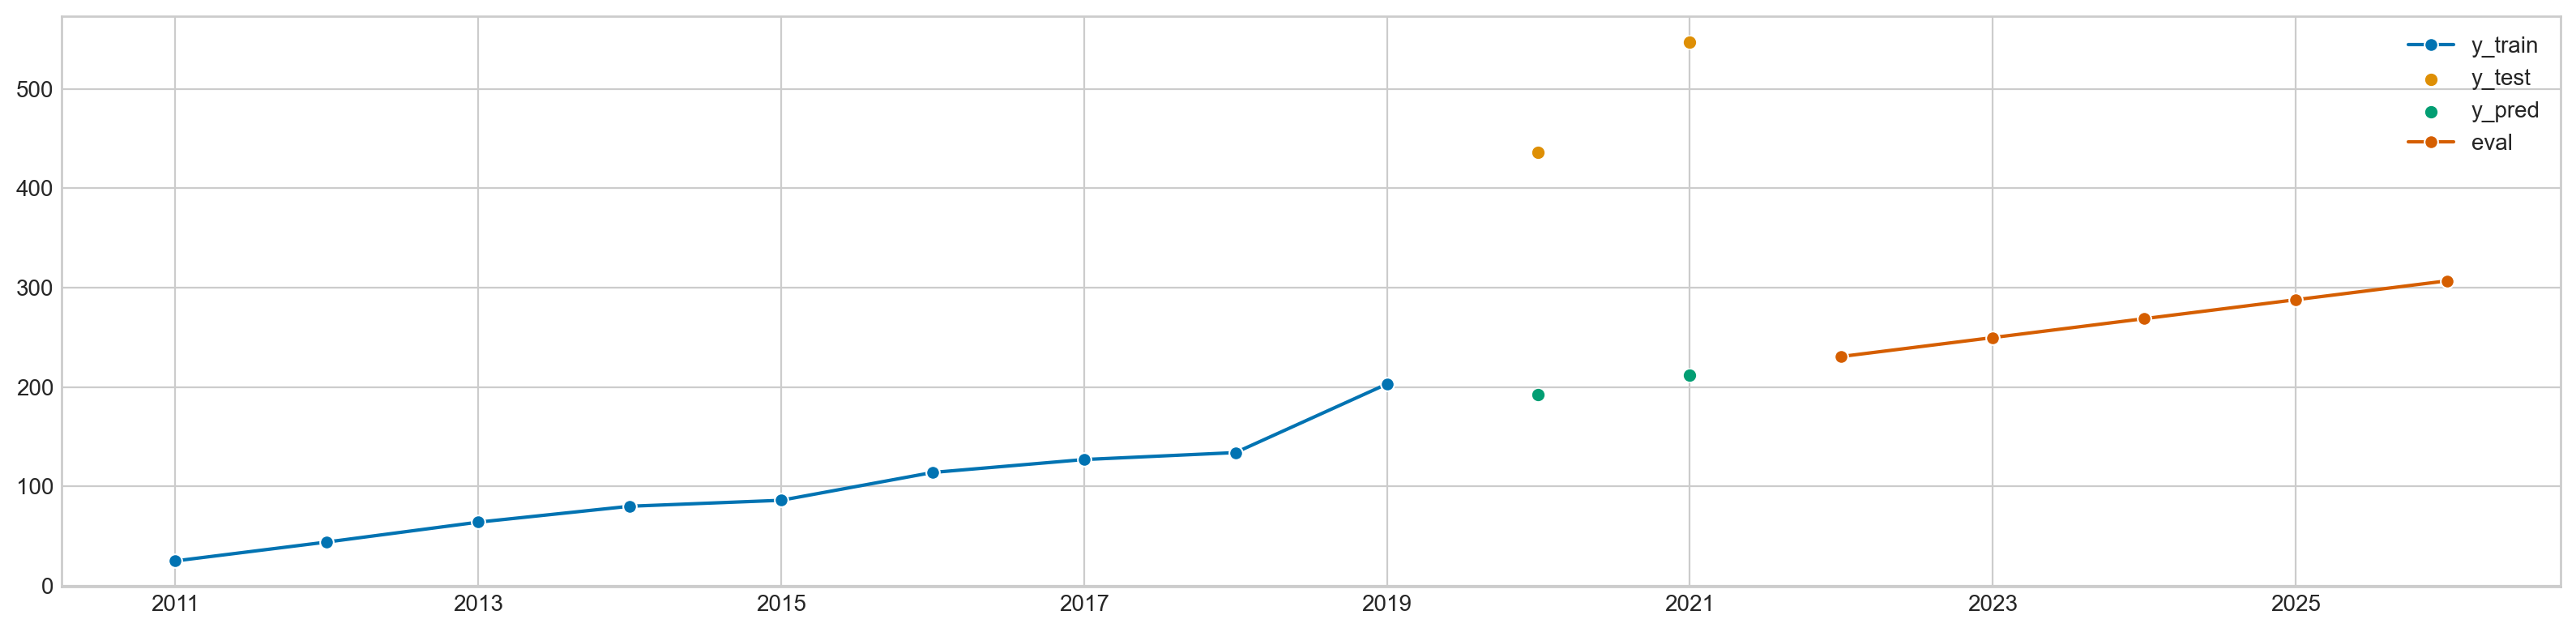

In [98]:
y_pred_eval = forecaster.predict(new_fh)
plot_series(y_train, y_test, y_pred,y_pred_eval,  labels=["y_train", "y_test", "y_pred", "eval"])

## **MACHINE LEARNING**

In [99]:
ev_copy3 = ev.copy()
ev_copy3

,year,count
0,2011,25
1,2012,44
2,2013,64
3,2014,80
4,2015,86
5,2016,114
6,2017,127
7,2018,134
8,2019,203
9,2020,436


In [100]:
ev_copy3 = ev_copy3.set_index("year")

In [101]:
ev_os = one_step_forecast(ev_copy3, 3)
print(ev_os.shape)

(8, 4)


In [102]:
ev_os

,x_1,x_2,x_3,y
year,,,,
2011,25,44,64,80
2012,44,64,80,86
2013,64,80,86,114
2014,80,86,114,127
2015,86,114,127,134
2016,114,127,134,203
2017,127,134,203,436
2018,134,203,436,547


In [103]:
train, test = split_data(ev_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 6 Test: 2


In [104]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

,x_1,x_2,x_3,y
year,,,,
2011,-1.383253,-1.357419,-1.307358,-0.992341
2012,-0.783668,-0.708454,-0.739456,-0.857022
2013,-0.152526,-0.189282,-0.526493,-0.225532
2014,0.352388,0.005408,0.467336,0.067660
2015,0.541730,0.913960,0.928757,0.225532


In [105]:
y_train_original = scaler.inverse_y(train_s['y'])

In [106]:
train_original = scaler.inverse(train_s)
train_original.head()

,x_1,x_2,x_3,y
year,,,,
2011,25.0,44.0,64.0,80.0
2012,44.0,64.0,80.0,86.0
2013,64.0,80.0,86.0,114.0
2014,80.0,86.0,114.0,127.0
2015,86.0,114.0,127.0,134.0


In [107]:
ev_results = train_different_models(train_s, test_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [108]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
ev_results = pd.DataFrame(ev_results)
ev_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
2,Ridge Regression,6.105295,0.736161,10.934119
1,Elastic Net,6.596233,0.797760,11.827955
3,Lasso Regression,7.697792,0.915949,13.701411
4,Huber Regression,10.390950,1.147900,17.687439
0,Linear Regression,10.386595,1.148244,17.688418


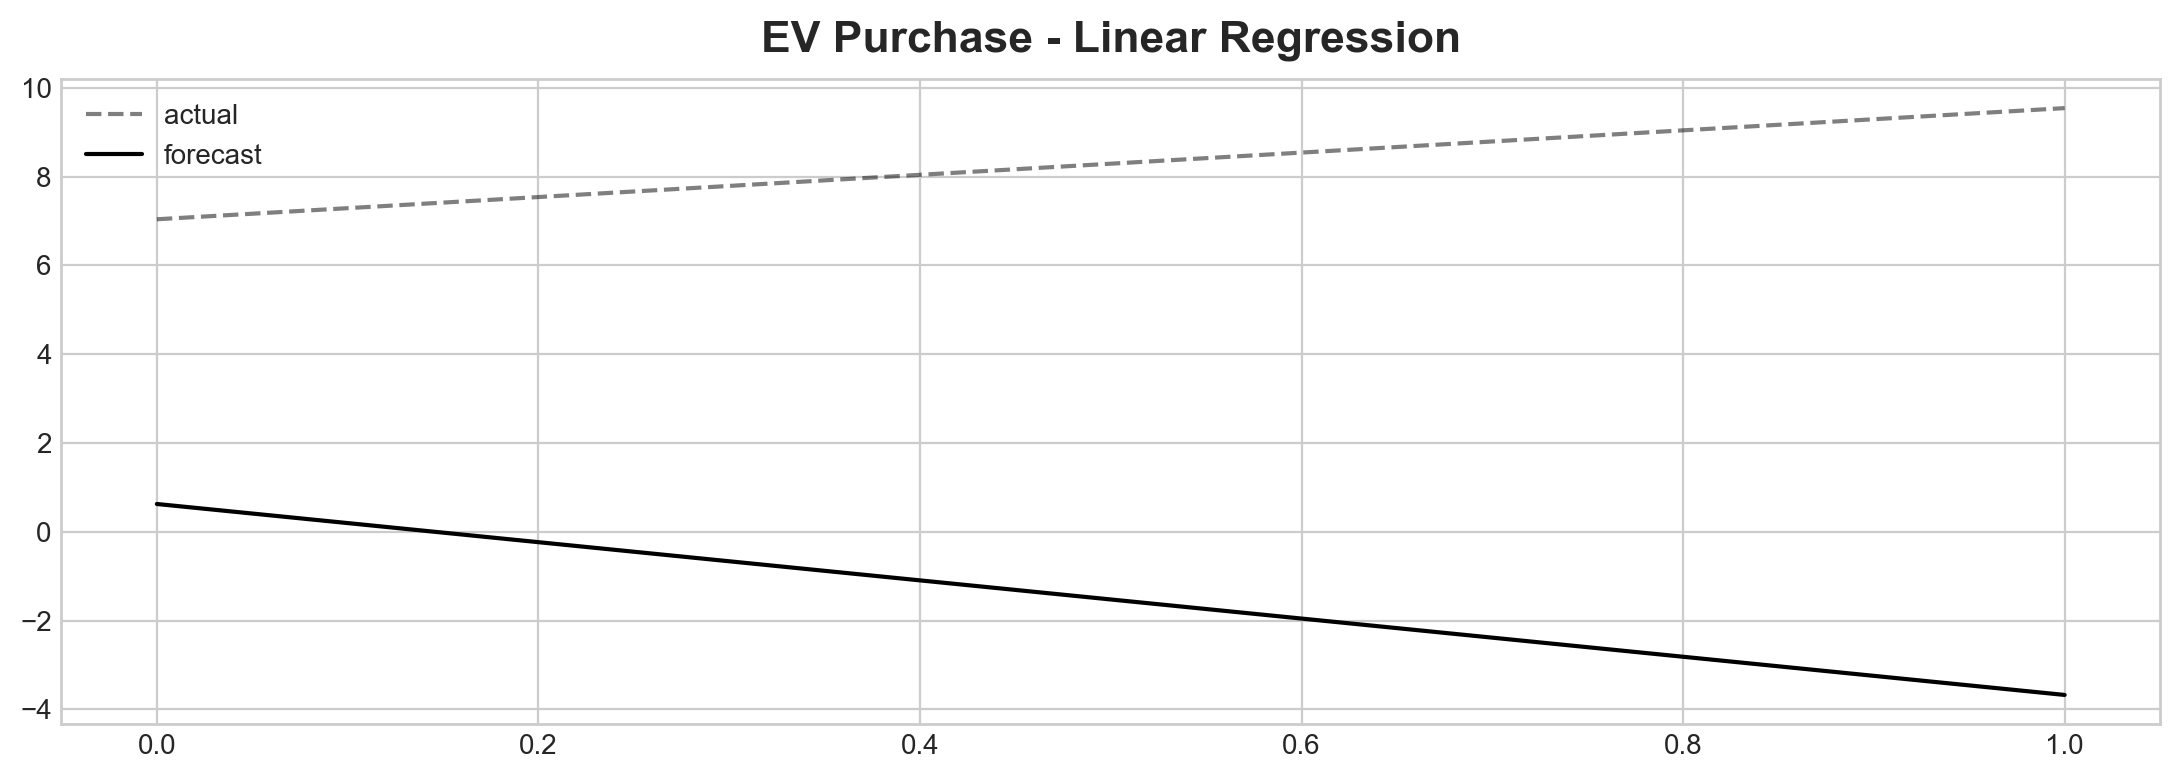

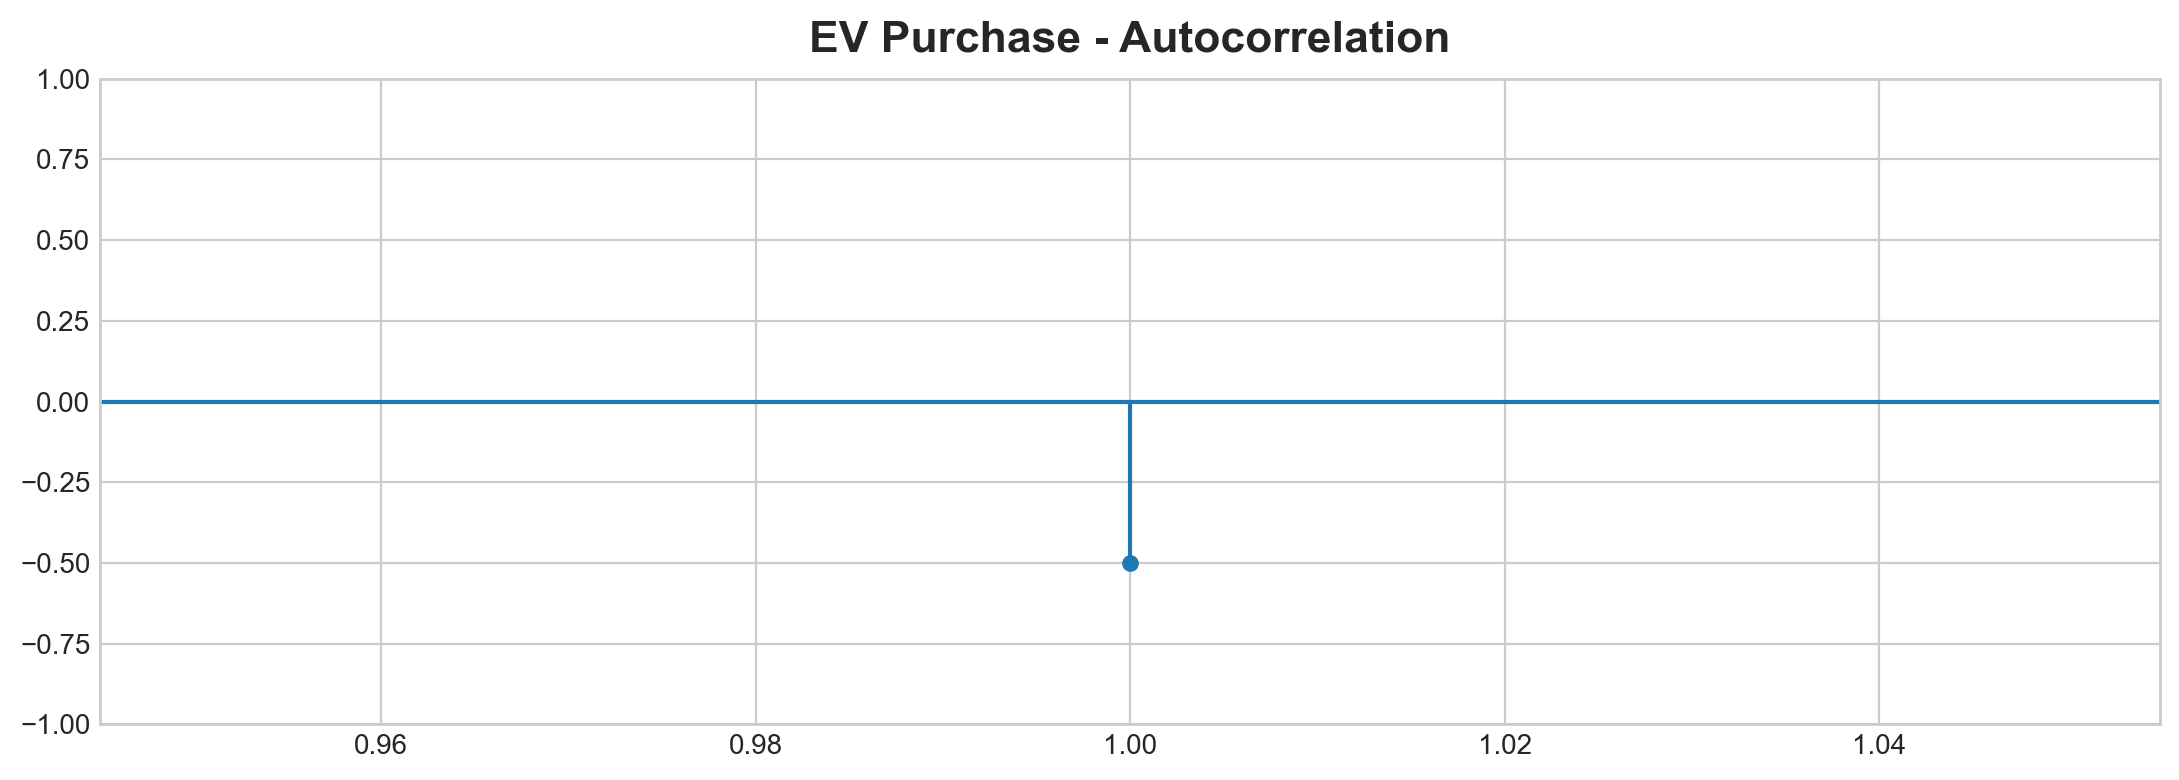

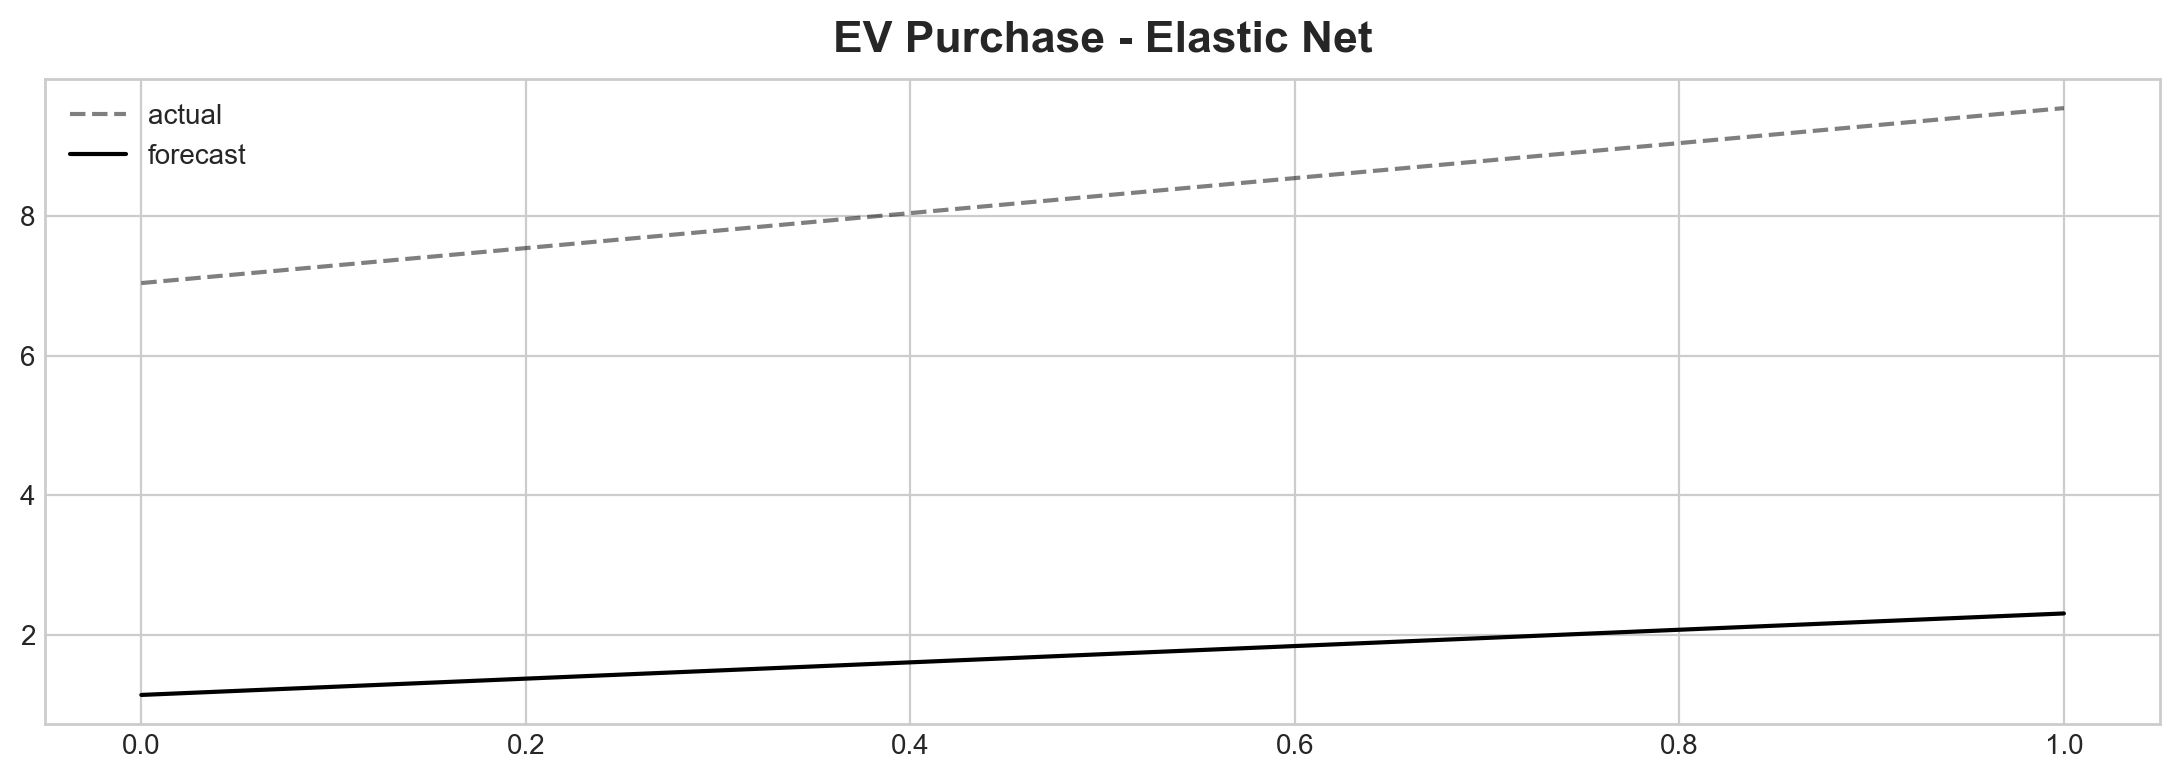

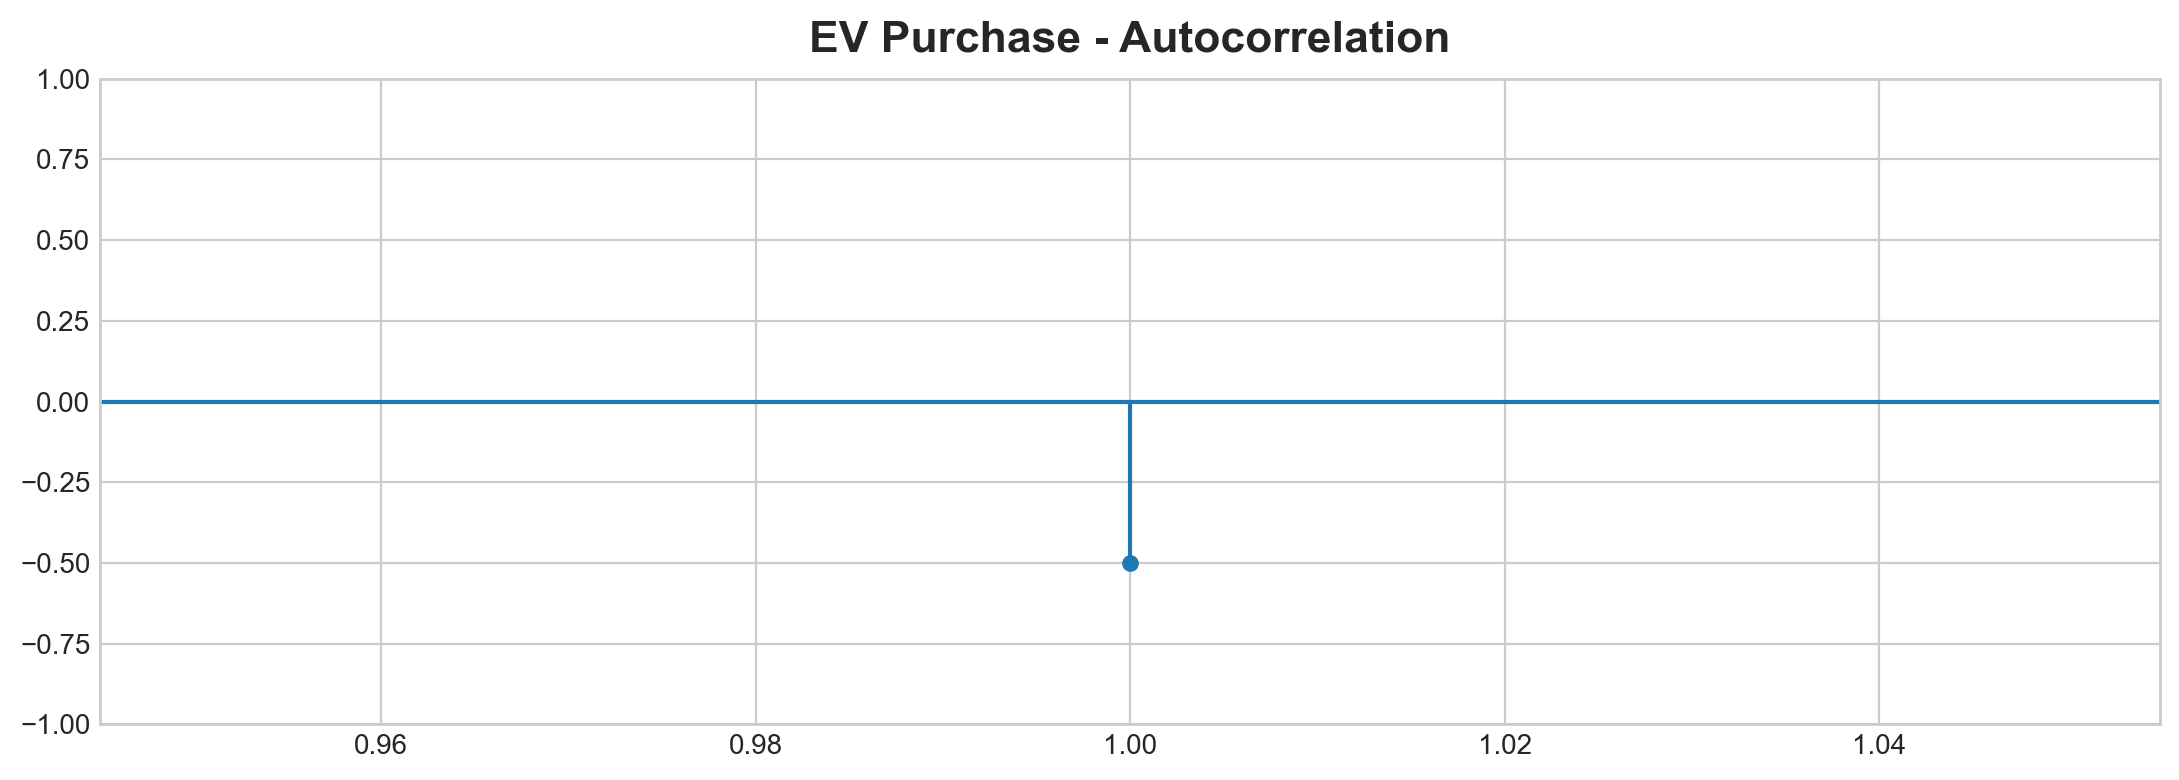

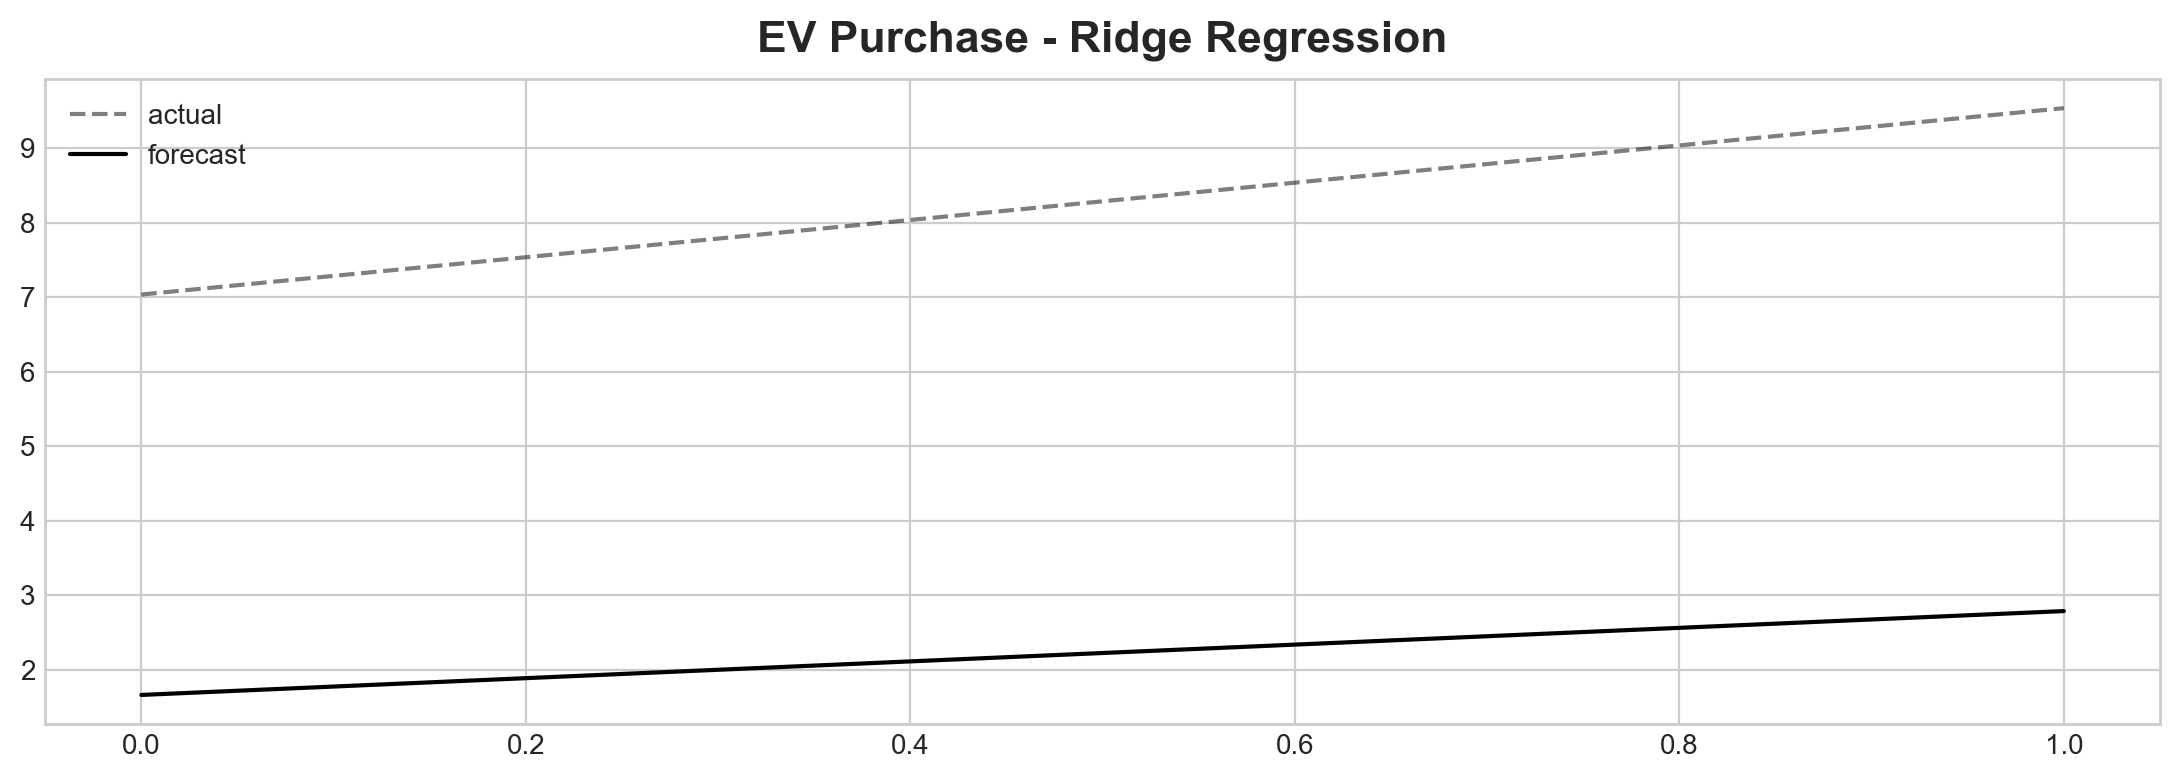

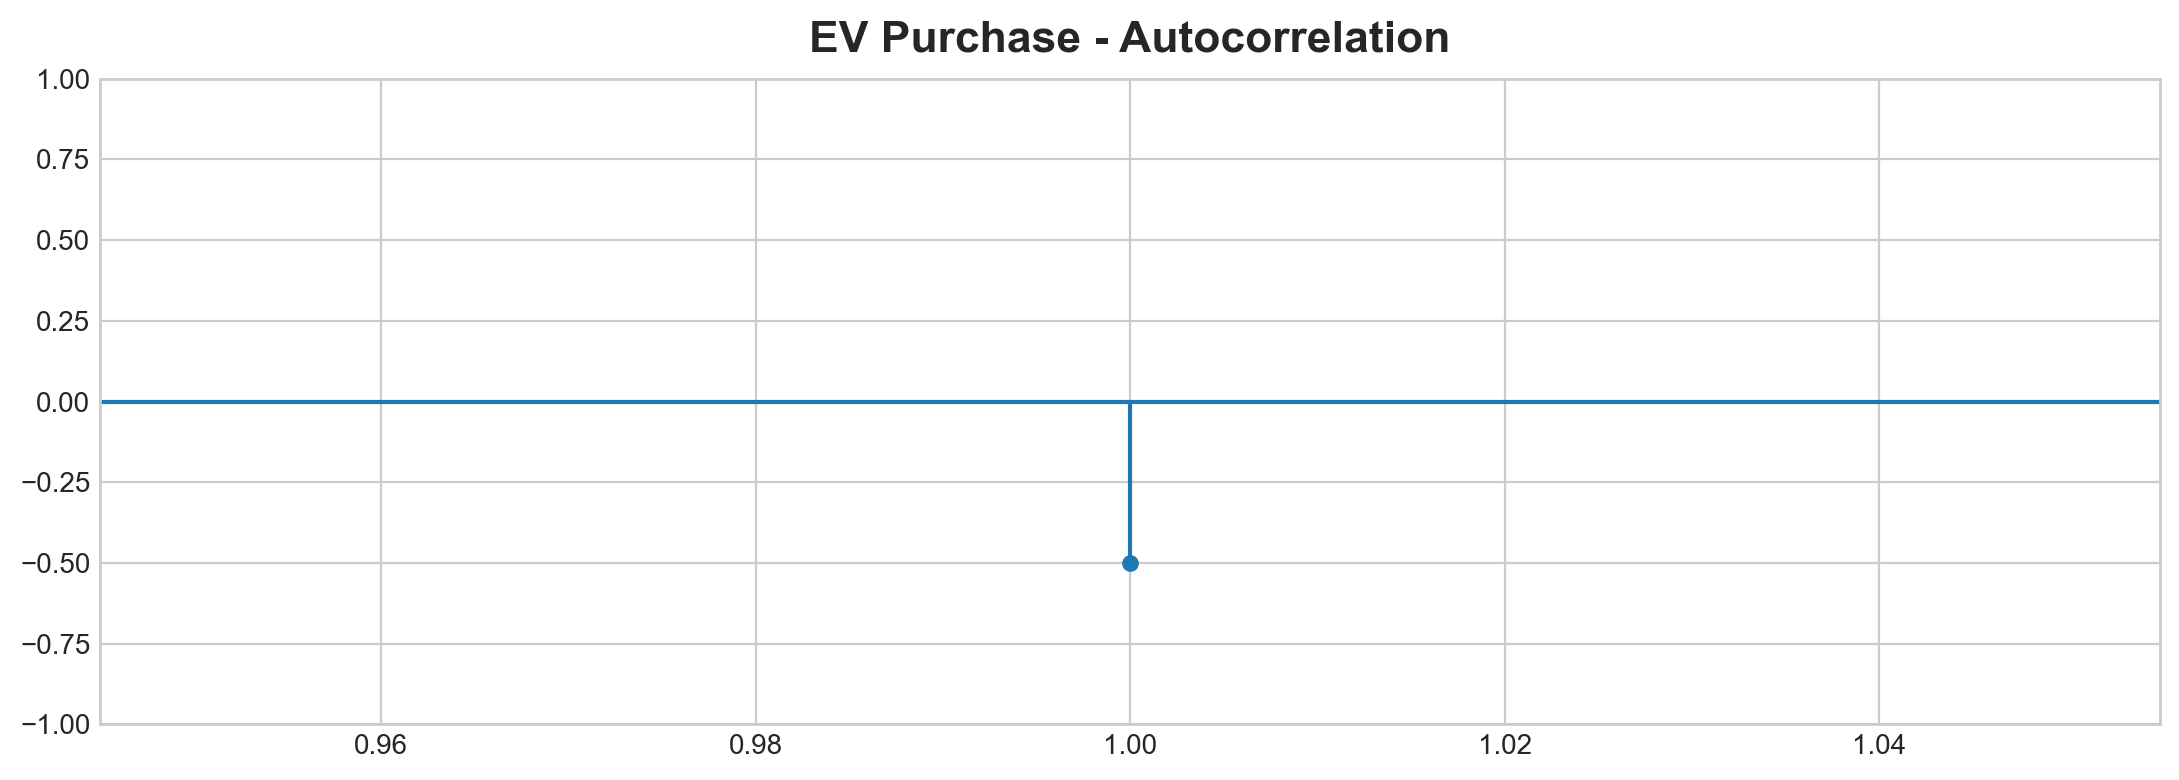

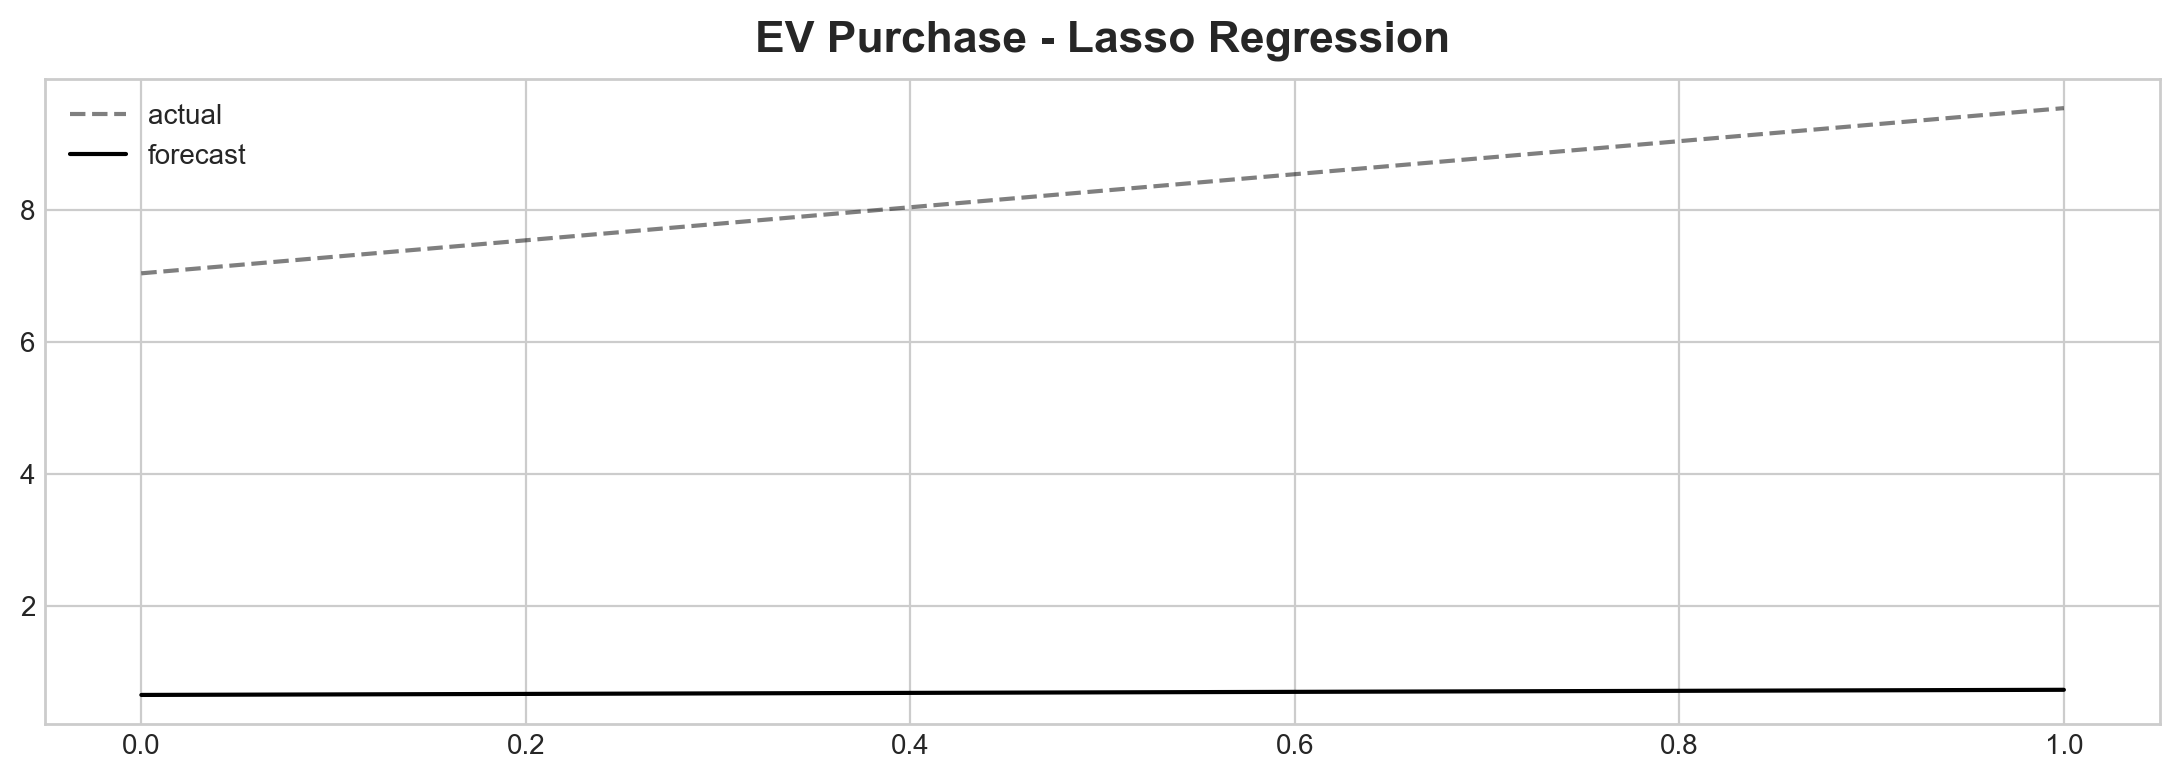

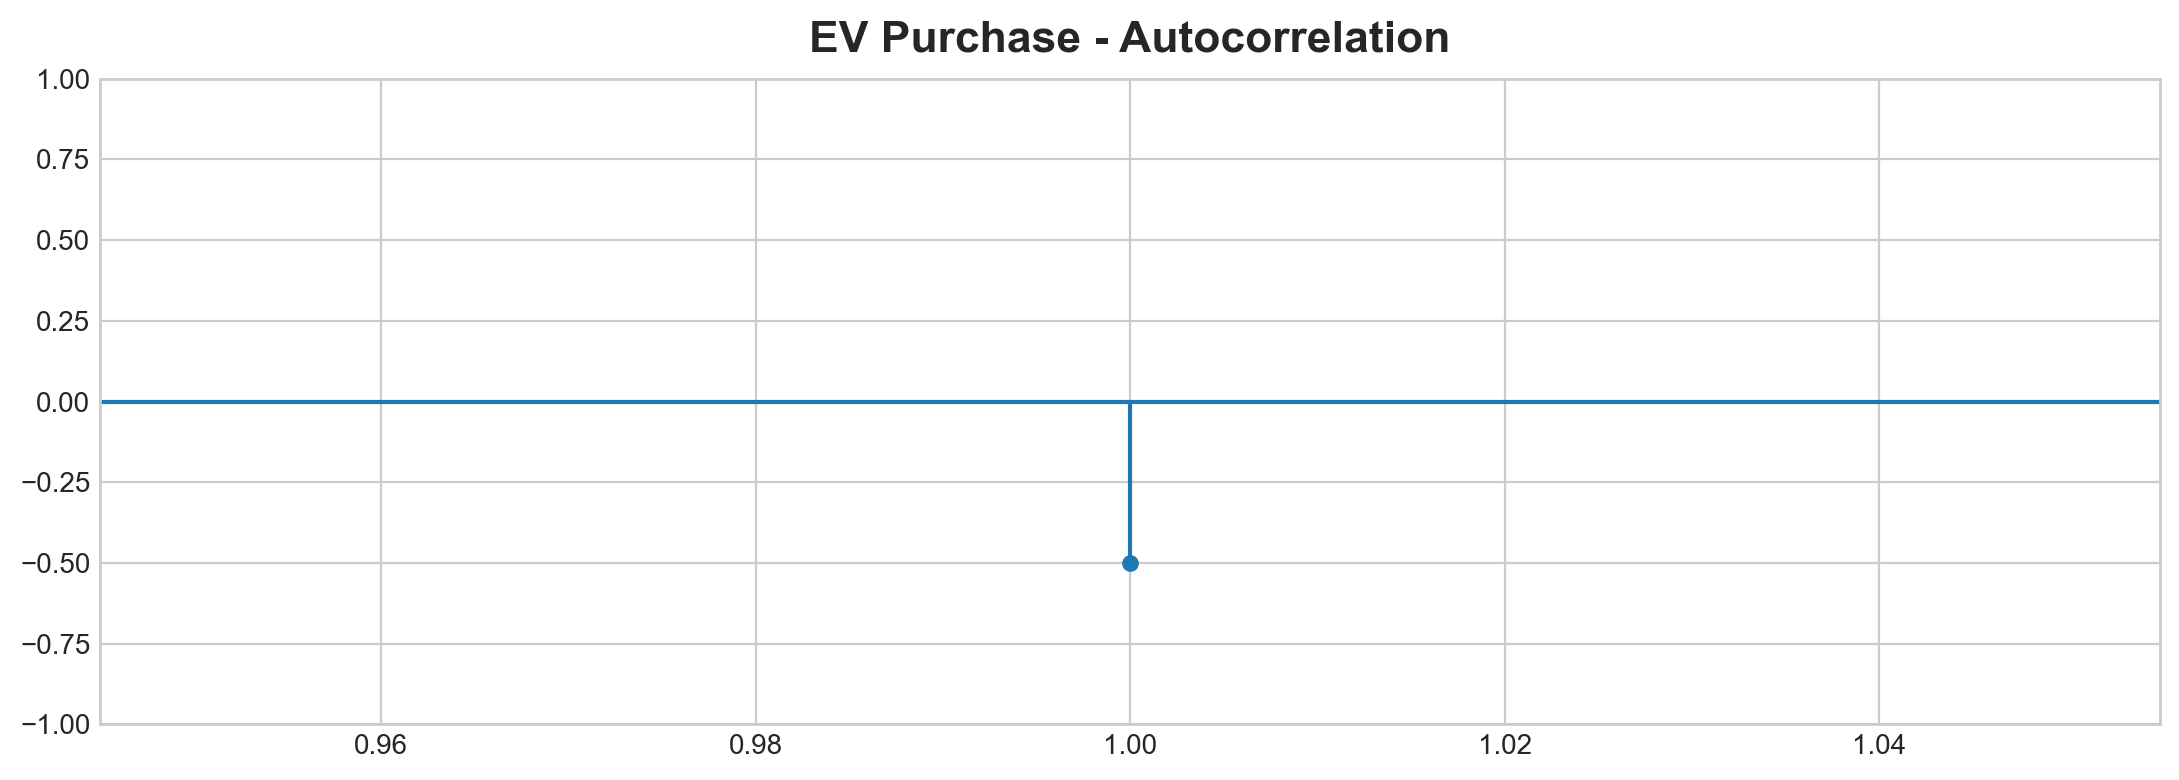

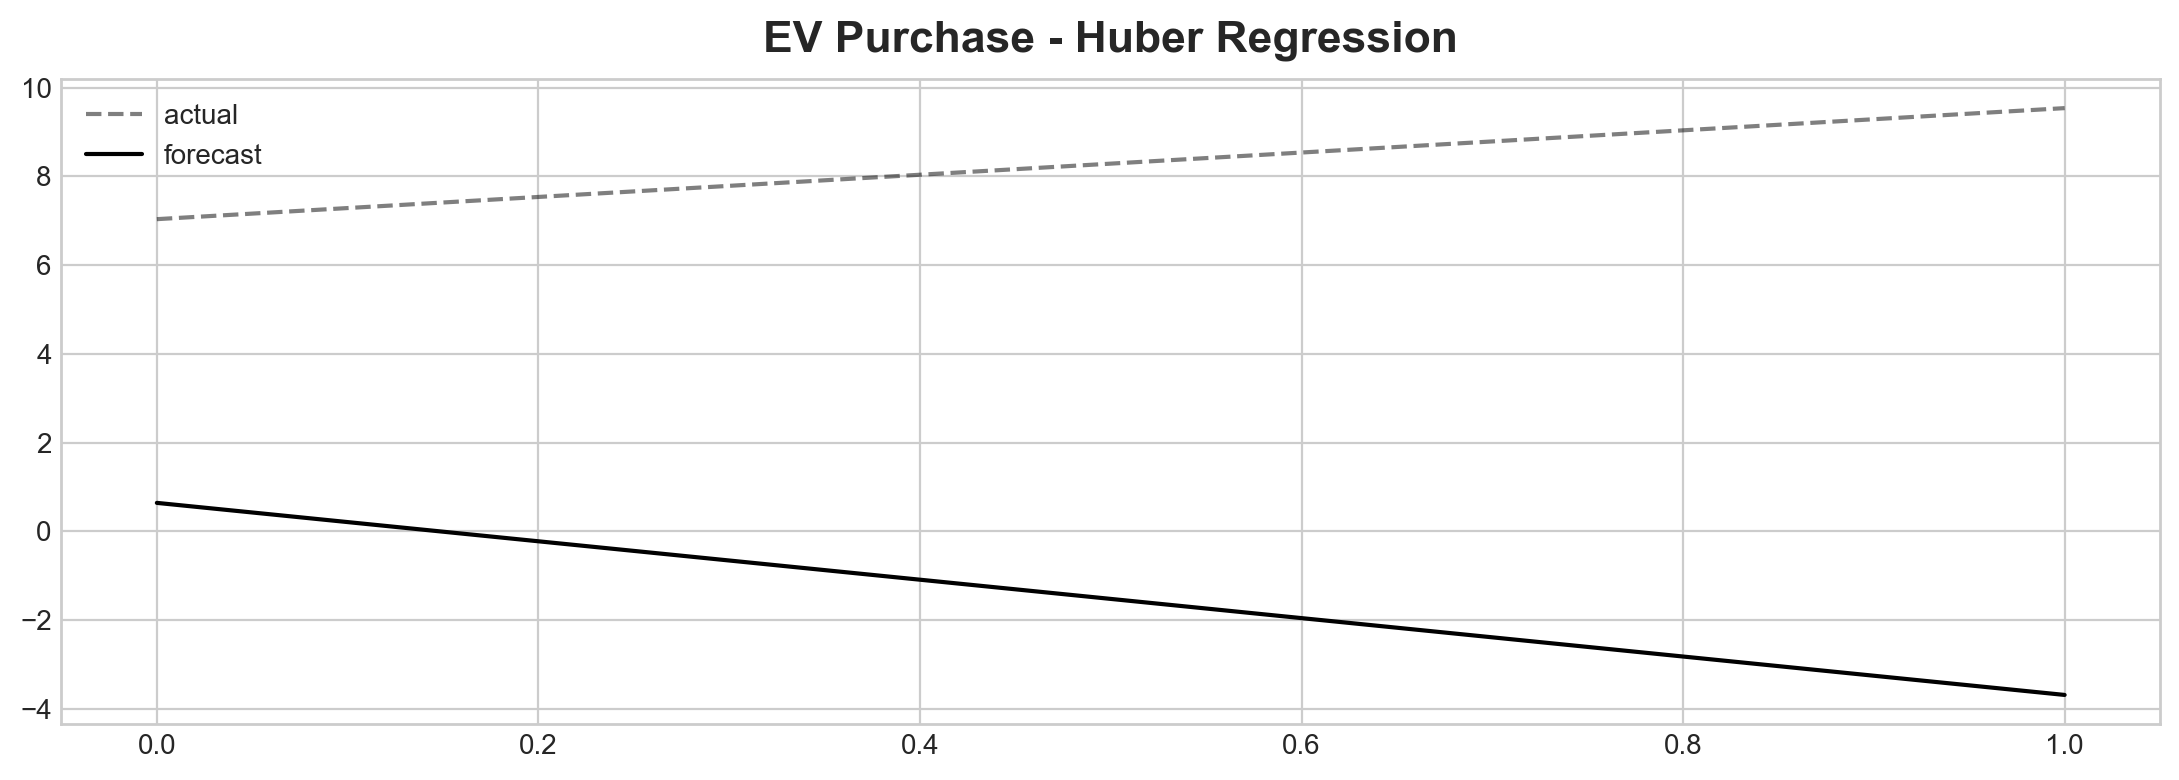

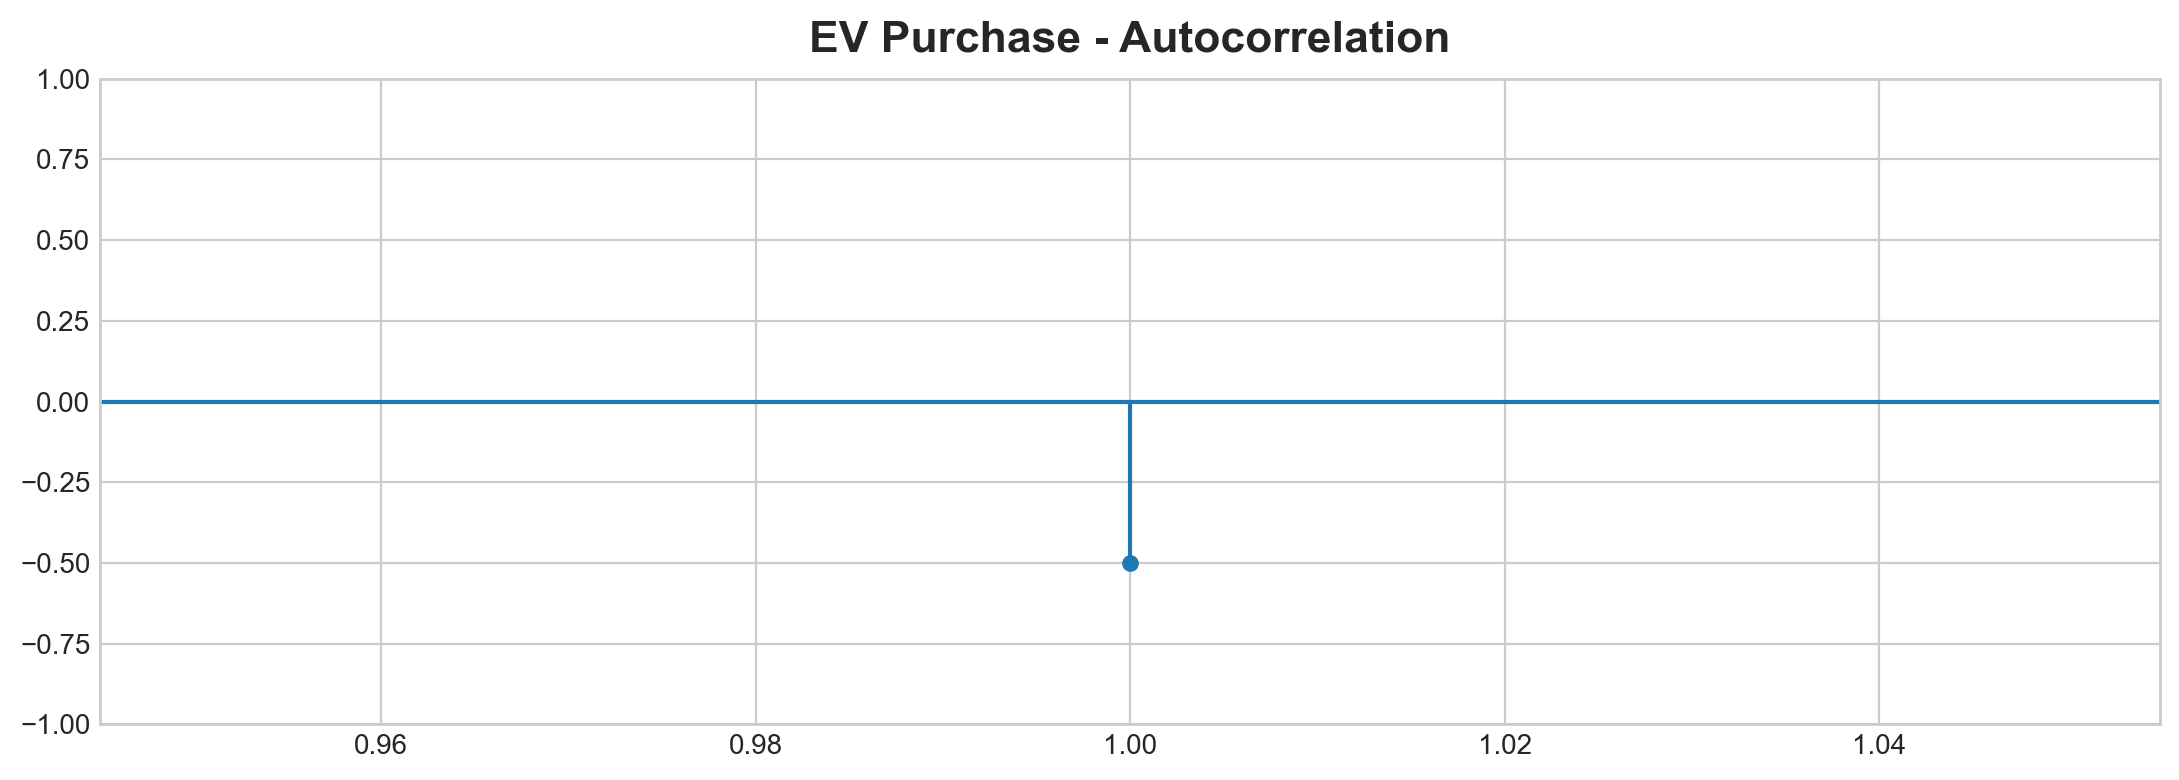

In [109]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, ev_results, 'EV Purchase')

In [110]:
cols = ['Model Name', 'Model']
en_models = ev_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 1.40337784  0.12108166 -0.59025694]
Elastic Net
[0.30008008 0.18920003 0.0817615 ]
Ridge Regression
[0.57336899 0.289029   0.04263188]
Lasso Regression
[0.35284234 0.         0.        ]


## Recursive multi-step forecasting

In [111]:
ev_copy4 = ev.copy()
ev_copy4

,year,count
0,2011,25
1,2012,44
2,2013,64
3,2014,80
4,2015,86
5,2016,114
6,2017,127
7,2018,134
8,2019,203
9,2020,436


In [112]:
ev_copy4.rename(columns={"count": "y"}, inplace=True)

In [113]:
ev_copy4 = ev_copy4.set_index("year")
ev_copy4

,y
year,
2011,25
2012,44
2013,64
2014,80
2015,86
2016,114
2017,127
2018,134
2019,203


In [114]:
ev_copy4 = ev_copy4['y']

In [115]:
steps = 2
data_train = ev_copy4[:-steps]
data_test  = ev_copy4[-steps:]

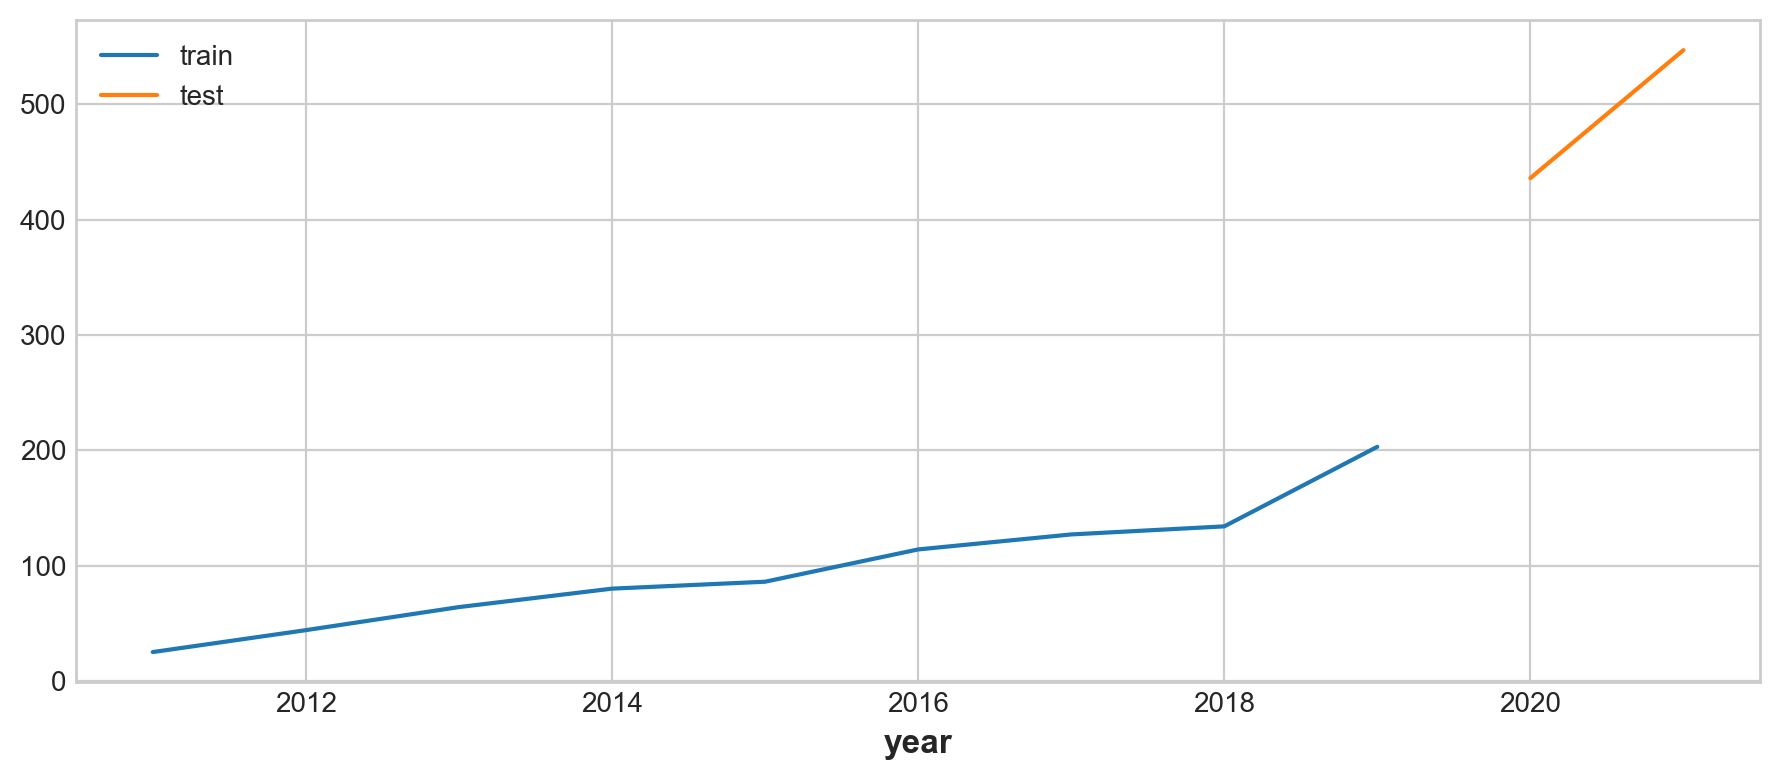

In [116]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [117]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-10 15:59:31 
Last fit date: 2023-02-10 15:59:32 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [118]:
predictions = forecaster.predict(steps=2)
predictions.head()

8    203.0
9    203.0
Name: pred, dtype: float64

In [119]:
predictions.index = [2020,2021]

In [120]:
ahead_predictions = forecaster.predict(steps=7)
ahead_predictions

8     203.0
9     203.0
10    203.0
11    203.0
12    203.0
13    203.0
14    203.0
Name: pred, dtype: float64

In [121]:
ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]

In [122]:
ahead_predictions

2020    203.0
2021    203.0
2022    203.0
2023    203.0
2024    203.0
2025    203.0
2026    203.0
Name: pred, dtype: float64

In [123]:
ahead_predictions.drop([2020,2021],axis=0,inplace=True)

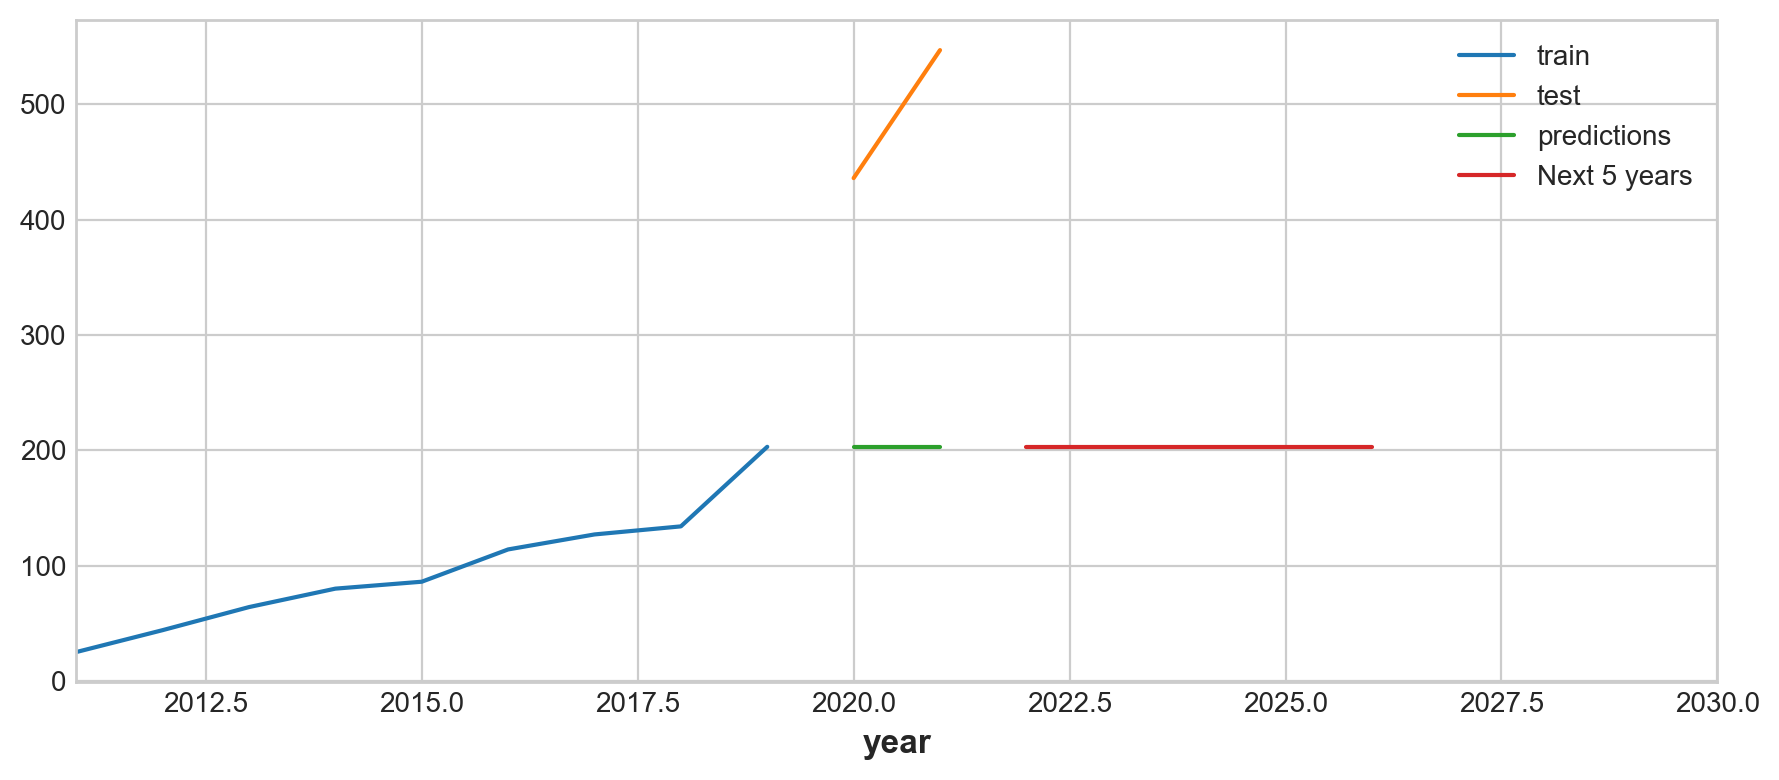

In [124]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

## **XGBOOST**

In [125]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(),
                 lags = 8
             )

forecaster.fit(y=data_train,)
forecaster

[15:59:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ForecasterAutoreg 
Regressor: XGBRegressor() 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} 
Creation date: 2023-02-10 15:59:33 
Last fit date: 2023-02-10 15:59:33 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [126]:
predictions= forecaster.predict(steps=2,)
predictions

8    201.801102
9    201.801102
Name: pred, dtype: float64

In [127]:
predictions.index = [2020,2021]

In [128]:
ahead_predictions = forecaster.predict(steps=7,)

ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]
ahead_predictions.drop([2020,2021],axis=0,inplace=True)

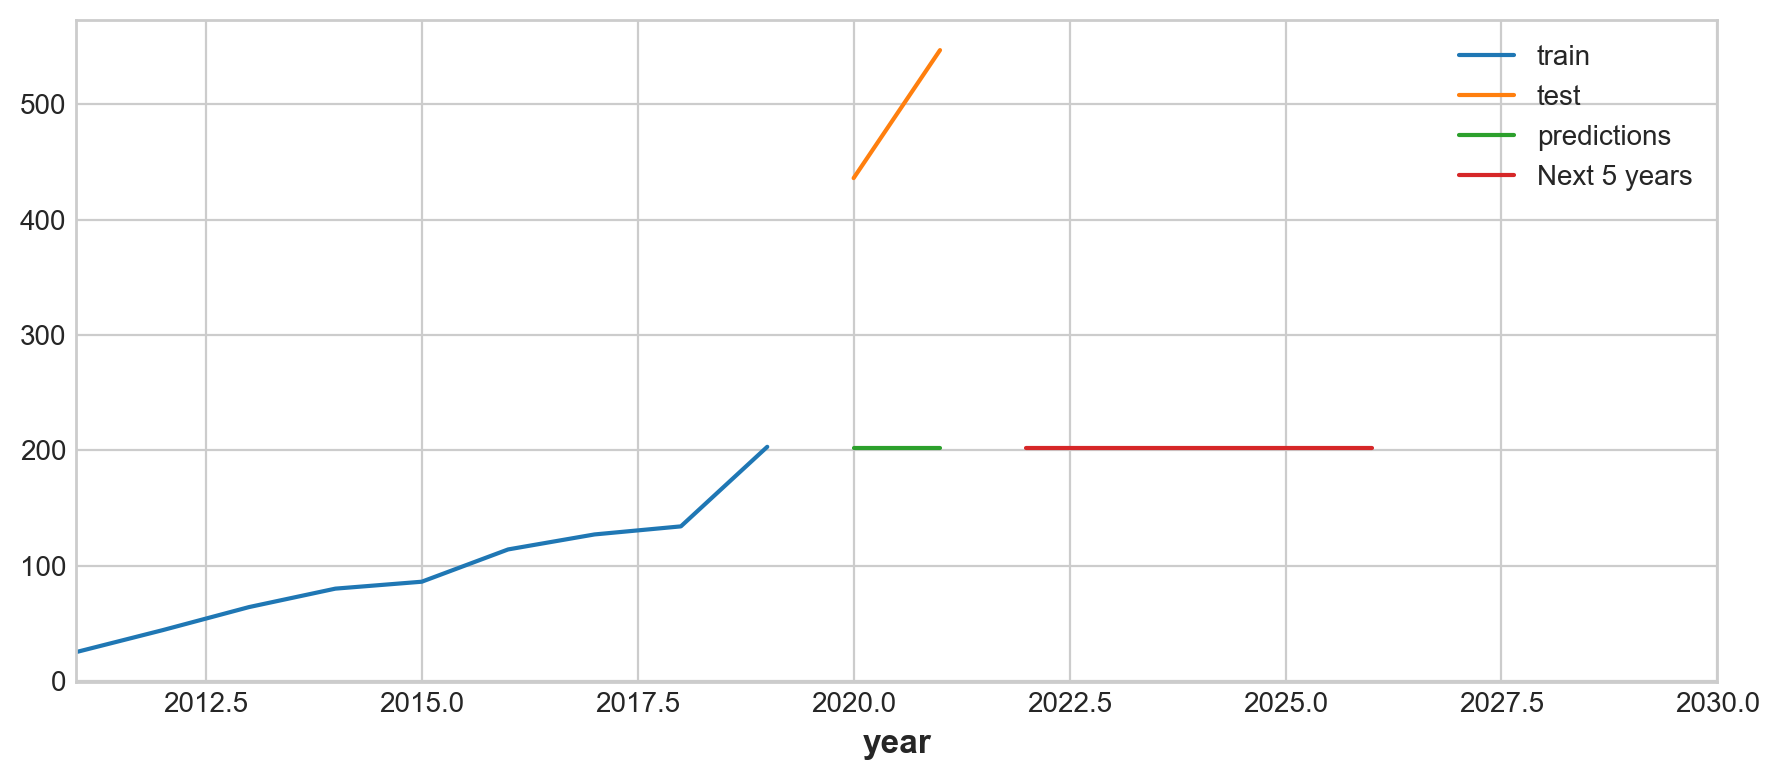

In [129]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();